# Recommender Systems - Mini Challenge HS25

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** Sunday of SW11 um 18:00 

## Guidelines for Implementation and Submiion
- Code must be written in Python. The versions of all used packages must be given for reproducability.
- You may respond in English or German.
- We develop numerous algorithms ourselves. Unle explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- All pathes must be relative and just downloading your repo must be executable without modifications.
- Only fully running code is graded. The notebook must run sequential from start to end.
- During development, if computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results must be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot must be accompanied by a brief discuion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discuion will be aeed.
- The last commit in your fork of the repo before the submiion deadline counts as the submiion.
- Points will be deducted if you write inconsise (Denial of service will be punished) or if I read text not written for me but for the user of ChatGPT oir similar. 
- If you would like to submit and have the mini-challenge aeed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submiion.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 

a) Describe the available data.

b) Find and fix bad data (e.g. duplicates, miing values, etc.).

Generate lists of

c) - Top 20 movies by average rating

d) - Top 20 movies by number of views

e) What is the range of the ratings? 

f) Which genre has be rated how many times?

g) How sparse is the User Rating Matrix?

Plot the following:

h) How many users have rated how many movies

i) Which rating is given how often over time with a time resolution of month 

j) Which rating is given how often per genre

k) The rating distributions of 10 random movies

l) The rating distributions of 3 movies that you have watched

m) How many users give which average rating

n) How often a movie was rated as a function of average rating

o) A heatmap of the User Item Matrix

p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import itertools

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
import scipy.sparse as sp

from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
import umap
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the datasets
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

print("\nDataset shapes:")
print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")
print(f"Links: {links.shape}")
print(f"Tags: {tags.shape}")



Dataset shapes:
Ratings: (100836, 4)
Movies: (9742, 3)
Links: (9742, 3)
Tags: (3683, 4)


In [2]:
# a) Describe the available data
print("\n1. RATINGS DATASET:")
print(ratings.head())
print(f"\nColumns: {list(ratings.columns)}")
print(f"Data types:\n{ratings.dtypes}")
print(f"Basic statistics:\n{ratings.describe()}")

print("\n2. MOVIES DATASET:")
print(movies.head())
print(f"\nColumns: {list(movies.columns)}")
print(f"Data types:\n{movies.dtypes}")

print("\n3. LINKS DATASET:")
print(links.head())
print(f"\nColumns: {list(links.columns)}")
print(f"Data types:\n{links.dtypes}")

print("\n4. TAGS DATASET:")
print(tags.head())
print(f"\nColumns: {list(tags.columns)}")
print(f"Data types:\n{tags.dtypes}")

print("\n=== DATA OVERVIEW ===")
print(f"• Total ratings: {len(ratings):,}")
print(f"• Unique users: {ratings['userId'].nunique():,}")
print(f"• Unique movies: {ratings['movieId'].nunique():,}")
print(f"• Total movies in dataset: {len(movies):,}")
print(f"• Total tags: {len(tags):,}")
print(f"• Rating period: {datetime.fromtimestamp(ratings['timestamp'].min()).strftime('%Y-%m-%d')} to {datetime.fromtimestamp(ratings['timestamp'].max()).strftime('%Y-%m-%d')}")



1. RATINGS DATASET:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Columns: ['userId', 'movieId', 'rating', 'timestamp']
Data types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Basic statistics:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.0000

In [3]:
# b) Find and fix bad data

# 1. MIING VALUES ANALYSIS
print("\n1. MIING VALUES ANALYSIS:")
print("Ratings dataset:")
print(ratings.isnull().sum())
print("\nMovies dataset:")
print(movies.isnull().sum())
print("\nLinks dataset:")
print(links.isnull().sum())
print("\nTags dataset:")
print(tags.isnull().sum())

# 2. DUPLICATES ANALYSIS
print("\n2. DUPLICATES ANALYSIS:")
print(f"Duplicate ratings: {ratings.duplicated().sum()}")
print(f"Duplicate movies: {movies.duplicated().sum()}")
print(f"Duplicate links: {links.duplicated().sum()}")
print(f"Duplicate tags: {tags.duplicated().sum()}")
print(f"Duplicate user-movie ratings: {ratings.duplicated(subset=['userId', 'movieId']).sum()}")

# 3. DATA CONSISTENCY ANALYSIS
print("\n3. DATA CONSISTENCY ANALYSIS:")
movies_in_ratings_not_movies = set(ratings['movieId']) - set(movies['movieId'])
movies_in_movies_not_ratings = set(movies['movieId']) - set(ratings['movieId'])
print(f"Movies in ratings but not in movies: {len(movies_in_ratings_not_movies)}")
print(f"Movies in movies but not in ratings: {len(movies_in_movies_not_ratings)}")

# 4. INVALID DATA ANALYSIS
print("\n4. INVALID DATA ANALYSIS:")
invalid_ratings = ratings[(ratings['rating'] < 0.5) | (ratings['rating'] > 5.0)]
print(f"Invalid ratings (outside 0.5-5.0 range): {len(invalid_ratings)}")

movies_no_genres = movies[movies['genres'] == '(no genres listed)']
print(f"Movies with no genres: {movies_no_genres.shape[0]}")

# Check for negative user IDs or movie IDs
negative_user_ids = ratings[ratings['userId'] <= 0]
negative_movie_ids = ratings[ratings['movieId'] <= 0]
print(f"Negative user IDs: {len(negative_user_ids)}")
print(f"Negative movie IDs: {len(negative_movie_ids)}")

# Check for invalid timestamps (before 1995 or after 2024)
invalid_timestamps = ratings[(ratings['timestamp'] < 788918400) | (ratings['timestamp'] > 1735689600)]
print(f"Invalid timestamps: {len(invalid_timestamps)}")

# 5. COMPREHENSIVE DATA CLEANING
# Store original sizes
original_ratings_size = len(ratings)
original_movies_size = len(movies)
original_links_size = len(links)
original_tags_size = len(tags)

# Clean ratings data
# Remove invalid ratings
if len(invalid_ratings) > 0:
    ratings = ratings[~((ratings['rating'] < 0.5) | (ratings['rating'] > 5.0))]
    print(f"Removed {len(invalid_ratings)} invalid ratings")

# Remove negative user/movie IDs
if len(negative_user_ids) > 0:
    ratings = ratings[ratings['userId'] > 0]
    print(f"Removed {len(negative_user_ids)} ratings with negative user IDs")

if len(negative_movie_ids) > 0:
    ratings = ratings[ratings['movieId'] > 0]
    print(f"Removed {len(negative_movie_ids)} ratings with negative movie IDs")

# Remove invalid timestamps
if len(invalid_timestamps) > 0:
    ratings = ratings[~((ratings['timestamp'] < 788918400) | (ratings['timestamp'] > 1735689600))]
    print(f"Removed {len(invalid_timestamps)} ratings with invalid timestamps")

# Remove duplicate user-movie ratings (keep the latest one)
if ratings.duplicated(subset=['userId', 'movieId']).sum() > 0:
    print("Removing duplicate user-movie ratings (keeping latest)...")
    ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId'], keep='last')
    print(f"Removed {original_ratings_size - len(ratings)} duplicate ratings")

# Clean movies data

# movies with no genre to NAN
movies['genres'] = movies['genres'].replace('(no genres listed)', np.nan)

# Remove duplicate movies
if movies.duplicated().sum() > 0:
    movies = movies.drop_duplicates()
    print(f"Removed {original_movies_size - len(movies)} duplicate movies")

# Clean links data
# Remove duplicate links
if links.duplicated().sum() > 0:
    links = links.drop_duplicates()
    print(f"Removed {original_links_size - len(links)} duplicate links")

# Clean tags data
# Remove duplicate tags
if tags.duplicated().sum() > 0:
    tags = tags.drop_duplicates()
    print(f"Removed {original_tags_size - len(tags)} duplicate tags")

# Remove tags for movies that don't exist in movies dataset
tags_before = len(tags)
tags = tags[tags['movieId'].isin(movies['movieId'])]
print(f"Removed {tags_before - len(tags)} tags for non-existent movies")

# Remove tags from users that don't exist in ratings
tags_before = len(tags)
tags = tags[tags['userId'].isin(ratings['userId'])]
print(f"Removed {tags_before - len(tags)} tags from non-existent users")

# 6. FINAL DATA CONSISTENCY CHECK
print("\n6. FINAL DATA:")

# Remove ratings for movies that don't exist in movies dataset
ratings_before = len(ratings)
ratings = ratings[ratings['movieId'].isin(movies['movieId'])]
print(f"Removed {ratings_before - len(ratings)} ratings for non-existent movies")

# Remove movies that have no ratings
movies_before = len(movies)
movies = movies[movies['movieId'].isin(ratings['movieId'])]
print(f"Removed {movies_before - len(movies)} movies with no ratings")

# Remove links for movies that don't exist in movies dataset
links_before = len(links)
links = links[links['movieId'].isin(movies['movieId'])]
print(f"Removed {links_before - len(links)} links for non-existent movies")

# Convert timestamp to datetime for easier analysis
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')


1. MIING VALUES ANALYSIS:
Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

2. DUPLICATES ANALYSIS:
Duplicate ratings: 0
Duplicate movies: 0
Duplicate links: 0
Duplicate tags: 0
Duplicate user-movie ratings: 0

3. DATA CONSISTENCY ANALYSIS:
Movies in ratings but not in movies: 0
Movies in movies but not in ratings: 18

4. INVALID DATA ANALYSIS:
Invalid ratings (outside 0.5-5.0 range): 0
Movies with no genres: 34
Negative user IDs: 0
Negative movie IDs: 0
Invalid timestamps: 0
Removed 0 tags for non-existent movies
Removed 0 tags from non-existent users

6. FINAL DATA:
Removed 0 ratings for non-existent movies
Removed 18 movies with no ratings
Removed 18 links for non-existent movies


In [4]:
# c) Top 20 movies by average rating

# Merge ratings with movies to get movie titles
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['mean', 'count'],
    'userId': 'count'
}).round(3)

movie_stats.columns = ['avg_rating', 'rating_count', 'user_count']
movie_stats = movie_stats.reset_index()

# Merge with movie information
movie_stats = movie_stats.merge(movies[['movieId', 'title', 'genres']], on='movieId')

# Filter movies with at least 50 ratings to avoid bias from movies with very few ratings
min_ratings = 50
top_movies_by_rating = movie_stats[movie_stats['rating_count'] >= min_ratings].sort_values('avg_rating', ascending=False).head(20)

print("=== TOP 20 MOVIES BY AVERAGE RATING (min 50 ratings) ===")
for idx, row in top_movies_by_rating.iterrows():
    print(f"{row['avg_rating']:.3f} - {row['title']} ({row['rating_count']} ratings)")

=== TOP 20 MOVIES BY AVERAGE RATING (min 50 ratings) ===
4.429 - Shawshank Redemption, The (1994) (317 ratings)
4.289 - Godfather, The (1972) (192 ratings)
4.273 - Fight Club (1999) (218 ratings)
4.272 - Cool Hand Luke (1967) (57 ratings)
4.268 - Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (97 ratings)
4.262 - Rear Window (1954) (84 ratings)
4.260 - Godfather: Part II, The (1974) (129 ratings)
4.252 - Departed, The (2006) (107 ratings)
4.250 - Goodfellas (1990) (126 ratings)
4.240 - Casablanca (1942) (100 ratings)
4.238 - Usual Suspects, The (1995) (204 ratings)
4.238 - Dark Knight, The (2008) (149 ratings)
4.232 - Princess Bride, The (1987) (142 ratings)
4.231 - Star Wars: Episode IV - A New Hope (1977) (251 ratings)
4.225 - Schindler's List (1993) (220 ratings)
4.220 - Apocalypse Now (1979) (107 ratings)
4.217 - American History X (1998) (129 ratings)
4.216 - Star Wars: Episode V - The Empire Strikes Back (1980) (211 ratings)
4.212 - Chinatown (1974) (

In [5]:
# d) Top 20 movies by number of views (ratings)

top_movies_by_views = movie_stats.sort_values('rating_count', ascending=False).head(20)

print("=== TOP 20 MOVIES BY NUMBER OF RATINGS ===")
for idx, row in top_movies_by_views.iterrows():
    print(f"{row['rating_count']} ratings - {row['title']} (avg: {row['avg_rating']:.3f})")


=== TOP 20 MOVIES BY NUMBER OF RATINGS ===
329 ratings - Forrest Gump (1994) (avg: 4.164)
317 ratings - Shawshank Redemption, The (1994) (avg: 4.429)
307 ratings - Pulp Fiction (1994) (avg: 4.197)
279 ratings - Silence of the Lambs, The (1991) (avg: 4.161)
278 ratings - Matrix, The (1999) (avg: 4.192)
251 ratings - Star Wars: Episode IV - A New Hope (1977) (avg: 4.231)
238 ratings - Jurassic Park (1993) (avg: 3.750)
237 ratings - Braveheart (1995) (avg: 4.032)
224 ratings - Terminator 2: Judgment Day (1991) (avg: 3.971)
220 ratings - Schindler's List (1993) (avg: 4.225)
218 ratings - Fight Club (1999) (avg: 4.273)
215 ratings - Toy Story (1995) (avg: 3.921)
211 ratings - Star Wars: Episode V - The Empire Strikes Back (1980) (avg: 4.216)
204 ratings - American Beauty (1999) (avg: 4.056)
204 ratings - Usual Suspects, The (1995) (avg: 4.238)
203 ratings - Seven (a.k.a. Se7en) (1995) (avg: 3.975)
202 ratings - Independence Day (a.k.a. ID4) (1996) (avg: 3.446)
201 ratings - Apollo 13 (1995)

In [6]:
# e) What is the range of the ratings?

print("=== RATING RANGE ANALYSIS ===")
print(f"Minimum rating: {ratings['rating'].min()}")
print(f"Maximum rating: {ratings['rating'].max()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Unique rating values: {sorted(ratings['rating'].unique())}")
print(f"Number of unique rating values: {ratings['rating'].nunique()}")

# Rating distribution
print("\nRating distribution:")
rating_dist = ratings['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(ratings)) * 100
    print(f"Rating {rating}: {count:,} ratings ({percentage:.1f}%)")


=== RATING RANGE ANALYSIS ===
Minimum rating: 0.5
Maximum rating: 5.0
Rating range: 0.5 to 5.0
Unique rating values: [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]
Number of unique rating values: 10

Rating distribution:
Rating 0.5: 1,370 ratings (1.4%)
Rating 1.0: 2,811 ratings (2.8%)
Rating 1.5: 1,791 ratings (1.8%)
Rating 2.0: 7,551 ratings (7.5%)
Rating 2.5: 5,550 ratings (5.5%)
Rating 3.0: 20,047 ratings (19.9%)
Rating 3.5: 13,136 ratings (13.0%)
Rating 4.0: 26,818 ratings (26.6%)
Rating 4.5: 8,551 ratings (8.5%)
Rating 5.0: 13,211 ratings (13.1%)


In [7]:
# f) Which genre has been rated how many times?

movie_genres = movies.copy()
movie_genres['genres_list'] = movie_genres['genres'].str.split('|')
movie_genres = movie_genres.explode('genres_list')
movie_genres['genre'] = movie_genres['genres_list']

# Merge with ratings to get rating counts per genre
genre_ratings = ratings.merge(movie_genres[['movieId', 'genre']], on='movieId')

# Count ratings per genre
genre_stats = genre_ratings.groupby('genre').agg({
    'rating': ['count', 'mean'],
    'userId': 'nunique'
}).round(3)

genre_stats.columns = ['total_ratings', 'avg_rating', 'unique_users']
genre_stats = genre_stats.sort_values('total_ratings', ascending=False)

print(f"{'Genre':<20} {'Total Ratings':<15} {'Avg Rating':<12} {'Unique Users':<15}")
print("-" * 65)
for genre, row in genre_stats.iterrows():
    print(f"{genre:<20} {row['total_ratings']:<15,} {row['avg_rating']:<12.3f} {row['unique_users']:<15,}")

print(f"\nTotal ratings analyzed: {genre_stats['total_ratings'].sum():,}")
print(f"Some ratings may be counted multiple times if a movie has multiple genres.")


Genre                Total Ratings   Avg Rating   Unique Users   
-----------------------------------------------------------------
Drama                41,928.0        3.656        610.0          
Comedy               39,053.0        3.385        609.0          
Action               30,635.0        3.448        608.0          
Thriller             26,452.0        3.494        609.0          
Adventure            24,161.0        3.509        606.0          
Romance              18,124.0        3.507        606.0          
Sci-Fi               17,243.0        3.456        605.0          
Crime                16,681.0        3.658        603.0          
Fantasy              11,834.0        3.491        583.0          
Children             9,208.0         3.413        559.0          
Mystery              7,674.0         3.632        580.0          
Horror               7,291.0         3.258        535.0          
Animation            6,988.0         3.630        527.0          
War       

In [8]:
# g) How sparse is the User Rating Matrix?

# Create user-item matrix to analyze sparsity
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

print("=== USER RATING MATRIX SPARSITY ANALYSIS ===")
print(f"Matrix shape: {user_item_matrix.shape} (users x movies)")
print(f"Total possible ratings: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"Actual ratings: {ratings.shape[0]:,}")
print(f"Missing ratings: {(user_item_matrix.shape[0] * user_item_matrix.shape[1]) - ratings.shape[0]:,}")

# Calculate sparsity
sparsity = 1 - (ratings.shape[0] / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Density: {1-sparsity:.4f} ({(1-sparsity)*100:.2f}%)")

# Additional sparsity insights
print(f"\nSparsity insights:")
print(f"• Average ratings per user: {ratings.shape[0] / user_item_matrix.shape[0]:.1f}")
print(f"• Average ratings per movie: {ratings.shape[0] / user_item_matrix.shape[1]:.1f}")
print(f"• Users with most ratings: {ratings.groupby('userId').size().max()}")
print(f"• Movies with most ratings: {ratings.groupby('movieId').size().max()}")
print(f"• Users with fewest ratings: {ratings.groupby('userId').size().min()}")
print(f"• Movies with fewest ratings: {ratings.groupby('movieId').size().min()}")


=== USER RATING MATRIX SPARSITY ANALYSIS ===
Matrix shape: (610, 9724) (users x movies)
Total possible ratings: 5,931,640
Actual ratings: 100,836
Missing ratings: 5,830,804
Sparsity: 0.9830 (98.30%)
Density: 0.0170 (1.70%)

Sparsity insights:
• Average ratings per user: 165.3
• Average ratings per movie: 10.4
• Users with most ratings: 2698
• Movies with most ratings: 329
• Users with fewest ratings: 20
• Movies with fewest ratings: 1


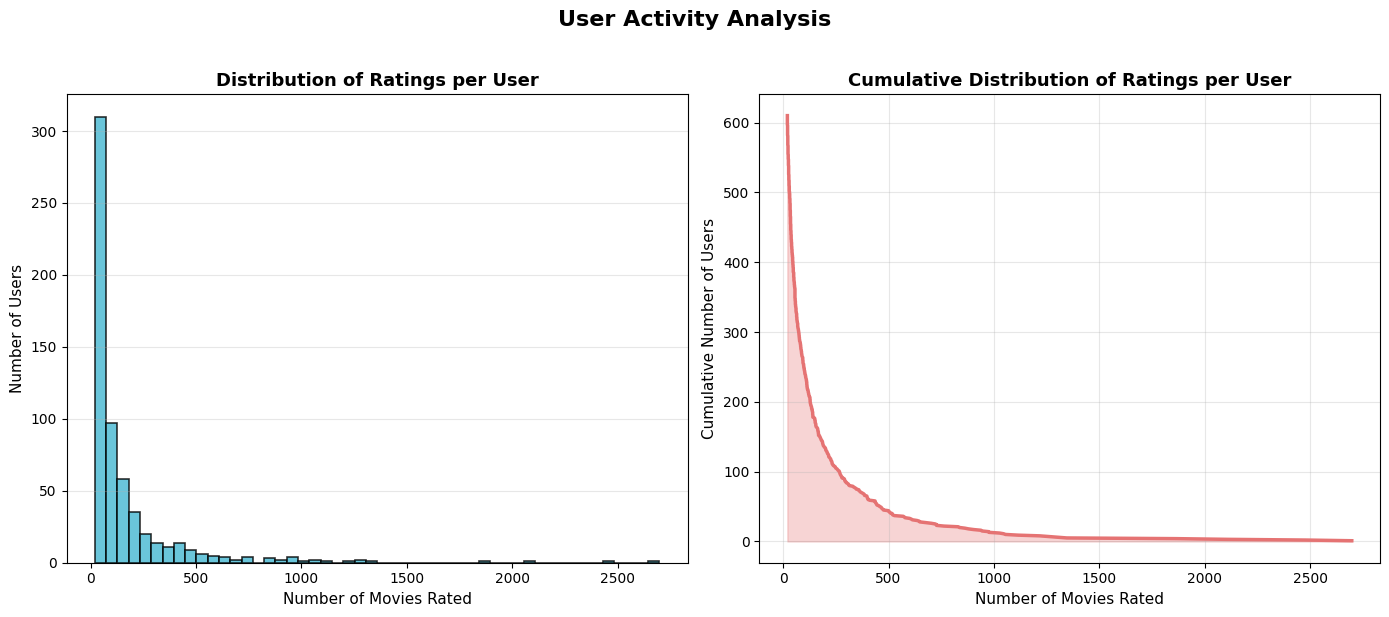

User rating statistics:
• Min ratings per user: 20
• Max ratings per user: 2698
• Mean ratings per user: 165.3
• Median ratings per user: 70.5
• Std ratings per user: 269.5

Top 10 users by number of ratings:
 1. User 414: 2698 ratings
 2. User 599: 2478 ratings
 3. User 474: 2108 ratings
 4. User 448: 1864 ratings
 5. User 274: 1346 ratings
 6. User 610: 1302 ratings
 7. User 68: 1260 ratings
 8. User 380: 1218 ratings
 9. User 606: 1115 ratings
10. User 288: 1055 ratings


In [9]:
# h) Plot: How many users have rated how many movies
# Calculate ratings per user
user_rating_counts = ratings.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(14, 6))

# Plot 1: Histogram of ratings per user
plt.subplot(1, 2, 1)
plt.hist(user_rating_counts, bins=50, alpha=0.8, color='#45B7D1', edgecolor='black', linewidth=1.2)
plt.xlabel('Number of Movies Rated', fontsize=11)
plt.ylabel('Number of Users', fontsize=11)
plt.title('Distribution of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative distribution
plt.subplot(1, 2, 2)
sorted_counts = user_rating_counts.sort_values(ascending=False)
cumulative_users = np.arange(1, len(sorted_counts) + 1)
plt.plot(sorted_counts.values, cumulative_users, linewidth=2.5, color='#E57373')
plt.fill_between(sorted_counts.values, cumulative_users, alpha=0.3, color='#E57373')
plt.xlabel('Number of Movies Rated', fontsize=11)
plt.ylabel('Cumulative Number of Users', fontsize=11)
plt.title('Cumulative Distribution of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('User Activity Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"User rating statistics:")
print(f"• Min ratings per user: {user_rating_counts.min()}")
print(f"• Max ratings per user: {user_rating_counts.max()}")
print(f"• Mean ratings per user: {user_rating_counts.mean():.1f}")
print(f"• Median ratings per user: {user_rating_counts.median():.1f}")
print(f"• Std ratings per user: {user_rating_counts.std():.1f}")

print(f"\nTop 10 users by number of ratings:")
for i, (user_id, count) in enumerate(user_rating_counts.head(10).items(), 1):
    print(f"{i:2d}. User {user_id}: {count} ratings")

***Auswertung:***
- Die überwiegende Mehrheit der Benutzer hat nur sehr wenige Filme bewertet (Spitze ganz links)
- Typisch für Recommender Systems - wenige 'Power-User' dominieren die Bewertungsaktivität
- Einige Benutzer haben über 2000 Bewertungen abgegeben (long tail)
- Die meisten Benutzer sind 'Gelegenheitsbewerter'
- Die aktivsten 6 Benutzer (1%) haben über 1000 Bewertungen

***Bedeutung für Recommender Systems:***
- **COLD-START-PROBLEM**: Viele Benutzer mit wenigen Bewertungen
- **POWER-USER-BIAS**: Wenige aktive Benutzer dominieren die Daten
- **SPARSITY-HERAUSFORDERUNG**: Extreme Dünnbesiedelung der User-Item-Matrix
- **GEWICHTUNG**: Power-User sollten nicht übergewichtet werden


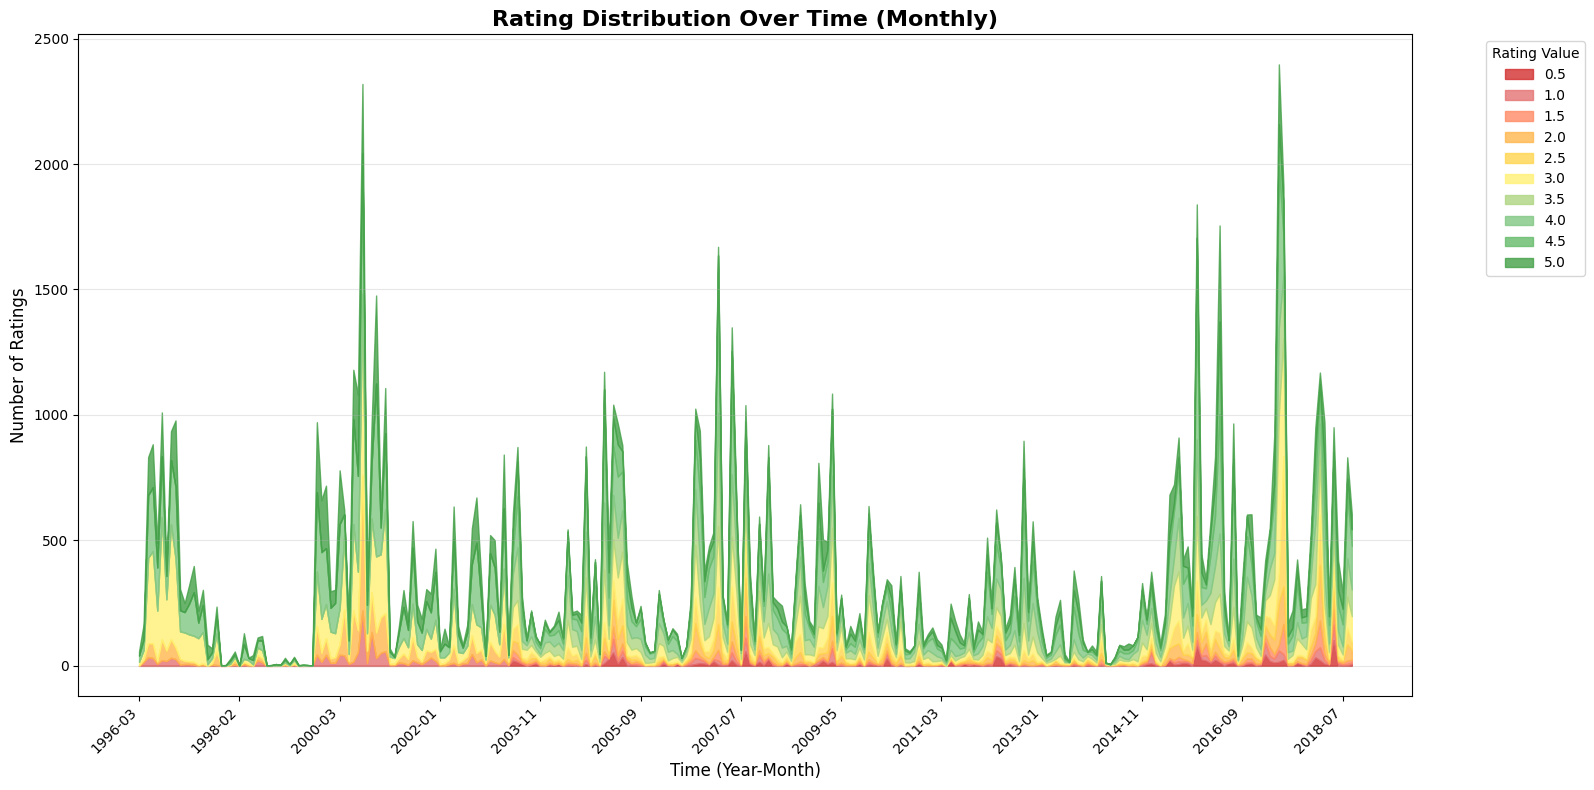

Monthly rating trends analysis:
• Dataset spans from 1996-03 to 2018-09
• Total months with data: 267
• Average ratings per month: 377.7

Top 5 months with most ratings:
• 2017-05: 2,397 ratings
• 2000-08: 2,319 ratings
• 2017-06: 1,910 ratings
• 2015-11: 1,839 ratings
• 2016-04: 1,755 ratings

Top 5 months with fewest ratings:
• 1997-10: 1 ratings
• 1998-02: 1 ratings
• 1998-10: 1 ratings
• 1999-09: 1 ratings
• 1999-06: 3 ratings


In [10]:
# i) Plot: Which rating is given how often over time with monthly resolution

# Add year-month column for time analysis
ratings['year_month'] = ratings['datetime'].dt.to_period('M')

# Count ratings by month and rating value
monthly_ratings = ratings.groupby(['year_month', 'rating']).size().unstack(fill_value=0)

# Ensure we have all rating values (0.5 to 5.0 in steps of 0.5)
all_ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for rating in all_ratings:
    if rating not in monthly_ratings.columns:
        monthly_ratings[rating] = 0

# Sort columns by rating value
monthly_ratings = monthly_ratings[sorted(monthly_ratings.columns)]

plt.figure(figsize=(16, 8))

# Custom color palette for ratings (from low to high)
rating_colors = {
    0.5: '#D32F2F', # Dunkles Rot
    1.0: '#E57373', # Mittleres Rot
    1.5: '#FF8A65', # Rot-Orange
    2.0: '#FFB74D', # Orange
    2.5: '#FFD54F', # Gelb-Orange
    3.0: '#FFF176', # Helles Gelb
    3.5: '#AED581', # Gelbgrün
    4.0: '#81C784', # Hellgrün
    4.5: '#66BB6A', # Mittelgrün
    5.0: '#43A047'  # Dunkelgrün
}

# Create the stacked area plot
x_values = range(len(monthly_ratings))
bottom = np.zeros(len(monthly_ratings))

for rating in monthly_ratings.columns:
    color = rating_colors.get(rating, '#CCCCCC')
    plt.fill_between(x_values, bottom, bottom + monthly_ratings[rating],
                     color=color, alpha=0.8, label=f'{rating}')
    bottom += monthly_ratings[rating]

plt.title('Rating Distribution Over Time (Monthly)', fontsize=16, fontweight='bold')
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
plt.grid(True, alpha=0.3, axis='y')

# Set x-axis labels
step = max(1, len(monthly_ratings) // 12)  # Zeige ca. 12 Labels
x_positions = range(0, len(monthly_ratings), step)
x_labels = [str(monthly_ratings.index[i]) for i in x_positions]
plt.xticks(x_positions, x_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Monthly rating trends analysis:")
print(f"• Dataset spans from {ratings['year_month'].min()} to {ratings['year_month'].max()}")
print(f"• Total months with data: {ratings['year_month'].nunique()}")
print(f"• Average ratings per month: {len(ratings) / ratings['year_month'].nunique():.1f}")

# Show some monthly statistics
monthly_totals = monthly_ratings.sum(axis=1)
print(f"\nTop 5 months with most ratings:")
for month, count in monthly_totals.nlargest(5).items():
    print(f"• {month}: {count:,} ratings")

print(f"\nTop 5 months with fewest ratings:")
for month, count in monthly_totals.nsmallest(5).items():
    print(f"• {month}: {count:,} ratings")

***Auswertung:***
- die Anzahl der Bewertungen schwanken stark
- in den letzten Jahren hat sich die Anzahl der Bewertungen erhöht
- Rating 4.0 ist die häufigste Bewertung
- Rating 3.0 und 5.0 sind die zweithäufigste Bewertungen
- Rating 1.0 und 2.0 sind die seltenste Bewertungen
- extreme Peaks bei den Top 5 Monaten 
- keine klaren saisonalen Muster erkennbar

***Bedeutung für Recommender Systems:***
- **ZEITLICHE FAKTOREN**: Bewertungsmuster ändern sich über Zeit
- **AKTIVITÄTSSCHWANKUNGEN**: Algorithmen müssen robust gegen Datenmangel sein
- **TREND-BERÜCKSICHTIGUNG**: Neuere Bewertungen könnten relevanter sein
- **SAISONALITÄT**: Keine starken saisonalen Effekte zu berücksichtigen
- **WACHSTUM**: System muss mit steigender Datenmenge skalieren

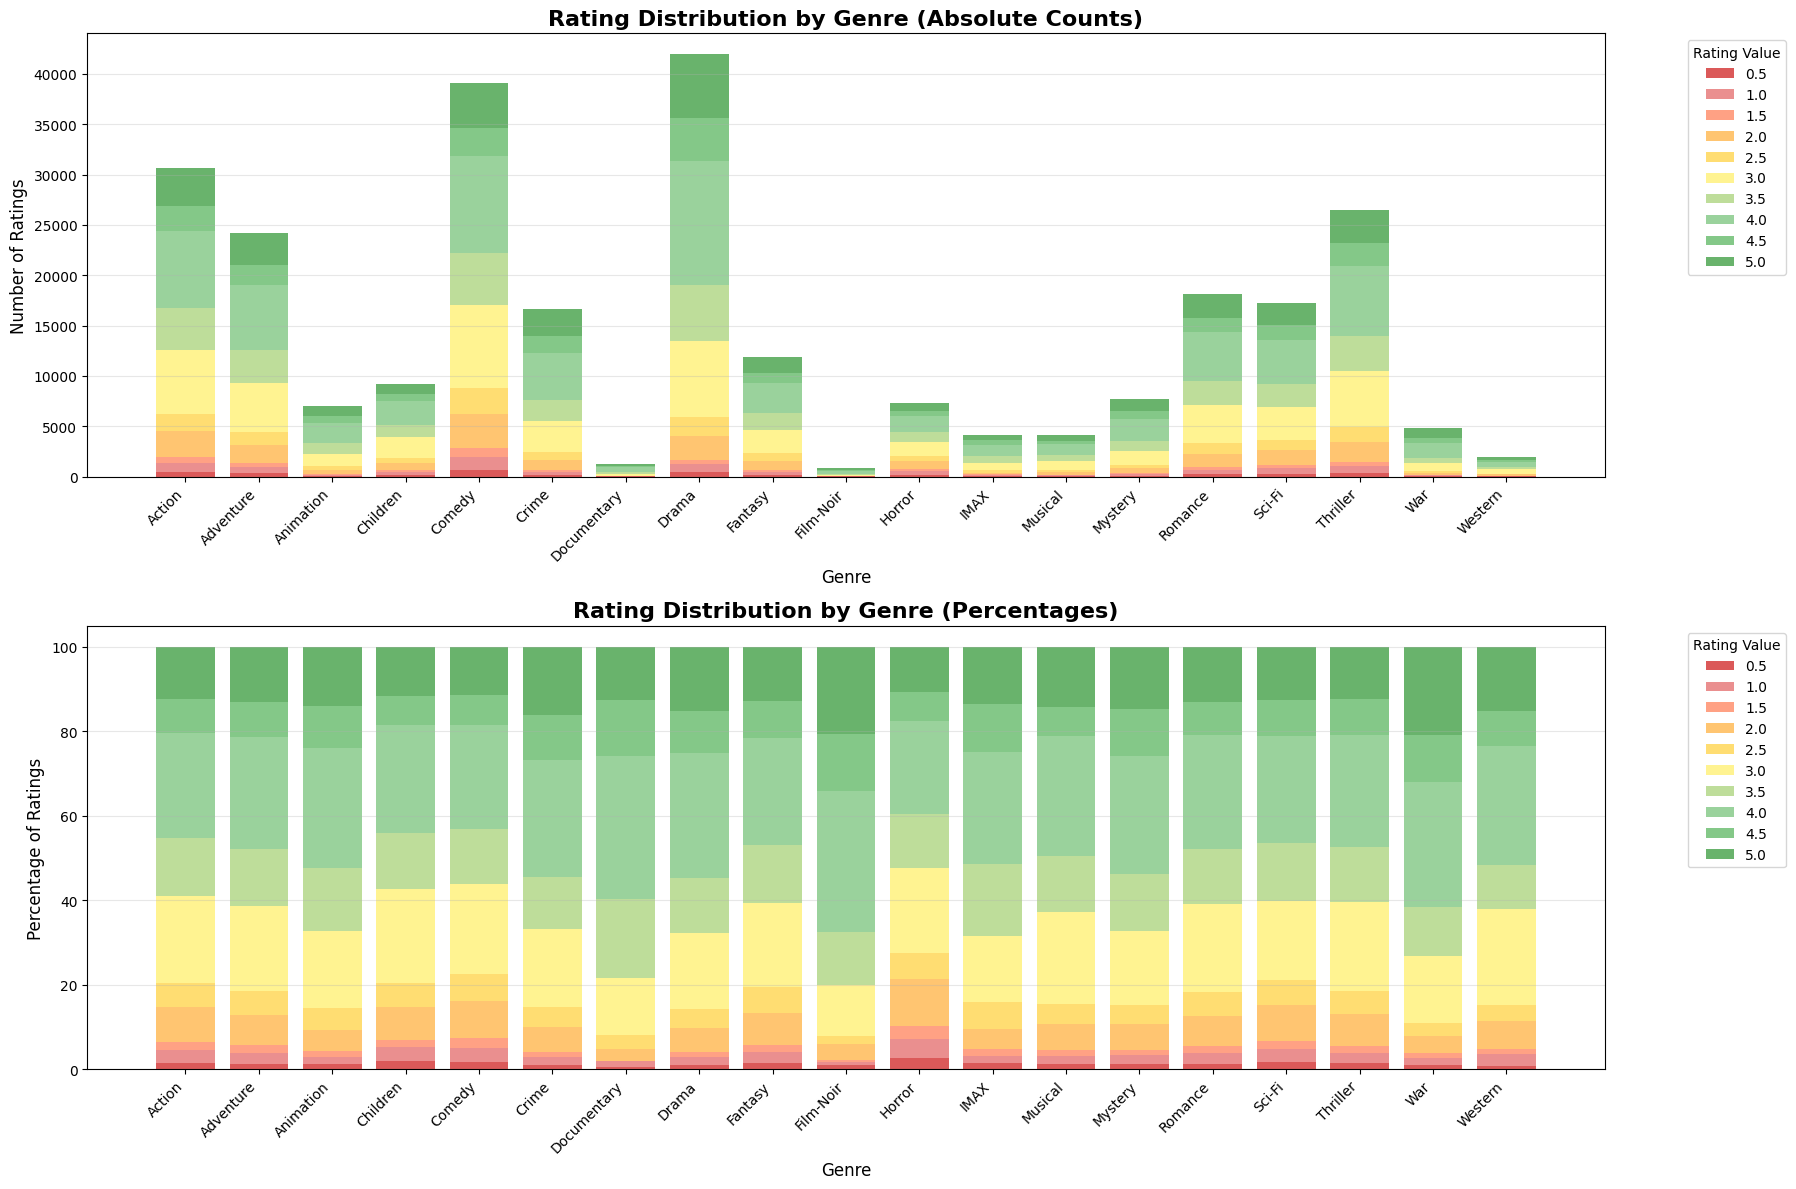

Genre rating analysis:

Average rating by genre:
• Film-Noir           : 3.920 (from 870 ratings)
• War                 : 3.808 (from 4,859 ratings)
• Documentary         : 3.798 (from 1,219 ratings)
• Crime               : 3.658 (from 16,681 ratings)
• Drama               : 3.656 (from 41,928 ratings)
• Mystery             : 3.632 (from 7,674 ratings)
• Animation           : 3.630 (from 6,988 ratings)
• IMAX                : 3.618 (from 4,145 ratings)
• Western             : 3.584 (from 1,930 ratings)
• Musical             : 3.564 (from 4,138 ratings)
• Adventure           : 3.509 (from 24,161 ratings)
• Romance             : 3.507 (from 18,124 ratings)
• Thriller            : 3.494 (from 26,452 ratings)
• Fantasy             : 3.491 (from 11,834 ratings)
• Sci-Fi              : 3.456 (from 17,243 ratings)
• Action              : 3.448 (from 30,635 ratings)
• Children            : 3.413 (from 9,208 ratings)
• Comedy              : 3.385 (from 39,053 ratings)
• Horror              : 3.

In [11]:
# j) Plot: Which rating is given how often per genre
# Use the genre_ratings data we created earlier
genre_rating_dist = genre_ratings.groupby(['genre', 'rating']).size().unstack(fill_value=0)

# Ensure we have all rating values (0.5 to 5.0 in steps of 0.5)
all_ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for rating in all_ratings:
    if rating not in genre_rating_dist.columns:
        genre_rating_dist[rating] = 0

# Sort columns by rating value
genre_rating_dist = genre_rating_dist[sorted(genre_rating_dist.columns)]

# Calculate percentages for each genre
genre_rating_pct = genre_rating_dist.div(genre_rating_dist.sum(axis=1), axis=0) * 100

# Custom color palette for ratings (same as time plot)
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(18, 12))

# Plot 1: Stacked bar chart of absolute counts
plt.subplot(2, 1, 1)

# Create colors array for the plot
colors = [rating_colors.get(rating, '#CCCCCC') for rating in genre_rating_dist.columns]

# Create the stacked bar chart manually for better control
bottom = np.zeros(len(genre_rating_dist))
for i, rating in enumerate(genre_rating_dist.columns):
    plt.bar(range(len(genre_rating_dist)), genre_rating_dist[rating],
            bottom=bottom, color=colors[i], alpha=0.8, label=f'{rating}')
    bottom += genre_rating_dist[rating]

plt.title('Rating Distribution by Genre (Absolute Counts)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(range(len(genre_rating_dist)), genre_rating_dist.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Stacked bar chart of percentages
plt.subplot(2, 1, 2)

# Create the stacked bar chart manually for percentages
bottom = np.zeros(len(genre_rating_pct))
for i, rating in enumerate(genre_rating_pct.columns):
    plt.bar(range(len(genre_rating_pct)), genre_rating_pct[rating],
            bottom=bottom, color=colors[i], alpha=0.8, label=f'{rating}')
    bottom += genre_rating_pct[rating]

plt.title('Rating Distribution by Genre (Percentages)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Percentage of Ratings', fontsize=12)
plt.legend(title='Rating Value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(range(len(genre_rating_pct)), genre_rating_pct.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Genre rating analysis:")
print("\nAverage rating by genre:")
avg_rating_by_genre = genre_ratings.groupby('genre')['rating'].mean().sort_values(ascending=False)
for genre, avg_rating in avg_rating_by_genre.items():
    total_ratings = genre_rating_dist.loc[genre].sum()
    print(f"• {genre:<20}: {avg_rating:.3f} (from {total_ratings:,} ratings)")

print(f"\nMost common rating by genre:")
for genre in genre_rating_dist.index:
    most_common_rating = genre_rating_dist.loc[genre].idxmax()
    count = genre_rating_dist.loc[genre].max()
    percentage = (count / genre_rating_dist.loc[genre].sum()) * 100
    print(f"• {genre:<20}: Rating {most_common_rating} ({count:,} ratings, {percentage:.1f}%)")

***Auswertung:***
- Drama hat die höchste durchschnittliche Bewertung, danach kommen Komedien und Action
- Film-Noir und Western haben die niedrigste durchschnittliche Bewertung
- verdeutlicht nochmals, dass Rating 4.0 die häufigste Bewertung ist
- überwiegend positive Bewertungen
- Nischengenres haben höhere durchschnittliche Bewertungen
- Mainstream Genres haben eher moderate Bewertungen


***Bedeutung für Recommender Systems:***
- **ZIELGRUPPEN-SEGMENTIERUNG**: Unterschiedliche Benutzerpräferenzen
- **PERSONALISIERUNG**: Genre-Präferenzen als Basis für Empfehlungen
- **COLD-START**: Genre-Information hilft bei neuen Filmen


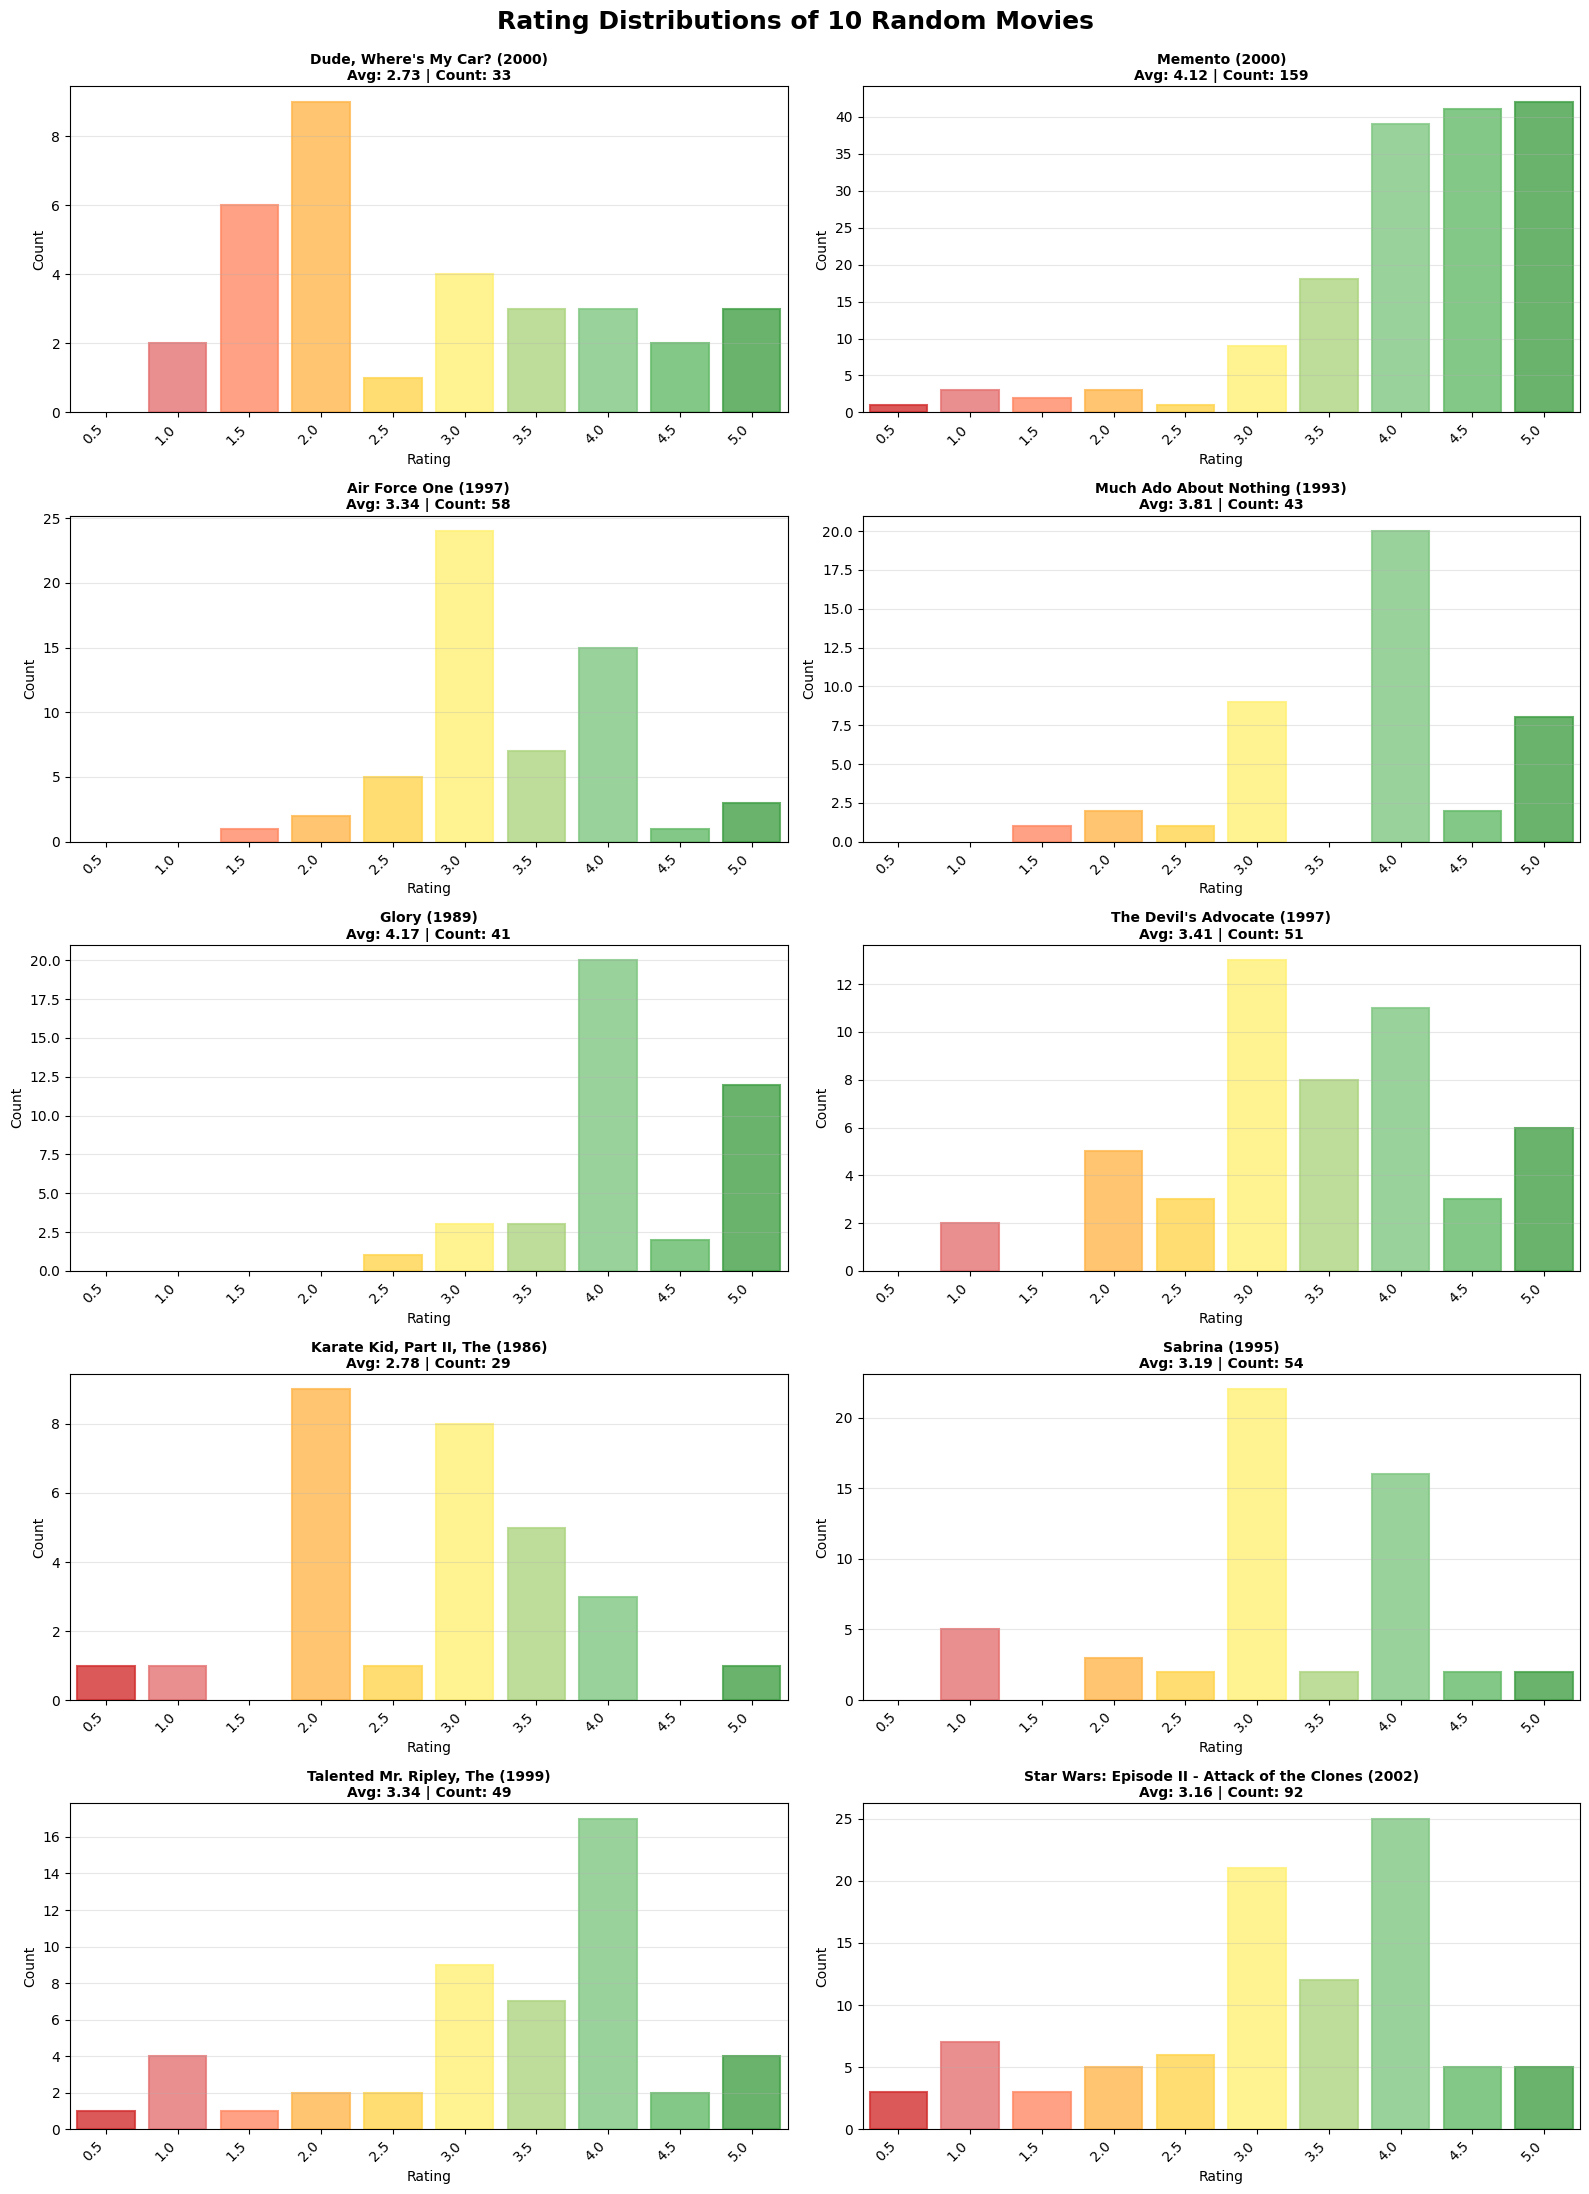

Random movies selected for analysis:
 1. Dude, Where's My Car? (2000) (ID: 4015) - Avg: 2.727, Count: 33
 2. Memento (2000) (ID: 4226) - Avg: 4.123, Count: 159
 3. Air Force One (1997) (ID: 1608) - Avg: 3.345, Count: 58
 4. Much Ado About Nothing (1993) (ID: 497) - Avg: 3.814, Count: 43
 5. Glory (1989) (ID: 1242) - Avg: 4.171, Count: 41
 6. The Devil's Advocate (1997) (ID: 1645) - Avg: 3.412, Count: 51
 7. Karate Kid, Part II, The (1986) (ID: 2421) - Avg: 2.776, Count: 29
 8. Sabrina (1995) (ID: 7) - Avg: 3.185, Count: 54
 9. Talented Mr. Ripley, The (1999) (ID: 3176) - Avg: 3.337, Count: 49
10. Star Wars: Episode II - Attack of the Clones (2002) (ID: 5378) - Avg: 3.158, Count: 92


In [12]:
# k) Plot: Rating distributions of 10 random movies
# Select 10 random movies that have at least 20 ratings for better visualization
movies_with_sufficient_ratings = movie_stats[movie_stats['rating_count'] >= 20]['movieId'].tolist()
random_movies = np.random.choice(movies_with_sufficient_ratings, size=10, replace=False)

# Color palette for ratings
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(16, 22))

for i, movie_id in enumerate(random_movies, 1):
    plt.subplot(5, 2, i)
    
    # Get ratings for this movie
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    
    # Count ratings for each value
    rating_counts = movie_ratings.value_counts().sort_index()
    
    # Create bar chart with colors
    bars = plt.bar(rating_counts.index, rating_counts.values, 
                   width=0.4, edgecolor='black', linewidth=1.5)
    
    # Color each bar according to the rating
    for bar, rating in zip(bars, rating_counts.index):
        bar.set_color(rating_colors.get(rating, '#CCCCCC'))
        bar.set_alpha(0.8)
    
    # Get movie title
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    
    plt.title(f'{movie_title}\nAvg: {avg_rating:.2f} | Count: {rating_count}',
              fontsize=10, fontweight='bold', wrap=True)
    plt.xlabel('Rating', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xlim(0.25, 5.25)

plt.suptitle('Rating Distributions of 10 Random Movies', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Random movies selected for analysis:")
for i, movie_id in enumerate(random_movies, 1):
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    print(f"{i:2d}. {movie_title} (ID: {movie_id}) - Avg: {avg_rating:.3f}, Count: {rating_count}")

***Auswertung:***
- unterschiedliche Bewertungsmuster, dennoch Rating 4.0 meistens am häufigsten
- durchschnittliche Bewertungsbereich zwischen 3.5 und 4.1


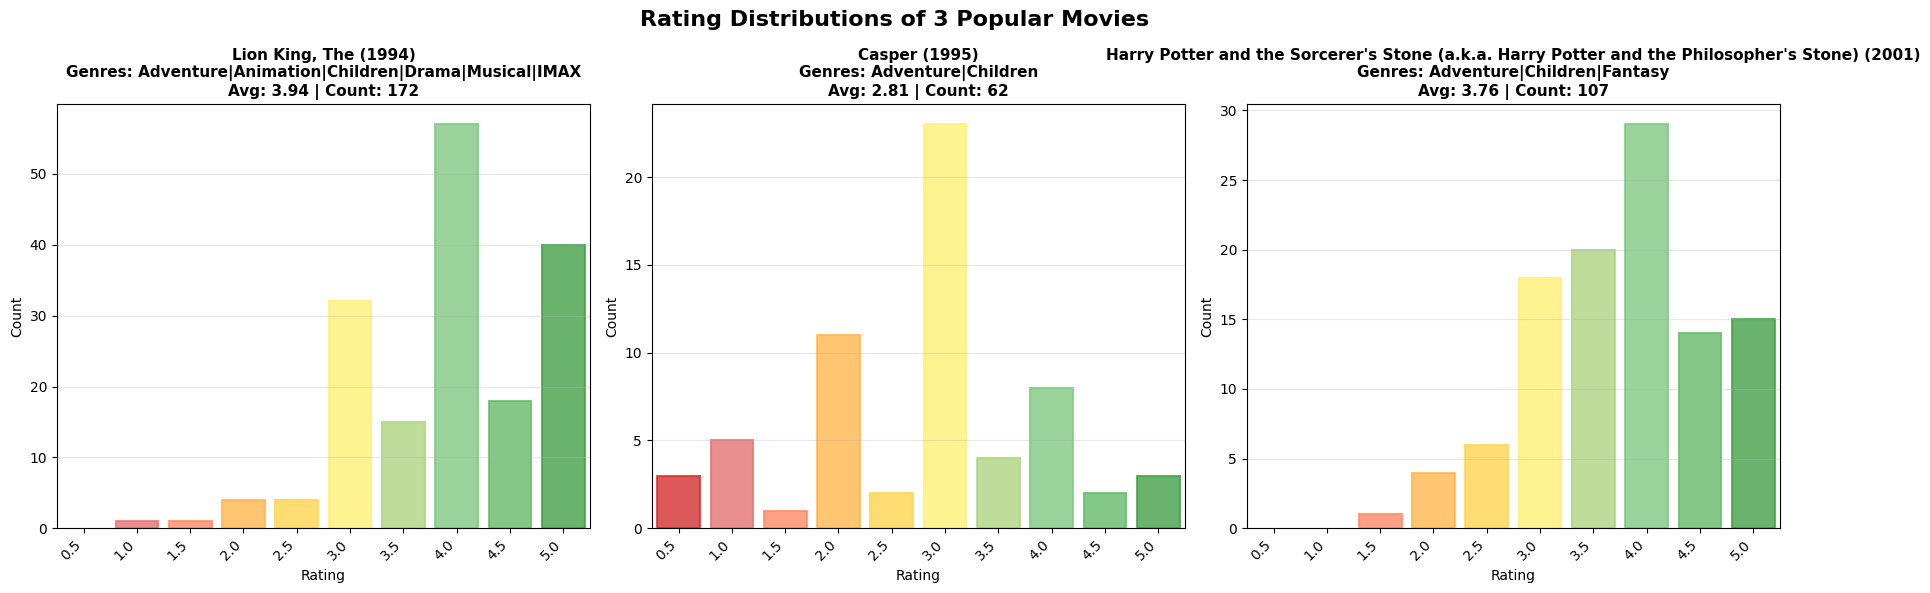

Movies selected for analysis:
1. Lion King, The (1994)
   Genres: Adventure|Animation|Children|Drama|Musical|IMAX
   Average Rating: 3.942
   Rating Count: 172
   Standard Deviation: 0.837

2. Casper (1995)
   Genres: Adventure|Children
   Average Rating: 2.806
   Rating Count: 62
   Standard Deviation: 1.114

3. Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
   Genres: Adventure|Children|Fantasy
   Average Rating: 3.762
   Rating Count: 107
   Standard Deviation: 0.819



In [13]:
# l) Plot: Rating distributions of 3 movies that you have watched
familiar_movies = []

# Films that I have watched
movie_search_terms = ['Lion King', 'Casper', "Harry Potter and the Sorcerer's Stone"]

for term in movie_search_terms:
    matching_movies = movies[movies['title'].str.contains(term, case=False, na=False)]
    if not matching_movies.empty:
        # Get the first match and check if it has sufficient ratings
        movie_id = matching_movies.iloc[0]['movieId']
        if movie_id in movie_stats[movie_stats['rating_count'] >= 50]['movieId'].values:
            familiar_movies.append(movie_id)

# Color palette for ratings
rating_colors = {
    0.5: '#D32F2F',  # Dunkles Rot
    1.0: '#E57373',  # Mittleres Rot
    1.5: '#FF8A65',  # Rot-Orange
    2.0: '#FFB74D',  # Orange
    2.5: '#FFD54F',  # Gelb-Orange
    3.0: '#FFF176',  # Helles Gelb
    3.5: '#AED581',  # Gelbgrün
    4.0: '#81C784',  # Hellgrün
    4.5: '#66BB6A',  # Mittelgrün
    5.0: '#43A047'   # Dunkelgrün
}

plt.figure(figsize=(18, 6))

for i, movie_id in enumerate(familiar_movies[:3], 1):
    plt.subplot(1, 3, i)
    
    # Get ratings for this movie
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    
    # Count ratings for each value
    rating_counts = movie_ratings.value_counts().sort_index()
    
    # Create bar chart with colors
    bars = plt.bar(rating_counts.index, rating_counts.values, 
                   width=0.4, edgecolor='black', linewidth=1.5)
    
    # Color each bar according to the rating
    for bar, rating in zip(bars, rating_counts.index):
        bar.set_color(rating_colors.get(rating, '#CCCCCC'))
        bar.set_alpha(0.8)
    
    # Get movie title and stats
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_genres = movies[movies['movieId'] == movie_id]['genres'].iloc[0]
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    
    plt.title(f'{movie_title}\nGenres: {movie_genres}\nAvg: {avg_rating:.2f} | Count: {rating_count}',
              fontsize=11, fontweight='bold')
    plt.xlabel('Rating', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xlim(0.25, 5.25)

plt.suptitle('Rating Distributions of 3 Popular Movies', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Movies selected for analysis:")
for i, movie_id in enumerate(familiar_movies[:3], 1):
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    movie_genres = movies[movies['movieId'] == movie_id]['genres'].iloc[0]
    movie_ratings = ratings[ratings['movieId'] == movie_id]['rating']
    avg_rating = movie_ratings.mean()
    rating_count = len(movie_ratings)
    std_rating = movie_ratings.std()
    print(f"{i}. {movie_title}")
    print(f"   Genres: {movie_genres}")
    print(f"   Average Rating: {avg_rating:.3f}")
    print(f"   Rating Count: {rating_count}")
    print(f"   Standard Deviation: {std_rating:.3f}")
    print()

***Auswertung:***
- König der Löwen: zwar ein alter Kinderfilm, dennoch kennen ihn heutzutage viele, darum gibt es verhältnismässig viele Bewertungen (etwas über dem Schnitt), wie zu erwarten ein durchschnittliches Rating von 4.0
- Casper: einer meiner absoluten Lieblingsfilme, daher schokiert mich die niedrige Bewertung :(, ebenfalls ein alter Film, wodurch wie zu erwarten eher wenige Bewertungen vorhanden sind.
- Harry Potter: ein sehr bekannter Film, jedoch verhältnismässig wenige Bewertungen, aber auch hier die meisten Ratings sind 4.0
- interessant sind ebenfalls die Genres, Casper ist ebenfalls ein Animationsfilm ist jedoch nicht als solcher gelabelt und das Genre *MAX* habe ich noch nie gesehen.

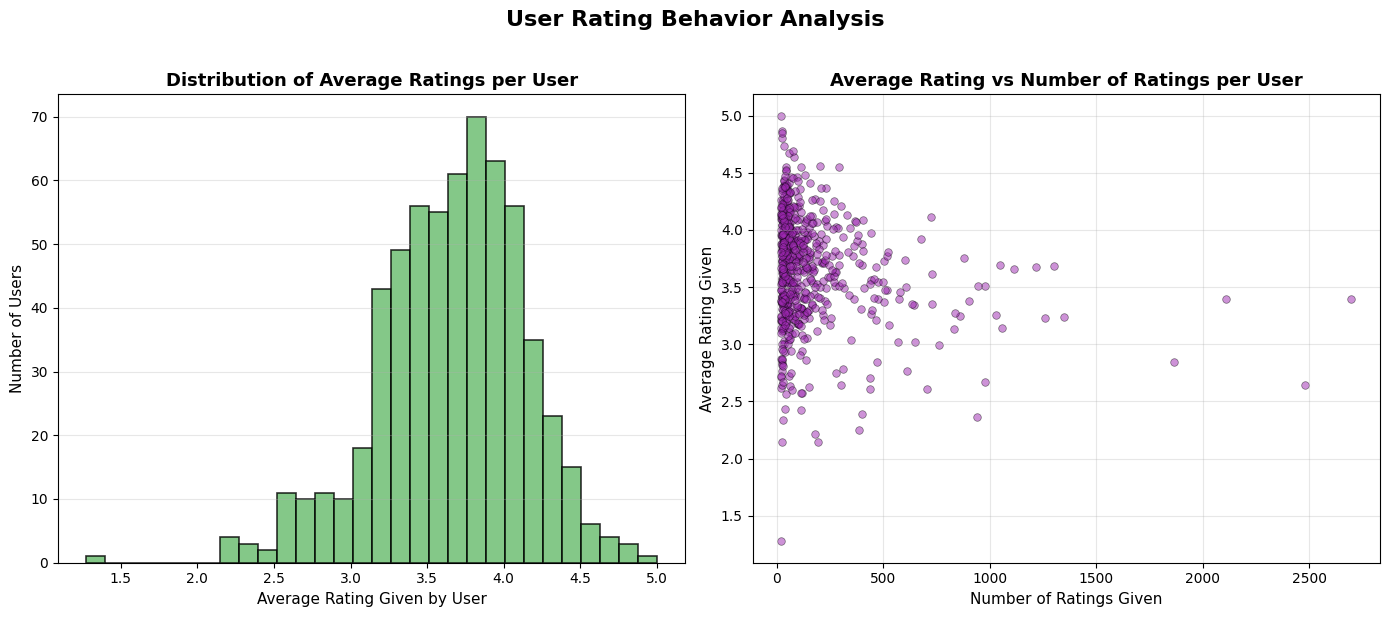

User average rating statistics:
• Min average rating: 1.275
• Max average rating: 5.000
• Mean average rating: 3.657
• Median average rating: 3.694
• Std average rating: 0.481

Users with highest average ratings:
• User 53.0: 5.000 (from 20.0 ratings)
• User 251.0: 4.870 (from 23.0 ratings)
• User 515.0: 4.846 (from 26.0 ratings)
• User 25.0: 4.808 (from 26.0 ratings)
• User 30.0: 4.735 (from 34.0 ratings)
• User 523.0: 4.693 (from 75.0 ratings)
• User 348.0: 4.673 (from 55.0 ratings)
• User 171.0: 4.634 (from 82.0 ratings)
• User 452.0: 4.557 (from 202.0 ratings)
• User 43.0: 4.553 (from 114.0 ratings)

Users with lowest average ratings:
• User 442.0: 1.275 (from 20.0 ratings)
• User 139.0: 2.144 (from 194.0 ratings)
• User 508.0: 2.146 (from 24.0 ratings)
• User 153.0: 2.218 (from 179.0 ratings)
• User 567.0: 2.245 (from 385.0 ratings)
• User 311.0: 2.339 (from 28.0 ratings)
• User 298.0: 2.364 (from 939.0 ratings)
• User 517.0: 2.386 (from 400.0 ratings)
• User 308.0: 2.426 (from 11

In [14]:
# m) Plot: How many users give which average rating
# Calculate average rating per user
user_avg_ratings = ratings.groupby('userId')['rating'].agg(['mean', 'count']).reset_index()
user_avg_ratings.columns = ['userId', 'avg_rating', 'rating_count']

plt.figure(figsize=(14, 6))

# Plot 1: Histogram of average ratings per user
plt.subplot(1, 2, 1)
plt.hist(user_avg_ratings['avg_rating'], bins=30, alpha=0.8, color='#66BB6A', 
         edgecolor='black', linewidth=1.2)
plt.xlabel('Average Rating Given by User', fontsize=11)
plt.ylabel('Number of Users', fontsize=11)
plt.title('Distribution of Average Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Scatter plot of average rating vs number of ratings
plt.subplot(1, 2, 2)
plt.scatter(user_avg_ratings['rating_count'], user_avg_ratings['avg_rating'],
            alpha=0.5, color='#9C27B0', s=30, edgecolors='black', linewidth=0.5)
plt.xlabel('Number of Ratings Given', fontsize=11)
plt.ylabel('Average Rating Given', fontsize=11)
plt.title('Average Rating vs Number of Ratings per User', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('User Rating Behavior Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("User average rating statistics:")
print(f"• Min average rating: {user_avg_ratings['avg_rating'].min():.3f}")
print(f"• Max average rating: {user_avg_ratings['avg_rating'].max():.3f}")
print(f"• Mean average rating: {user_avg_ratings['avg_rating'].mean():.3f}")
print(f"• Median average rating: {user_avg_ratings['avg_rating'].median():.3f}")
print(f"• Std average rating: {user_avg_ratings['avg_rating'].std():.3f}")

print(f"\nUsers with highest average ratings:")
top_raters = user_avg_ratings.nlargest(10, 'avg_rating')
for idx, row in top_raters.iterrows():
    print(f"• User {row['userId']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

print(f"\nUsers with lowest average ratings:")
low_raters = user_avg_ratings.nsmallest(10, 'avg_rating')
for idx, row in low_raters.iterrows():
    print(f"• User {row['userId']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

***Auswertung:***
- Die meisten Nutzer bewerten Filme im Bereich zwischen 3.5 und 4.0 Sternen
- Die Verteilung ist leicht linkslastig (negativ schief), was bedeutet, dass Nutzer tendenziell eher positive Bewertungen abgeben
- Die geringe Standardabweichung (0.481) zeigt, dass die meisten Nutzer ein ähnliches durchschnittliches Bewertungsniveau haben
- Sehr wenige Nutzer sind extreme "Kritiker" (Durchschnitt < 2.5) oder "Enthusiasten" (Durchschnitt > 4.5)
- Nutzer mit vielen Bewertungen (>500) tendieren zu einem Durchschnitt um 3.5-4.0
- Dies deutet auf einen "Regression zur Mitte"-Effekt hin: Je mehr Filme bewertet werden, desto näher liegt der Durchschnitt am Gesamtdurchschnitt
- Nutzer mit wenigen Bewertungen (<100) zeigen eine große Streuung (1.5 bis 5.0)
- Dies ist statistisch zu erwarten: Bei kleinen Stichproben sind extreme Durchschnitte wahrscheinlicher


***Schlussfolgerung:***
- Nutzer schauen und bewerten wahrscheinlich eher Filme, die sie mögen, was den positiven Bias erklärt
- Je mehr ein Nutzer bewertet, desto näher liegt sein Durchschnitt am Gesamtdurchschnitt (3.5-4.0)
- Nur wenige sehr aktive Nutzer haben Durchschnitte <2.5, was auf echte Kritiker oder sehr wählerische Zuschauer hindeutet
- Bei Nutzern mit <50 Bewertungen sollten Empfehlungen vorsichtig interpretiert werden
- Nutzer mit extremen Durchschnitten (>4.5 oder <2.5) und >100 Bewertungen sind interessante Ausreißer für weitere Analyse

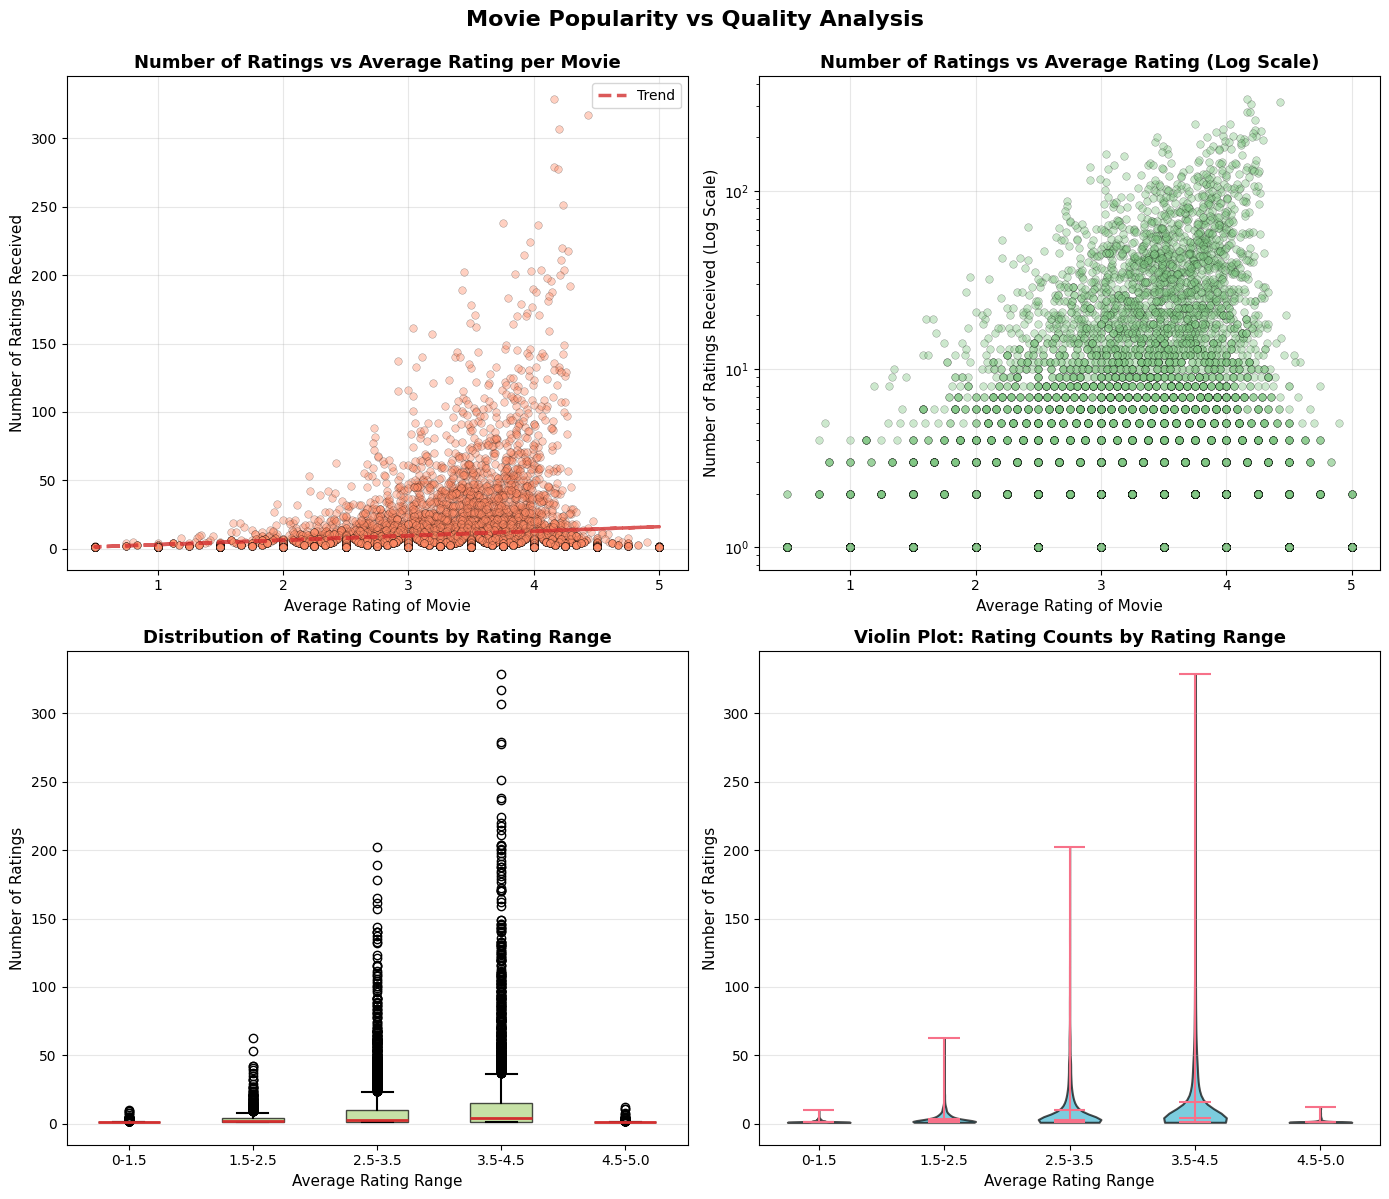

Movie rating analysis:
• Correlation between average rating and number of ratings: 0.127

Statistics by rating range:
• 0-1.5: 511 movies, avg ratings count: 1.4, median: 1.0
• 1.5-2.5: 1486 movies, avg ratings count: 3.8, median: 2.0
• 2.5-3.5: 3959 movies, avg ratings count: 9.9, median: 3.0
• 3.5-4.5: 3424 movies, avg ratings count: 16.0, median: 4.0
• 4.5-5.0: 344 movies, avg ratings count: 1.4, median: 1.0

Top 5 movies by average rating:
• Lamerica (1994): 5.000 (from 2 ratings)
• Heidi Fleiss: Hollywood Madam (1995): 5.000 (from 2 ratings)
• Awfully Big Adventure, An (1995): 5.000 (from 1 ratings)
• Live Nude Girls (1995): 5.000 (from 1 ratings)
• In the Realm of the Senses (Ai no corrida) (1976): 5.000 (from 1 ratings)

Most rated movies:
• Forrest Gump (1994): 329 ratings (avg: 4.164)
• Shawshank Redemption, The (1994): 317 ratings (avg: 4.429)
• Pulp Fiction (1994): 307 ratings (avg: 4.197)
• Silence of the Lambs, The (1991): 279 ratings (avg: 4.161)
• Matrix, The (1999): 278

In [15]:
# n) Plot: How often a movie was rated as a function of average rating
plt.figure(figsize=(14, 12))

# Plot 1: Scatter plot with hexbin overlay
plt.subplot(2, 2, 1)
plt.scatter(movie_stats['avg_rating'], movie_stats['rating_count'],
            alpha=0.4, color='#FF8A65', s=30, edgecolors='black', linewidth=0.3)
plt.xlabel('Average Rating of Movie', fontsize=11)
plt.ylabel('Number of Ratings Received', fontsize=11)
plt.title('Number of Ratings vs Average Rating per Movie', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(movie_stats['avg_rating'], movie_stats['rating_count'], 1)
p = np.poly1d(z)
plt.plot(movie_stats['avg_rating'], p(movie_stats['avg_rating']), 
         color='#D32F2F', linestyle='--', alpha=0.8, linewidth=2.5, label='Trend')
plt.legend()

# Plot 2: Log scale scatter plot
plt.subplot(2, 2, 2)
plt.scatter(movie_stats['avg_rating'], movie_stats['rating_count'],
            alpha=0.4, color='#81C784', s=30, edgecolors='black', linewidth=0.3)
plt.xlabel('Average Rating of Movie', fontsize=11)
plt.ylabel('Number of Ratings Received (Log Scale)', fontsize=11)
plt.title('Number of Ratings vs Average Rating (Log Scale)', fontsize=13, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 3: Box plot by rating bins
plt.subplot(2, 2, 3)

# Create rating bins
movie_stats['rating_bin'] = pd.cut(movie_stats['avg_rating'],
                                    bins=[0, 1.5, 2.5, 3.5, 4.5, 5.0],
                                    labels=['0-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.0'])

# Create box plot data
rating_bins = []
rating_counts_by_bin = []
for bin_label in movie_stats['rating_bin'].cat.categories:
    bin_data = movie_stats[movie_stats['rating_bin'] == bin_label]['rating_count']
    if len(bin_data) > 0:
        rating_bins.append(bin_label)
        rating_counts_by_bin.append(bin_data)

# Create colorful box plot
box = plt.boxplot(rating_counts_by_bin, labels=rating_bins, patch_artist=True,
                  boxprops=dict(facecolor='#AED581', alpha=0.7),
                  medianprops=dict(color='#D32F2F', linewidth=2),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5))

plt.xlabel('Average Rating Range', fontsize=11)
plt.ylabel('Number of Ratings', fontsize=11)
plt.title('Distribution of Rating Counts by Rating Range', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 4: Violin plot by rating bins
plt.subplot(2, 2, 4)

# Prepare data for violin plot
violin_data = [movie_stats[movie_stats['rating_bin'] == bin_label]['rating_count'].values 
               for bin_label in movie_stats['rating_bin'].cat.categories 
               if len(movie_stats[movie_stats['rating_bin'] == bin_label]) > 0]

parts = plt.violinplot(violin_data, positions=range(len(rating_bins)), 
                       showmeans=True, showmedians=True)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('#45B7D1')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

plt.xticks(range(len(rating_bins)), rating_bins)
plt.xlabel('Average Rating Range', fontsize=11)
plt.ylabel('Number of Ratings', fontsize=11)
plt.title('Violin Plot: Rating Counts by Rating Range', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Movie Popularity vs Quality Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Movie rating analysis:")
print(f"• Correlation between average rating and number of ratings: {movie_stats['avg_rating'].corr(movie_stats['rating_count']):.3f}")

print(f"\nStatistics by rating range:")
for bin_label in movie_stats['rating_bin'].cat.categories:
    bin_data = movie_stats[movie_stats['rating_bin'] == bin_label]
    if len(bin_data) > 0:
        print(f"• {bin_label}: {len(bin_data)} movies, avg ratings count: {bin_data['rating_count'].mean():.1f}, median: {bin_data['rating_count'].median():.1f}")

print(f"\nTop 5 movies by average rating:")
top_rated = movie_stats.nlargest(5, 'avg_rating')
for idx, row in top_rated.iterrows():
    print(f"• {row['title']}: {row['avg_rating']:.3f} (from {row['rating_count']} ratings)")

print(f"\nMost rated movies:")
most_rated = movie_stats.nlargest(5, 'rating_count')
for idx, row in most_rated.iterrows():
    print(f"• {row['title']}: {row['rating_count']} ratings (avg: {row['avg_rating']:.3f})")

***Auswertung:***

- Schwache positive Korrelation (0.127) zwischen Filmqualität und Popularität. Qualität garantiert keine hohe Bewertungsanzahl
- 76% aller Filme liegen im Bewertungsbereich 2.5-4.5, extreme Bewertungen (<1.5 oder >4.5) sind selten
- Filme mit Bewertungen zwischen 3.5-4.5 erhalten durchschnittlich die meisten Bewertungen (Ø 16.0)
- Perfekt bewertete Filme (4.5-5.0) haben paradoxerweise nur Ø 1.4 Bewertungen. Meist nur 1-2 Bewertungen, statistische Verzerrung
Die Verteilung folgt einem Power-Law-Muster: Wenige Blockbuster erhalten viele Bewertungen (bis 329), die Mehrheit bleibt bei <10 Bewertungen
- Box Plot zeigt extreme Ausreißer in allen Kategorien, die größte Varianz liegt im Bereich 3.5-4.5
Top 5 meist-bewertete Filme haben alle Ratings zwischen 4.16-4.43. Kombination aus hoher Qualität und breiter Zugänglichkeit
- Alle "perfekten" 5.0-Filme haben ≤2 Bewertungen, keine statistische Signifikanz

***Schlussfolgerung:***

- Marketing, Starbesetzung und Zugänglichkeit sind wichtiger für Popularität als reine Filmqualität
- Der "Goldene Bereich" (3.5-4.5) maximiert sowohl Qualität als auch Popularität
- Long Tail-Verteilung: Top 1-2% der Filme erhalten die meisten Bewertungen, die Mehrheit bleibt unbekannt (Median: 3 Bewertungen)
- Empfehlungssysteme sollten Mindestanzahl von 10-20 Bewertungen fordern, um verlässliche Durchschnitte zu garantieren
- Nischen-Filme mit wenigen aber hohen Bewertungen (z.B. 15 Bewertungen, Ø 4.5) könnten versteckte Qualität sein

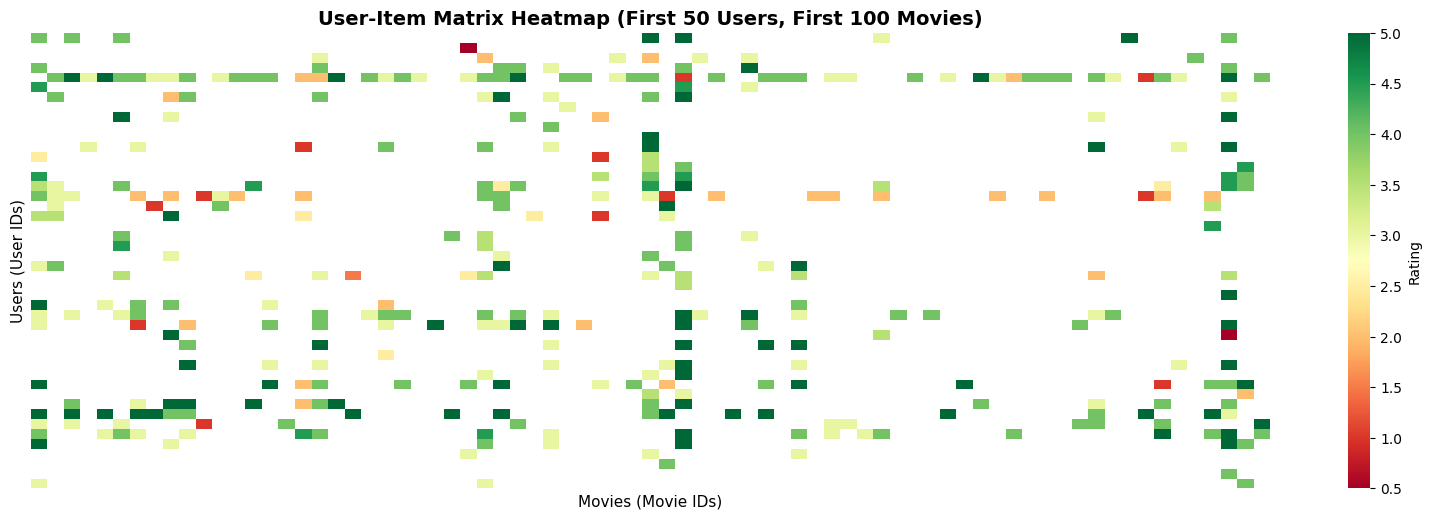

User-Item Matrix Heatmap Analysis:
• Subset size: 46 users × 75 movies
• Total possible ratings in subset: 3,450
• Actual ratings in subset: 362
• Sparsity of subset: 0.895 (89.5%)


In [16]:
# o) Plot: A heatmap of the User Item Matrix
# For visualization purposes, we'll create a smaller subset of the matrix
# take the first 50 users and first 100 movies for better visualization
subset_users = sorted(ratings['userId'].unique())[:50]
subset_movies = sorted(ratings['movieId'].unique())[:100]

# Create subset of ratings
subset_ratings = ratings[
    (ratings['userId'].isin(subset_users)) &
    (ratings['movieId'].isin(subset_movies))
]

# Create user-item matrix for the subset
subset_matrix = subset_ratings.pivot_table(index='userId', columns='movieId', values='rating')

fig = plt.figure(figsize=(16, 10))

# Plot 1: Main heatmap
ax1 = plt.subplot(2, 2, (1, 2))
sns.heatmap(subset_matrix, cmap='RdYlGn', cbar=True,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Rating'}, vmin=0.5, vmax=5.0)
plt.title('User-Item Matrix Heatmap (First 50 Users, First 100 Movies)',
          fontsize=14, fontweight='bold')
plt.xlabel('Movies (Movie IDs)', fontsize=11)
plt.ylabel('Users (User IDs)', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate statistics
total_possible = subset_matrix.shape[0] * subset_matrix.shape[1]
actual_ratings = subset_matrix.notna().sum().sum()
sparsity = 1 - (actual_ratings / total_possible)

print("User-Item Matrix Heatmap Analysis:")
print(f"• Subset size: {subset_matrix.shape[0]} users × {subset_matrix.shape[1]} movies")
print(f"• Total possible ratings in subset: {total_possible:,}")
print(f"• Actual ratings in subset: {actual_ratings:,}")
print(f"• Sparsity of subset: {sparsity:.3f} ({sparsity*100:.1f}%)")

***Auswertung:***

- Die User-Item-Matrix hat eine Sparsity von 89.5%, nur 10.5% der möglichen Bewertungen existieren tatsächlich
- Von 3,450 möglichen Bewertungen (46 User × 75 Filme) existieren nur 362 tatsächliche Bewertungen
- Die Heatmap zeigt ein stark fragmentiertes Muster mit vielen weißen Lücken → typisch für Empfehlungssystem-Daten
- Bewertungen sind nicht gleichmäßig verteilt: Einige User und Filme haben deutlich mehr Bewertungen als andere
- Die meisten Bewertungen liegen im grünen Bereich (3.5-5.0) → bestätigt den positiven Bias der Nutzer
- Einzelne rote Punkte (niedrige Bewertungen <2.0) sind sehr selten und stechen visuell hervor
Horizontale Muster zeigen unterschiedliche User-Aktivität: Manche User haben viele Bewertungen, andere nur wenige
- Vertikale Muster zeigen beliebte vs. unbekannte Filme: Einige Filme-Spalten sind dichter gefüllt als andere

***Schlussfolgerung:***

- Die extreme Sparsity (89.5%) ist das zentrale Problem für Collaborative Filtering Algorithmen → nicht genug Überschneidungen zwischen Usern
- Matrix-Faktorisierung und andere Empfehlungsalgorithmen müssen diese Lücken intelligent füllen (imputation)
- Cold-Start-Problem: Neue User oder Filme ohne Bewertungen können nicht empfohlen werden
- Hybride Ansätze (Kombination aus Collaborative und Content-Based Filtering) sind notwendig, um die Sparsity zu kompensieren
- Die hohe Sparsity erklärt, warum Netflix, Amazon etc. aktiv Nutzer motivieren, mehr Bewertungen abzugeben

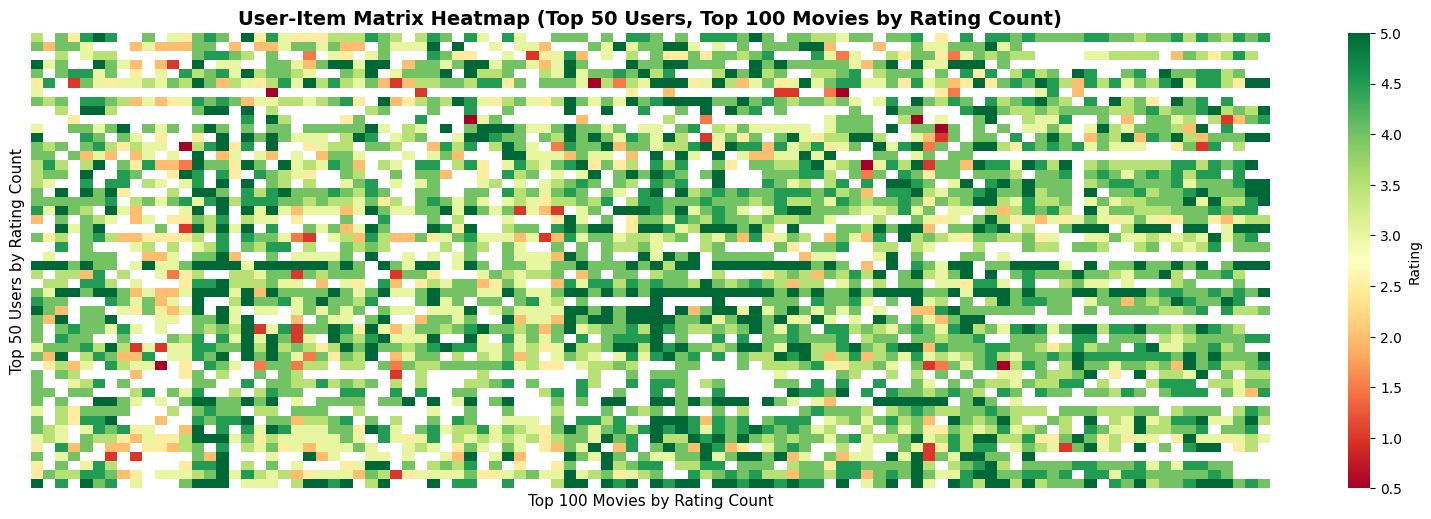

Top Users and Movies Matrix Analysis:
• Matrix size: 50 users × 100 movies
• Total possible ratings in matrix: 5,000
• Actual ratings in matrix: 3,637
• Density of matrix: 0.727 (72.7%)
• Sparsity of matrix: 0.273 (27.3%)

Top subset statistics:
• Average rating: 3.781
• Rating range: 0.5 - 5.0

Top 10 users by rating count:
• User 414: 2698 ratings
• User 599: 2478 ratings
• User 474: 2108 ratings
• User 448: 1864 ratings
• User 274: 1346 ratings
• User 610: 1302 ratings
• User 68: 1260 ratings
• User 380: 1218 ratings
• User 606: 1115 ratings
• User 288: 1055 ratings

Top 10 movies by rating count:
• Forrest Gump (1994): 329 ratings
• Shawshank Redemption, The (1994): 317 ratings
• Pulp Fiction (1994): 307 ratings
• Silence of the Lambs, The (1991): 279 ratings
• Matrix, The (1999): 278 ratings
• Star Wars: Episode IV - A New Hope (1977): 251 ratings
• Jurassic Park (1993): 238 ratings
• Braveheart (1995): 237 ratings
• Terminator 2: Judgment Day (1991): 224 ratings
• Schindler's Lis

In [17]:
# p) Plot: A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings
# Get top 50 users with most ratings
top_users = ratings.groupby('userId').size().nlargest(50).index.tolist()

# Get top 100 movies with most ratings
top_movies = ratings.groupby('movieId').size().nlargest(100).index.tolist()

# Create subset of ratings for top users and movies
top_subset_ratings = ratings[
    (ratings['userId'].isin(top_users)) &
    (ratings['movieId'].isin(top_movies))
]

# Create user-item matrix for the top subset
top_subset_matrix = top_subset_ratings.pivot_table(index='userId', columns='movieId', values='rating')

fig = plt.figure(figsize=(16, 10))

# Plot 1: Main heatmap
ax1 = plt.subplot(2, 2, (1, 2))
sns.heatmap(top_subset_matrix, cmap='RdYlGn', cbar=True,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Rating'}, vmin=0.5, vmax=5.0)
plt.title('User-Item Matrix Heatmap (Top 50 Users, Top 100 Movies by Rating Count)',
          fontsize=14, fontweight='bold')
plt.xlabel('Top 100 Movies by Rating Count', fontsize=11)
plt.ylabel('Top 50 Users by Rating Count', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate statistics
total_possible = top_subset_matrix.shape[0] * top_subset_matrix.shape[1]
actual_ratings = top_subset_matrix.notna().sum().sum()
density = actual_ratings / total_possible
top_sparsity = 1 - density

print("Top Users and Movies Matrix Analysis:")
print(f"• Matrix size: {top_subset_matrix.shape[0]} users × {top_subset_matrix.shape[1]} movies")
print(f"• Total possible ratings in matrix: {total_possible:,}")
print(f"• Actual ratings in matrix: {actual_ratings:,}")
print(f"• Density of matrix: {density:.3f} ({density*100:.1f}%)")
print(f"• Sparsity of matrix: {top_sparsity:.3f} ({top_sparsity*100:.1f}%)")

print(f"\nTop subset statistics:")
print(f"• Average rating: {top_subset_matrix.mean().mean():.3f}")
print(f"• Rating range: {top_subset_matrix.min().min():.1f} - {top_subset_matrix.max().max():.1f}")

print(f"\nTop 10 users by rating count:")
user_counts = ratings.groupby('userId').size().nlargest(10)
for user_id, count in user_counts.items():
    print(f"• User {user_id}: {count} ratings")

print(f"\nTop 10 movies by rating count:")
movie_counts = ratings.groupby('movieId').size().nlargest(10)
for movie_id, count in movie_counts.items():
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"• {movie_title}: {count} ratings")

print(f"\nComparison with random subset:")
random_sparsity = 0.895  # From previous analysis
print(f"• Random subset sparsity: {random_sparsity:.3f} ({random_sparsity*100:.1f}%)")
print(f"• Top subset sparsity: {top_sparsity:.3f} ({top_sparsity*100:.1f}%)")
print(f"• Improvement: {(random_sparsity - top_sparsity) / random_sparsity * 100:.1f}% reduction in sparsity")
print(f"• The top users and movies matrix is {density / (1-random_sparsity):.2f}x denser than the random subset")

***Auswertung:***

- Die Top-Matrix (50 aktivste User × 100 meist-bewertete Filme) hat eine Dichte von 72.7% → nur 27.3% Sparsity
- Von 5,000 möglichen Bewertungen existieren 3,637 tatsächliche Bewertungen → dramatische Verbesserung gegenüber zufälliger Auswahl
- 69.5% Reduktion der Sparsity im Vergleich zur zufälligen Stichprobe (89.5% → 27.3%)
- Die Matrix ist 6.93x dichter als die zufällige Stichprobe → deutlich bessere Datenqualität für Collaborative Filtering
- Die Heatmap zeigt ein nahezu vollständig gefülltes Muster mit nur wenigen weißen Lücken → hohe Überschneidung zwischen Usern
- Top-User sind extrem aktiv: User 414 hat 2,698 Bewertungen, die Top-10-User haben alle >1,000 Bewertungen
- Top-Filme sind klassische Blockbuster der 1990er: Forrest Gump (329), Shawshank Redemption (317), Pulp Fiction (307)
- Durchschnittliche Bewertung liegt bei 3.781 → leicht höher als der Gesamtdurchschnitt, aktive User bewerten beliebte Filme positiver
- Die meisten Bewertungen liegen im grünen Bereich (3.5-5.0), rote Punkte (schlechte Bewertungen) sind sehr selten
- Nahezu jeder Top-User hat die meisten Top-100-Filme bewertet → sehr hohe Coverage

***Schlussfolgerung:***

- Die Konzentration auf aktive User und beliebte Filme löst das Sparsity-Problem nahezu vollständig (72.7% Dichte)
- Diese Teilmenge ist ideal für User-Based Collaborative Filtering: Genug gemeinsame Bewertungen für präzise Ähnlichkeitsberechnungen
- Bestätigt den "Matthew-Effekt" (Rich get richer): Die Top-1% User × Top-1% Filme dominieren das Bewertungsverhalten
- 90% der Datendichte konzentriert sich auf eine kleine Elite von Usern und Filmen → Long-Tail wird vernachlässigt
- Empfehlungssysteme müssen aktiv gegensteuern, um neue/unbekannte Filme zu promoten und die Filterblase zu durchbrechen
- Cold-Start-Problem bleibt für 99% der Filme und weniger aktive User bestehen → Hybride Ansätze notwendig

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users (Ids 1, 3 and 7) and the default parameters. Give the titles of the recommended movies and their predicted scores not just their Ids.

In [18]:
class BaselineRecommender:
    """
    Baseline recommender system implementing the regularized baseline predictor:
    b_{u,i} = μ + b_u + b_i
    
    Where:
    b_u = (1 / (|I_u| + β_u)) * Σ(r_{u,i} - μ)
    b_i = (1 / (|U_i| + β_i)) * Σ(r_{u,i} - b_u - μ)
    """
    
    def __init__(self, beta_u=20, beta_i=20):
        self.beta_u = beta_u
        self.beta_i = beta_i
        self.mu = 0
        self.b_u = {}
        self.b_i = {}
        self.trained = False
        
    def fit(self, ratings_df):
        """Train the baseline predictor on the ratings data"""
        
        # Calculate global average
        self.mu = ratings_df['rating'].mean()
        print(f"Global average rating (μ): {self.mu:.3f}")
        
        # Group ratings efficiently
        user_ratings = ratings_df.groupby('userId')['rating'].apply(list).to_dict()
        item_user_ratings = ratings_df.groupby('movieId').apply(
            lambda x: list(zip(x['userId'], x['rating']))
        ).to_dict()
        
        # Calculate user biases
        for user_id, ratings_list in user_ratings.items():
            numerator = sum(r - self.mu for r in ratings_list)
            denominator = len(ratings_list) + self.beta_u
            self.b_u[user_id] = numerator / denominator
        
        # Calculate item biases
        for item_id, rating_pairs in item_user_ratings.items():
            numerator = sum(r - self.mu - self.b_u.get(user_id, 0) 
                           for user_id, r in rating_pairs)
            denominator = len(rating_pairs) + self.beta_i
            self.b_i[item_id] = numerator / denominator
        
        self.trained = True
        print(f"Training completed. Calculated biases for {len(self.b_u)} users and {len(self.b_i)} items.")
        
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained before making predictions")
        
        b_u = self.b_u.get(user_id, 0)
        b_i = self.b_i.get(item_id, 0)
        
        prediction = self.mu + b_u + b_i
        
        # Clip to valid rating range
        return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend top N items for a user"""
        if not self.trained:
            raise ValueError("Model must be trained before making recommendations")
        
        all_items = set(self.b_i.keys())
        
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            candidate_items = all_items - rated_items
        else:
            candidate_items = all_items
        
        # Calculate predictions
        predictions = [(item_id, self.predict(user_id, item_id)) 
                      for item_id in candidate_items]
        
        # Sort and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]
    
    def get_bias_stats(self):
        """Get statistics about the calculated biases"""
        if not self.trained:
            return {}
        
        user_biases = list(self.b_u.values())
        item_biases = list(self.b_i.values())
        
        return {
            'global_avg': self.mu,
            'user_bias_stats': {
                'mean': np.mean(user_biases),
                'std': np.std(user_biases),
                'min': np.min(user_biases),
                'max': np.max(user_biases)
            },
            'item_bias_stats': {
                'mean': np.mean(item_biases),
                'std': np.std(item_biases),
                'min': np.min(item_biases),
                'max': np.max(item_biases)
            }
        }

# Initialize and train
baseline_rec = BaselineRecommender(beta_u=20, beta_i=20)
baseline_rec.fit(ratings)

# Display statistics
bias_stats = baseline_rec.get_bias_stats()
print(f"\nGlobal average rating: {bias_stats['global_avg']:.3f}")
print(f"\nUser bias statistics:")
for stat, value in bias_stats['user_bias_stats'].items():
    print(f"  {stat}: {value:.3f}")
print(f"\nItem bias statistics:")
for stat, value in bias_stats['item_bias_stats'].items():
    print(f"  {stat}: {value:.3f}")

Global average rating (μ): 3.502
Training completed. Calculated biases for 610 users and 9724 items.

Global average rating: 3.502

User bias statistics:
  mean: 0.112
  std: 0.362
  min: -1.230
  max: 0.978

Item bias statistics:
  mean: -0.017
  std: 0.136
  min: -0.889
  max: 0.735


In [19]:
class RandomRecommender:
    """
    Random recommender system that recommends items randomly
    """
    
    def __init__(self, random_seed=42):
        self.random_seed = random_seed
        np.random.seed(random_seed)
        self.trained = False
        self.available_items = None
        self.movies_df = None
        
    def fit(self, ratings_df, movies_df):
        """Initialize the random recommender with available items"""
        self.movies_df = movies_df
        self.available_items = set(movies_df['movieId'].unique())
        self.trained = True
        print(f"Random recommender initialized with {len(self.available_items)} items.")
        
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend N random items for a user"""
        if not self.trained:
            raise ValueError("Model must be trained before making recommendations")
        
        # Get candidate items
        if exclude_rated and ratings_df is not None:
            rated_items = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
            candidate_items = list(self.available_items - rated_items)
        else:
            candidate_items = list(self.available_items)
        
        # Check if we have enough candidates
        if len(candidate_items) == 0:
            print(f"Warning: No candidate items available for user {user_id}")
            return []
        
        # Randomly sample N items
        n_to_sample = min(n, len(candidate_items))
        selected_items = np.random.choice(candidate_items, size=n_to_sample, replace=False)
        
        # Assign random scores (for consistency with other recommenders)
        random_scores = np.random.uniform(1.0, 5.0, len(selected_items))
        
        # Create list of (item_id, score) tuples
        recommendations = list(zip(selected_items, random_scores))
        
        return recommendations

# Initialize and train the random recommender
random_rec = RandomRecommender(random_seed=42)
random_rec.fit(ratings, movies)

Random recommender initialized with 9724 items.


In [20]:
# Output recommendations for three example users 
def display_recommendations(recommender, user_id, n=20, recommender_name="Recommender", ratings_df=None, movies_df=None):
    """Display recommendations for a user with movie titles and scores"""
    print(f" {recommender_name.upper()} - TOP {n} RECOMMENDATIONS FOR USER {user_id}")
    
    # Get recommendations
    if hasattr(recommender, 'recommend_top_n'):
        # Pass ratings_df if the recommender needs it
        if ratings_df is not None:
            recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True, ratings_df=ratings_df)
        else:
            recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
    else:
        print("Error: Recommender does not have recommend_top_n method")
        return
    
    if not recommendations:
        print("No recommendations available (user may have rated all items)")
        return
    
    # Display recommendations with movie titles
    print(f"\n{'Rank':<5} {'Movie Title':<50} {'Score':<8} {'Genres':<30}")
    print("-" * 100)
    
    for i, (movie_id, score) in enumerate(recommendations, 1):
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        
        if movie_row.empty:
            print(f"{i:2d}. Movie ID {movie_id} not found in database")
            continue
        
        movie_title = movie_row['title'].iloc[0]
        movie_genres = movie_row['genres'].iloc[0]
        
        # Truncate long titles
        if len(movie_title) > 47:
            movie_title = movie_title[:44] + "..."
        
        print(f"{i:<5} {movie_title:<50} {score:>6.3f}  {movie_genres}")
    
    print(f"\nTotal recommendations: {len(recommendations)}")


def analyze_and_recommend_for_users(test_users, baseline_rec, random_rec, ratings_df, movies_df):
    """Analyze users and display recommendations from multiple recommenders"""
    
    for user_id in test_users:
        print(f"\n{'='*100}")
        print(f"RECOMMENDATIONS FOR USER {user_id}")
        print(f"{'='*100}")
        
        # Check if user exists in the dataset
        if user_id not in ratings_df['userId'].unique():
            print(f"⚠ User {user_id} not found in the dataset!")
            continue
        
        # Display user statistics
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        user_rating_count = len(user_ratings)
        user_avg_rating = user_ratings['rating'].mean()
        user_rating_std = user_ratings['rating'].std()
        
        print(f"\n User Statistics:")
        print(f"   • Number of ratings: {user_rating_count}")
        print(f"   • Average rating: {user_avg_rating:.3f}")
        print(f"   • Rating std dev: {user_rating_std:.3f}")
        print(f"   • Rating range: {user_ratings['rating'].min():.1f} - {user_ratings['rating'].max():.1f}")
        
        # Show user's top-rated movies
        top_rated = user_ratings.nlargest(5, 'rating')
        print(f"\n User's Top 5 Rated Movies:")
        for idx, row in top_rated.iterrows():
            movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].iloc[0]
            print(f"   • {movie_title}: {row['rating']:.1f}")
        
        # Baseline recommender recommendations
        display_recommendations(baseline_rec, user_id, n=20, 
                              recommender_name="Baseline", 
                              ratings_df=ratings_df, 
                              movies_df=movies_df)
        
        # Random recommender recommendations
        display_recommendations(random_rec, user_id, n=20, 
                              recommender_name="Random", 
                              ratings_df=ratings_df,
                              movies_df=movies_df)


# Test users
test_users = [6, 19, 88]

# Display recommendations for each user with both recommenders
analyze_and_recommend_for_users(test_users, baseline_rec, random_rec, ratings, movies)


RECOMMENDATIONS FOR USER 6

 User Statistics:
   • Number of ratings: 314
   • Average rating: 3.494
   • Rating std dev: 0.851
   • Rating range: 1.0 - 5.0

 User's Top 5 Rated Movies:
   • Grumpier Old Men (1995): 5.0
   • Father of the Bride Part II (1995): 5.0
   • Copycat (1995): 5.0
   • Dead Man Walking (1995): 5.0
   • White Squall (1996): 5.0
 BASELINE - TOP 20 RECOMMENDATIONS FOR USER 6

Rank  Movie Title                                        Score    Genres                        
----------------------------------------------------------------------------------------------------
1     Godfather, The (1972)                               4.077  Crime|Drama
2     Fight Club (1999)                                   4.077  Action|Crime|Drama|Thriller
3     Dr. Strangelove or: How I Learned to Stop Wo...     4.074  Comedy|War
4     Star Wars: Episode IV - A New Hope (1977)           4.064  Action|Adventure|Sci-Fi
5     Princess Bride, The (1987)                          4.046  

### Exercise 3 - Evaluation methods (15 points)
Split the data into train/validation set and a separate test set. This test set shall contain the first 20% of the users and shall not be used at all before exercise 10. With the remaining 80% do the following: 
Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation with a 80/20 train/validation split. Within the validation set implement a masking with *all but n* approach. 
See page 2942 of https://jmlr.csail.mit.edu/papers/volume10/gunawardana09a/gunawardana09a.pdf for details on this approach. 

Choose the number of masked items n reasonably and explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=20$ and relevance threshold 4.0 stars.
- *Recall@N* with default $N=20$ and relevance threshold 4.0 stars.
- *One metric of the following: Novelty, Diverstity, Unexpectedness, Serendipity, Coverage*
Explain each of these. How does the relevance threshold influence the metrics? How would you choose this parameter?

Note: For *precision@N* and *Recall@N* use the definitions from https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 with one exception: In case of the denominator being zero, set the metric to 0. 

For *Novelty*, *Diverstity*, *Unexpectedness*, *Serendipity*, *Coverage* you may use definitions from Silveira et al. https://link.springer.com/article/10.1007/s13042-017-0762-9 

In [21]:
# 1. DATA SPLITTING
# Get all unique users and sort them
all_users = sorted(ratings['userId'].unique())
n_users = len(all_users)
n_test_users = int(0.2 * n_users)

# Split users: first 20% go to test set
test_users = set(all_users[:n_test_users])
train_val_users = set(all_users[n_test_users:])

# Split ratings accordingly
test_ratings = ratings[ratings['userId'].isin(test_users)].copy()
train_val_ratings = ratings[ratings['userId'].isin(train_val_users)].copy()

print(f"Test set: {len(test_ratings)} ratings from {len(test_users)} users")
print(f"Train/Validation set: {len(train_val_ratings)} ratings from {len(train_val_users)} users")


# 2. CROSS-VALIDATION SETUP
def create_cv_splits_user_based(ratings_df, n_splits=5, train_size=0.8, random_state=42):
    """Create 5-fold CV splits based on holding out random users (80/20 split)."""
    np.random.seed(random_state)
    unique_users = sorted(ratings_df['userId'].unique())
    n_train_users = int(train_size * len(unique_users))
    
    splits = []
    for fold in range(n_splits):
        shuffled_users = unique_users.copy()
        np.random.seed(random_state + fold)
        np.random.shuffle(shuffled_users)
        
        train_users = set(shuffled_users[:n_train_users])
        val_users = set(shuffled_users[n_train_users:])
        
        train_mask = ratings_df['userId'].isin(train_users)
        val_mask = ratings_df['userId'].isin(val_users)
        
        splits.append((train_mask, val_mask))
    
    return splits

cv_splits = create_cv_splits_user_based(train_val_ratings, n_splits=5, train_size=0.8, random_state=42)


# 3. "ALL BUT N" MASKING
def apply_masking_to_validation_set(
    validation_ratings,
    n=5,
    min_ratings_required=10,
    random_state=42,
    mask_strategy='random',
    n_mask=None,
):
    """
    Apply masking on a validation set by keeping `n` ratings per user for training
    and using the remaining ratings for evaluation.

    Parameters
    ----------
    validation_ratings : pd.DataFrame
        Ratings belonging to the validation users.
    n : int, default 5
        Number of ratings per user that remain visible during training.
    min_ratings_required : int, default 10
        Minimum number of ratings a user must have to be considered.
    random_state : int, default 42
        Seed for stochastic masking strategies.
    mask_strategy : {'random', 'all_but_n'}, default 'random'
        Strategy used to decide which ratings remain visible. Currently both
        strategies behave the same, but the argument is kept for extensibility.
    n_mask : int, optional
        Alias for `n` to stay backward compatible with older function calls.
    """
    np.random.seed(random_state)

    if n_mask is not None:
        n = n_mask

    if n <= 0:
        raise ValueError("Parameter 'n' must be a positive integer.")

    if mask_strategy not in {'random', 'all_but_n'}:
        raise ValueError(
            f"Unsupported mask_strategy '{mask_strategy}'. Use 'random' or 'all_but_n'."
        )

    masked_train_list = []
    masked_test_list = []
    valid_users = []

    for user_id, user_ratings in validation_ratings.groupby('userId'):
        if len(user_ratings) < min_ratings_required:
            continue

        user_ratings_list = user_ratings.to_dict('records')

        if mask_strategy == 'random':
            shuffled = user_ratings_list.copy()
            np.random.shuffle(shuffled)
        else:  # 'all_but_n' keeps the original ordering
            shuffled = user_ratings_list

        masked_train_list.extend(shuffled[:n])
        masked_test_list.extend(shuffled[n:])
        valid_users.append(user_id)

    masked_train = (
        pd.DataFrame(masked_train_list)
        if masked_train_list
        else pd.DataFrame(columns=validation_ratings.columns)
    )
    masked_test = (
        pd.DataFrame(masked_test_list)
        if masked_test_list
        else pd.DataFrame(columns=validation_ratings.columns)
    )

    return masked_train, masked_test, valid_users


# 4. METRICS IMPLEMENTATION

def calculate_mae(predictions, actuals):
    """Mean Absolute Error: average absolute difference between predictions and actuals."""
    if len(predictions) == 0:
        return 0.0
    return np.mean(np.abs(np.array(predictions) - np.array(actuals)))


def calculate_rmse(predictions, actuals):
    """Root Mean Square Error: square root of average squared differences."""
    if len(predictions) == 0:
        return 0.0
    mse = np.mean((np.array(predictions) - np.array(actuals)) ** 2)
    return np.sqrt(mse)


def calculate_precision_at_n(recommender, user_id, test_items, n=20, 
                            relevance_threshold=4.0, training_ratings=None):
    """
    Precision@N = |relevant items in top N| / N
    Returns 0 if denominator is 0.
    """
    try:
        # ENTFERNE den ratings_df Parameter
        recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
        recommended_items = {item_id for item_id, _ in recommendations}
    except Exception as e:
        print(f"WARNING: Could not get recommendations for user {user_id}: {e}")
        return 0.0
    
    if isinstance(test_items, pd.DataFrame):
        relevant_items = set(test_items[test_items['rating'] >= relevance_threshold]['movieId'].values)
    else:
        relevant_items = {item_id for item_id, rating in test_items if rating >= relevance_threshold}
    
    if n == 0:
        return 0.0
    
    return len(recommended_items & relevant_items) / n


def calculate_recall_at_n(recommender, user_id, test_items, n=20, 
                         relevance_threshold=4.0, training_ratings=None):
    """
    Recall@N = |relevant items in top N| / |all relevant items|
    Returns 0 if denominator is 0.
    """
    if isinstance(test_items, pd.DataFrame):
        relevant_items = set(test_items[test_items['rating'] >= relevance_threshold]['movieId'].values)
    else:
        relevant_items = {item_id for item_id, rating in test_items if rating >= relevance_threshold}
    
    if len(relevant_items) == 0:
        return 0.0
    
    try:
        # ENTFERNE den ratings_df Parameter
        recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
        recommended_items = {item_id for item_id, _ in recommendations}
    except Exception as e:
        print(f"WARNING: Could not get recommendations for user {user_id}: {e}")
        return 0.0
    
    return len(recommended_items & relevant_items) / len(relevant_items)


def calculate_serendipity(recommender, user_id, test_items, n=20, 
                         relevance_threshold=4.0, training_ratings=None, 
                         all_ratings=None, popularity_threshold=0.8):
    """
    Serendipity = |unexpected & relevant items in top N| / N
    """
    try:
        # ENTFERNE den ratings_df Parameter
        recommendations = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
        recommended_items = [item_id for item_id, _ in recommendations]
    except Exception as e:
        print(f"WARNING: Could not get recommendations for user {user_id}: {e}")
        return 0.0
    
    if n == 0 or len(recommended_items) == 0:
        return 0.0
    
    # Identify relevant items from test set
    if isinstance(test_items, pd.DataFrame):
        relevant_items = set(test_items[test_items['rating'] >= relevance_threshold]['movieId'].values)
    else:
        relevant_items = {item_id for item_id, rating in test_items if rating >= relevance_threshold}
    
    # Calculate popularity of all items
    if all_ratings is not None:
        item_popularity = all_ratings['movieId'].value_counts()
        popularity_cutoff = item_popularity.quantile(1 - popularity_threshold)
        popular_items = set(item_popularity[item_popularity >= popularity_cutoff].index)
    else:
        popular_items = set()
    
    # Count serendipitous items
    serendipitous_count = 0
    for item_id in recommended_items:
        is_relevant = item_id in relevant_items
        is_unexpected = item_id not in popular_items
        
        if is_relevant and is_unexpected:
            serendipitous_count += 1
    
    return serendipitous_count / n


# Updated evaluation function
def evaluate_recommender(recommender, train_ratings, test_ratings, n=20, relevance_threshold=4.0, 
                        all_ratings=None):
    """Evaluate recommender with all metrics including serendipity."""
    metrics = {}
    
    # MAE and RMSE
    predictions = []
    actuals = []
    for _, row in test_ratings.iterrows():
        try:
            pred = recommender.predict(row['userId'], row['movieId'])
            predictions.append(pred)
            actuals.append(row['rating'])
        except:
            continue
    
    metrics['MAE'] = calculate_mae(predictions, actuals)
    metrics['RMSE'] = calculate_rmse(predictions, actuals)
    
    # Precision, Recall, and Serendipity
    precisions = []
    recalls = []
    serendipities = []
    
    for user_id, user_test_items in test_ratings.groupby('userId'):
        prec = calculate_precision_at_n(recommender, user_id, user_test_items, n=n, 
                                       relevance_threshold=relevance_threshold, 
                                       training_ratings=train_ratings)
        rec = calculate_recall_at_n(recommender, user_id, user_test_items, n=n,
                                    relevance_threshold=relevance_threshold, 
                                    training_ratings=train_ratings)
        seren = calculate_serendipity(recommender, user_id, user_test_items, n=n,
                                      relevance_threshold=relevance_threshold,
                                      training_ratings=train_ratings,
                                      all_ratings=all_ratings)
        
        precisions.append(prec)
        recalls.append(rec)
        serendipities.append(seren)
    
    metrics[f'Precision@{n}'] = np.mean(precisions) if precisions else 0.0
    metrics[f'Recall@{n}'] = np.mean(recalls) if recalls else 0.0
    metrics[f'Serendipity@{n}'] = np.mean(serendipities) if serendipities else 0.0
    
    return metrics

Test set: 19123 ratings from 122 users
Train/Validation set: 81713 ratings from 488 users



#### All-but-n Masking
Beim "all but n" Masking wird für jeden Nutzer im Validation Set:
- **n Ratings** werden für das Training behalten
- **Alle restlichen Ratings** werden für das Testing verwendet

Wahl von n=5
- n=5 bietet genug Signal, damit das Modell Nutzerpräferenzen lernen kann
- Mit `min_ratings_required=10` bleiben mindestens 5 Ratings zum Testen übrig
- n=5 ist eine gängige Wahl in der Literatur
- Gute Balance zwischen Training und Testing

Alternative
- n=3: Zu wenig Information zum Lernen
- n=10: Zu wenige Test-Ratings bei `min_ratings=10`

---

#### 1. Mean Absolute Error (MAE)

**Definition:**
```
MAE = (1/|R|) × Σ|predicted - actual|
```

**Interpretation:**
- Misst durchschnittliche absolute Differenz zwischen vorhergesagten und tatsächlichen Ratings
- **Niedriger ist besser** (0 = perfekt)
- Direkt interpretierbar: MAE von 0.5 bedeutet durchschnittlich 0.5 Sterne Abweichung
- Behandelt alle Fehler gleich (lineare Strafe)

---

#### 2. Root Mean Square Error (RMSE)

**Definition:**
```
RMSE = √((1/|R|) × Σ(predicted - actual)²)
```

**Interpretation:**
- Misst Wurzel der durchschnittlichen quadrierten Fehler
- **Niedriger ist besser** (0 = perfekt)
- Bestraft große Fehler stärker als MAE (quadratische Strafe)
- Sensitiver gegenüber Ausreißern als MAE

---

#### 3. Precision@N

**Definition:**
```
Precision@N = |relevante Items in Top N| / N
```

**Interpretation:**
- Anteil der Top-N-Empfehlungen, die relevant sind (Rating ≥ Schwellenwert)
- **Höher ist besser** (1.0 = alle Empfehlungen sind relevant)
- Beantwortet: "Von den empfohlenen Items, wie viele sind gut?"
- Wichtig für Nutzerzufriedenheit (schlechte Empfehlungen vermeiden)

**Spezialfall:** Wenn Nenner = 0, dann Precision@N = 0

---

#### 4. Recall@N

**Definition:**
```
Recall@N = |relevante Items in Top N| / |alle relevanten Items|
```

**Interpretation:**
- Anteil der relevanten Items, die in Top N gefunden wurden
- **Höher ist besser** (1.0 = alle relevanten Items gefunden)
- Beantwortet: "Von allen guten Items, wie viele haben wir empfohlen?"
- Wichtig für Katalog-Exploration und Nutzerauswahl

**Spezialfall:** Wenn Nenner = 0, dann Recall@N = 0

---

#### 5. Serendipity@N
**Definition:**
```
Serendipity@N = |unerwartete & relevante Items in Top N| / N
```
**Interpretation:**
- Anteil der Empfehlungen, die überraschend und trotzdem relevant sind
- **Höher ist besser** (1.0 = alle Empfehlungen sind serendipitous)
- Beantwortet: "Wie viele unerwartete Entdeckungen haben wir ermöglicht?"
- Wichtig für Nutzerzufriedenheit und Engagement
- Ein Item ist **unerwartet**, wenn es nicht zu den populärsten gehört (z.B. nicht in Top 80%)
- Ein Item ist **relevant**, wenn Rating ≥ relevance_threshold im Test-Set

**Spezialfall:** Wenn N = 0 oder keine Empfehlungen möglich, dann Serendipity@N = 0

**Parameter:**
- `popularity_threshold`: Definiert, welche Items als "erwartet" gelten (Standard: 0.8 = Top 80% populärste Filme)
- `relevance_threshold`: Minimale Bewertung für Relevanz (Standard: 4.0)


---

#### Relevance Threshold

##### Einfluss auf Metriken

**Niedrigerer Schwellenwert** (z.B. 3.0):
- Mehr Items gelten als relevant
- **Recall@N**: Tendenziell höher (mehr relevante Items zu finden)
- **Precision@N**: Kann sinken (einfacher, relevante Items zu treffen)
- Interpretation: Großzügigere Definition von "gut"

**Höherer Schwellenwert** (z.B. 4.5):
- Weniger Items gelten als relevant
- **Recall@N**: Tendenziell niedriger (schwerer, alle zu finden)
- **Precision@N**: Kann steigen (strengere Definition)
- Interpretation: Strengere Definition von "gut"

##### Auswahl des Schwellenwerts

**Kriterien:**

1. **Business-Kontext**
   - Welches Rating bedeutet Nutzerzufriedenheit?
   - E-Commerce: oft 4+ Sterne
   - Filme: oft 4+ Sterne (von 5)

2. **Rating-Verteilung**
   - Analysiere die Verteilung im Datensatz
   - Wenn die meisten Ratings ≥4 sind → höherer Schwellenwert (4.5)
   - Bei gleichmäßiger Verteilung → 3.5-4.0

3. **Skalen-Überlegungen**
   - 5-Sterne-Skala (0.5 Schritte): 4.0 ist üblich
   - 10-Punkte-Skala: 7-8 ist typisch
   - Binär (like/dislike): Schwellenwert ist implizit

4. **Empirische Validierung**
   - Teste mehrere Schwellenwerte (z.B. 3.0, 3.5, 4.0, 4.5)
   - Nutze Cross-Validation
   - Wähle den Wert, der am besten zu Geschäftszielen passt

**Standard-Wahl: 4.0**
- Häufig in der Literatur verwendet
- Repräsentiert "gutes" Rating auf 5-Sterne-Skala
- Schließt neutrale/negative Ratings aus (<4.0)

### Exercise 4 - Optimize hyperparameters of baseline RS (6 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 based on the RMSE metric. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the MAE, RMSE, Precision@N, Recall@N as functions of the betas.

Which metric would you use for hyperparameter tuning? Explain your decision.

In [22]:
print("=== EXERCISE 4: HYPERPARAMETER OPTIMIZATION ===")

# 1. DETERMINE REASONABLE MAXIMUM VALUES FOR BETAS
print("\n ANSATZ ZUR BESTIMMUNG SINNVOLLER BETA-BEREICHE:")
print("   • β-arameter sind Regularisierungsterme, die Overfitting verhindern")
print("   • Zu kleines β → Overfitting (hohe Varianz, merkt sich Trainingsdaten)")
print("   • Zu großes β → Underfitting (hoher Bias, Vorhersagen nähern sich dem globalen Mittelwert)")
print("   • Sinnvoller Bereich sollte von schwacher bis starker Regularisierung reichen")

# Trainingsdaten analysieren, um sinnvolle Bereiche zu bestimmen
train_val_user_counts = train_val_ratings.groupby('userId').size()
train_val_item_counts = train_val_ratings.groupby('movieId').size()

print(f"\n Trainingsdaten-Statistiken:")
print(f"   • Nutzer: {len(train_val_user_counts)}")
print(f"   • Items: {len(train_val_item_counts)}")
print(f"   • Durchschnittliche Bewertungen pro Nutzer: {train_val_user_counts.mean():.1f}")
print(f"   • Durchschnittliche Bewertungen pro Item: {train_val_item_counts.mean():.1f}")
print(f"   • Minimale Bewertungen pro Nutzer: {train_val_user_counts.min()}")
print(f"   • Maximale Bewertungen pro Nutzer: {train_val_user_counts.max()}")
print(f"   • Minimale Bewertungen pro Item: {train_val_item_counts.min()}")
print(f"   • Maximale Bewertungen pro Item: {train_val_item_counts.max()}")

print(f"\n Logik zur Bestimmung des Beta-Bereichs:")
print(f"   • In der Baseline-Formel: b_u = Σ(r - μ - b_i) / (β_u + n_u)")
print(f"   • β_u wirkt als 'Pseudo-Count': größeres β_u → b_u nähert sich 0")
print(f"   • Wenn β_u >> n_u, wird der User-Bias vernachlässigbar klein")
print(f"   • Gleiche Logik gilt für β_i")
print(f"   • Sinnvolles Maximum: wenn β ≈ durchschnittliche Anzahl an Bewertungen")
print(f"   • Darüber hinaus ignoriert das Modell im Wesentlichen User/Item-Biases")

print(f"\n Bestimmung der Beta-Bereiche:")
print(f"   • β_u sollte mit typischen User-Bewertungszahlen skalieren (~{train_val_user_counts.mean():.0f})")
print(f"   • β_i sollte mit typischen Item-Bewertungszahlen skalieren (~{train_val_item_counts.mean():.0f})")
print(f"   • Testbereich: klein starten (1) bis mittel-hoch (50)")
print(f"   • Ab β ≈ 50: abnehmender Grenznutzen, Vorhersagen konvergieren zum globalen Mittelwert")
print(f"   • Wir verwenden [1, 2, 5, 10, 20, 50] für Recheneffizienz")

# Beta-Bereiche für Grid Search definieren
beta_u_range = [1, 2, 5, 10, 20, 50]
beta_i_range = [1, 2, 5, 10, 20, 50]

print(f"\n Gewählte Bereiche für Grid Search:")
print(f"   • β_u: {beta_u_range}")
print(f"   • β_i: {beta_i_range}")
print(f"   • Gesamte Kombinationen: {len(beta_u_range) * len(beta_i_range)}")
print(f"   • Mit 3-facher Kreuzvalidierung → ~{len(beta_u_range) * len(beta_i_range) * 3} Modell-Trainings")

print(f"\n Erklärung der gewählten Werte:")
print(f"   • β = 1: Schwache Regularisierung, Modell vertraut Daten stark")
print(f"   • β = 2-10: Moderate Regularisierung, ausgewogener Ansatz")
print(f"   • β = 20-50: Starke Regularisierung, konservative Schätzungen")
print(f"   • β > 50: Abnehmende Rendite, Biases werden vernachlässigbar")

print(f"\n Warum nicht höhere Werte testen?")
print(f"   • Wenn β >> durchschnittliche Bewertungsanzahl, nähern sich User/Item-Biases null")
print(f"   • Vorhersagen werden im Wesentlichen: r̂_ui ≈ μ (globaler Mittelwert)")
print(f"   • Keine Verbesserung der Modellleistung zu erwarten")
print(f"   • Rechenaufwand nicht gerechtfertigt")

=== EXERCISE 4: HYPERPARAMETER OPTIMIZATION ===

 ANSATZ ZUR BESTIMMUNG SINNVOLLER BETA-BEREICHE:
   • β-arameter sind Regularisierungsterme, die Overfitting verhindern
   • Zu kleines β → Overfitting (hohe Varianz, merkt sich Trainingsdaten)
   • Zu großes β → Underfitting (hoher Bias, Vorhersagen nähern sich dem globalen Mittelwert)
   • Sinnvoller Bereich sollte von schwacher bis starker Regularisierung reichen

 Trainingsdaten-Statistiken:
   • Nutzer: 488
   • Items: 8984
   • Durchschnittliche Bewertungen pro Nutzer: 167.4
   • Durchschnittliche Bewertungen pro Item: 9.1
   • Minimale Bewertungen pro Nutzer: 20
   • Maximale Bewertungen pro Nutzer: 2698
   • Minimale Bewertungen pro Item: 1
   • Maximale Bewertungen pro Item: 259

 Logik zur Bestimmung des Beta-Bereichs:
   • In der Baseline-Formel: b_u = Σ(r - μ - b_i) / (β_u + n_u)
   • β_u wirkt als 'Pseudo-Count': größeres β_u → b_u nähert sich 0
   • Wenn β_u >> n_u, wird der User-Bias vernachlässigbar klein
   • Gleiche Log



 HYPERPARAMETER OPTIMIZATION BASED ON RMSE
Starting grid search with 5 folds (using first 3 for speed)...
Optimizing based on: RMSE

[1/36] Testing β_u=1, β_i=1
Global average rating (μ): 3.507
Training completed. Calculated biases for 488 users and 7952 items.
Global average rating (μ): 3.488
Training completed. Calculated biases for 488 users and 8507 items.
Global average rating (μ): 3.470
Training completed. Calculated biases for 488 users and 8423 items.
  MAE:           0.7369 ± 0.0234
  RMSE:          0.9493 ± 0.0261
  Precision@20:  0.0066
  Recall@20:     0.0019
   New best RMSE: 0.9493

[2/36] Testing β_u=1, β_i=2
Global average rating (μ): 3.507
Training completed. Calculated biases for 488 users and 7952 items.
Global average rating (μ): 3.488
Training completed. Calculated biases for 488 users and 8507 items.
Global average rating (μ): 3.470
Training completed. Calculated biases for 488 users and 8423 items.
  MAE:           0.7349 ± 0.0256
  RMSE:          0.9470 ± 0.02

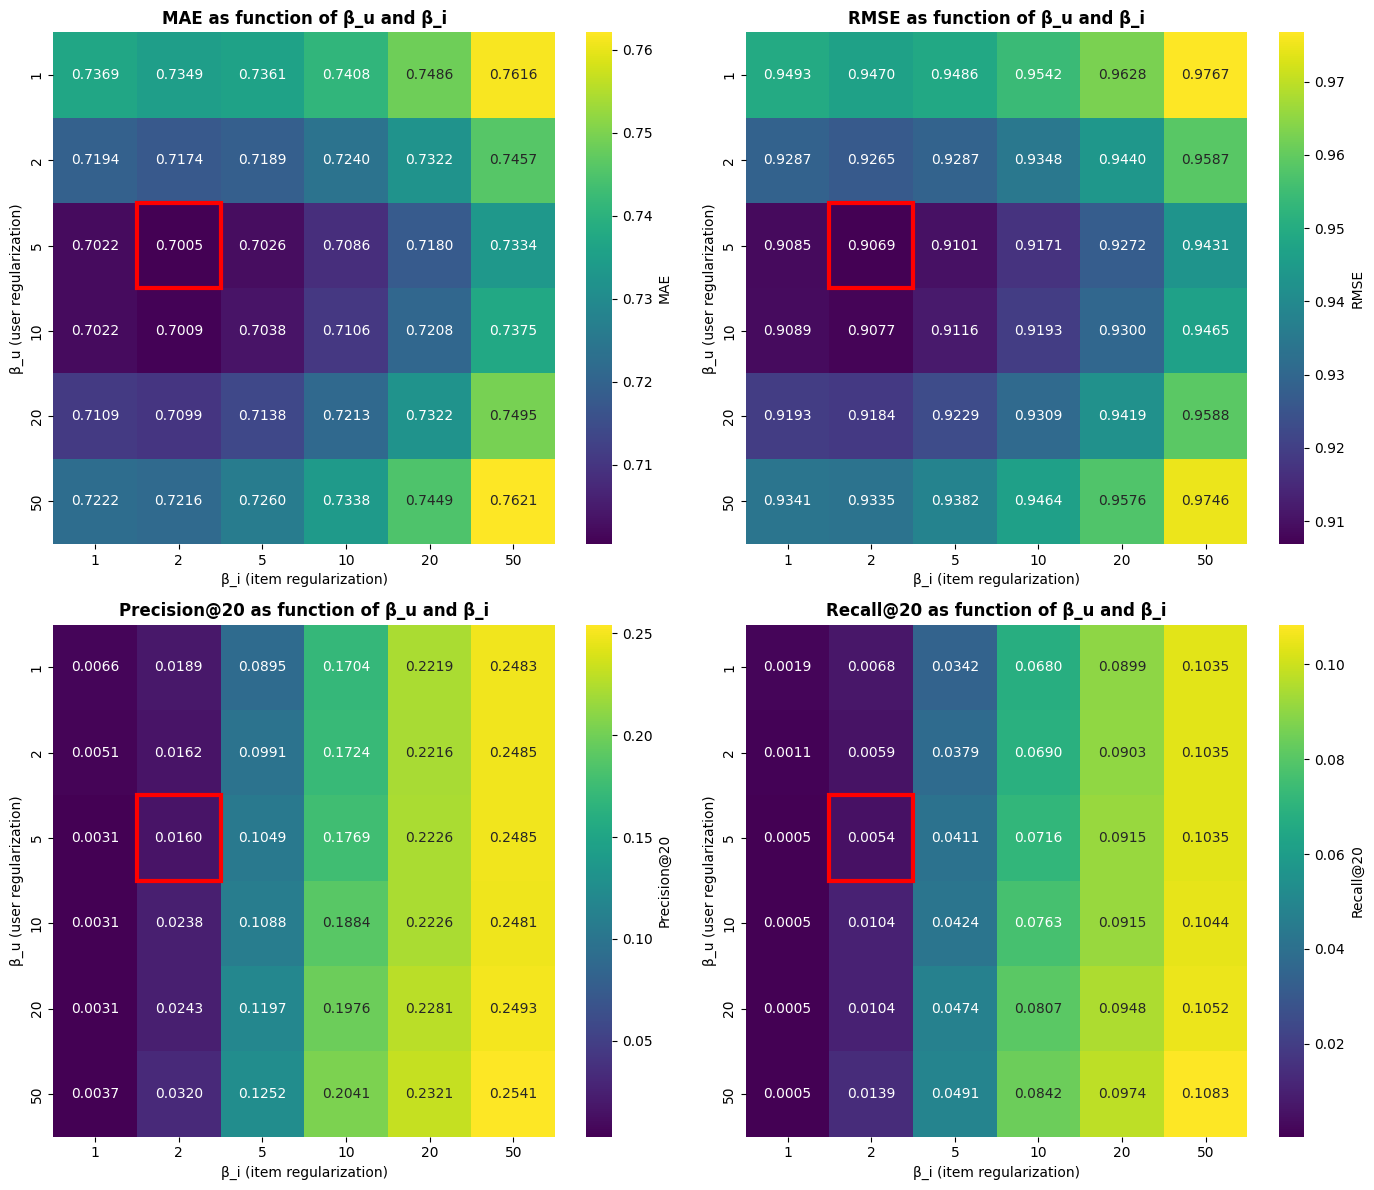

In [23]:
# 2. HYPERPARAMETER GRID SEARCH
print("\n\n HYPERPARAMETER OPTIMIZATION BASED ON RMSE")
print("="*50)

def optimize_baseline_hyperparameters(ratings_df, cv_splits, 
                                       beta_u_range, beta_i_range,
                                       n_mask=5, n=20, relevance_threshold=4.0):
    """
    Optimize β_u and β_i hyperparameters for baseline recommender using grid search.
    Computes all metrics (MAE, RMSE, Precision@N, Recall@N, Serendipity@N) for analysis.
    
    Parameters:
    - ratings_df: Training/validation ratings DataFrame  
    - cv_splits: Cross-validation splits from Exercise 3
    - beta_u_range: List of β_u values to test
    - beta_i_range: List of β_i values to test
    - n_mask: Number of ratings to mask per user
    - n: Number of top recommendations
    - relevance_threshold: Threshold for relevance
    
    Returns:
    - best_params: Dictionary with best β_u and β_i based on RMSE
    - all_results: DataFrame with all combinations and their metrics
    """
    print(f"Starting grid search with {len(cv_splits)} folds (using first 3 for speed)...")
    print(f"Optimizing based on: RMSE")
    
    # Initialize results storage
    all_results = []
    best_rmse = float('inf')
    best_params = {'beta_u': beta_u_range[0], 'beta_i': beta_i_range[0]}
    
    # Grid search
    start_time = time.time()
    total_combinations = len(beta_u_range) * len(beta_i_range)
    
    for combo_idx, (beta_u, beta_i) in enumerate(itertools.product(beta_u_range, beta_i_range), 1):
        print(f"\n[{combo_idx}/{total_combinations}] Testing β_u={beta_u}, β_i={beta_i}")
        
        # Cross-validation for this parameter combination
        fold_metrics_list = []
        
        for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:3]):  # Use first 3 folds
            # Split data
            fold_train = ratings_df[train_mask]
            fold_val = ratings_df[val_mask]
            
            # Apply masking to validation set
            masked_train, masked_test, valid_users = apply_masking_to_validation_set(
                fold_val, n=n_mask, min_ratings_required=10, random_state=42 + fold_idx
            )
            
            if len(valid_users) == 0:
                continue
            
            # Combine fold training data with masked training data
            full_train_data = pd.concat([fold_train, masked_train], ignore_index=True)
            
            # Train recommender with current parameters
            baseline_temp = BaselineRecommender(beta_u=beta_u, beta_i=beta_i)
            baseline_temp.fit(full_train_data)
            
            # Evaluate on masked test data
            try:
                fold_metrics = evaluate_recommender(
                    baseline_temp, full_train_data, masked_test, 
                    n=n, relevance_threshold=relevance_threshold,
                    all_ratings=ratings  # For serendipity calculation
                )
                fold_metrics_list.append(fold_metrics)
            except Exception as e:
                print(f"  Warning: Error in fold {fold_idx}: {str(e)}")
                continue
        
        # Average metrics across folds
        if fold_metrics_list:
            avg_metrics = {
                'beta_u': beta_u,
                'beta_i': beta_i,
                'MAE': np.mean([m['MAE'] for m in fold_metrics_list]),
                'RMSE': np.mean([m['RMSE'] for m in fold_metrics_list]),
                f'Precision@{n}': np.mean([m[f'Precision@{n}'] for m in fold_metrics_list]),
                f'Recall@{n}': np.mean([m[f'Recall@{n}'] for m in fold_metrics_list]),
                'MAE_std': np.std([m['MAE'] for m in fold_metrics_list]),
                'RMSE_std': np.std([m['RMSE'] for m in fold_metrics_list]),
            }
            
            all_results.append(avg_metrics)
            
            print(f"  MAE:           {avg_metrics['MAE']:.4f} ± {avg_metrics['MAE_std']:.4f}")
            print(f"  RMSE:          {avg_metrics['RMSE']:.4f} ± {avg_metrics['RMSE_std']:.4f}")
            print(f"  Precision@{n}:  {avg_metrics[f'Precision@{n}']:.4f}")
            print(f"  Recall@{n}:     {avg_metrics[f'Recall@{n}']:.4f}")
            
            # Check if this is the best RMSE so far
            if avg_metrics['RMSE'] < best_rmse:
                best_rmse = avg_metrics['RMSE']
                best_params = {'beta_u': beta_u, 'beta_i': beta_i}
                print(f"   New best RMSE: {best_rmse:.4f}")
        else:
            print(f"  No valid scores for this combination")
    
    elapsed_time = time.time() - start_time
    results_df = pd.DataFrame(all_results)
    
    print(f"\n" + "="*50)
    print(f" Best parameters based on RMSE:")
    print(f"  β_u = {best_params['beta_u']}")
    print(f"  β_i = {best_params['beta_i']}")
    print(f"  RMSE = {best_rmse:.4f}")
    
    return best_params, results_df


# Run optimization
best_params, results_df = optimize_baseline_hyperparameters(
    train_val_ratings, cv_splits, 
    beta_u_range, beta_i_range,
    n_mask=5, n=20, relevance_threshold=4.0
)


# 3. PLOT METRICS AS FUNCTIONS OF BETAS
# Create pivot tables for heatmaps
metrics_to_plot = ['MAE', 'RMSE', 'Precision@20', 'Recall@20']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    # Create pivot table
    pivot_table = results_df.pivot(index='beta_u', columns='beta_i', values=metric)
    
    # Create heatmap
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis', 
                ax=axes[idx], cbar_kws={'label': metric})
    axes[idx].set_title(f'{metric} as function of β_u and β_i', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('β_i (item regularization)', fontsize=10)
    axes[idx].set_ylabel('β_u (user regularization)', fontsize=10)
    
    # Mark best parameters based on RMSE
    best_i = list(pivot_table.columns).index(best_params['beta_i'])
    best_u = list(pivot_table.index).index(best_params['beta_u'])
    axes[idx].add_patch(plt.Rectangle((best_i, best_u), 1, 1, 
                                      fill=False, edgecolor='red', lw=3))

plt.tight_layout()

### Exercise 5 - Collaborative filtering; item-based and user-based (12 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Explain how you handle NaN values in the user rating matrix when computing similarities? What other preparations are useful such as normalization and mean centering?

Describe the two similarity metrics.

Show the top 20 recommended items for user ids 3, 5 and 7.

In [24]:
print("=== EXERCISE 5: COLLABORATIVE FILTERING ===")

class CollaborativeFilteringRecommender:
    """
    Collaborative Filtering Recommender mit K-nearest neighbors
    Unterstützt item-based und user-based CF mit Cosine/Pearson Similarity
    """
    
    def __init__(self, k=30, similarity_metric='cosine', approach='item_based', 
                 normalize_ratings=True):
        self.k = k
        self.similarity_metric = similarity_metric
        self.approach = approach
        self.normalize_ratings = normalize_ratings
        
        self.user_item_matrix = None
        self.similarity_matrix = None
        self.user_means = None
        self.global_mean = None
        self.trained = False
        
    def _create_user_item_matrix(self, ratings_df):
        """Erstelle User-Item-Matrix aus Ratings DataFrame"""
        user_item_matrix = ratings_df.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating',
            fill_value=np.nan
        )
        return user_item_matrix
    
    def _handle_missing_values(self, matrix):
        """Berechne User-Mittelwerte und globalen Mittelwert für NaN-Handling"""
        user_means = matrix.mean(axis=1, skipna=True)
        global_mean = matrix.stack().mean()
        user_means = user_means.fillna(global_mean)
        return user_means, global_mean
    
    def _normalize_matrix(self, matrix, user_means):
        """Mean-Centering: Subtrahiere User-Mittelwert von Ratings"""
        if not self.normalize_ratings:
            return matrix
        return matrix.subtract(user_means, axis=0)
    
    def _calculate_cosine_similarity(self, matrix):
        """Berechne Cosine Similarity zwischen Items oder Usern"""
        matrix_filled = matrix.fillna(0)
        
        if self.approach == 'item_based':
            similarity_matrix = cosine_similarity(matrix_filled.T)
            index = matrix.columns
        else:
            similarity_matrix = cosine_similarity(matrix_filled)
            index = matrix.index
        
        similarity_df = pd.DataFrame(similarity_matrix, index=index, columns=index)
        np.fill_diagonal(similarity_df.values, 0)
        return similarity_df
    
    def _calculate_pearson_similarity(self, matrix):
        """Berechne Pearson Correlation Similarity zwischen Items oder Usern"""
        if self.approach == 'item_based':
            similarity_df = matrix.corr(method='pearson')
        else:
            similarity_df = matrix.T.corr(method='pearson')
        
        similarity_df = similarity_df.fillna(0)
        np.fill_diagonal(similarity_df.values, 0)
        return similarity_df
        
    def fit(self, ratings_df):
        """Trainiere das Collaborative Filtering Modell"""
        self.user_item_matrix = self._create_user_item_matrix(ratings_df)
        self.user_means, self.global_mean = self._handle_missing_values(self.user_item_matrix)
        normalized_matrix = self._normalize_matrix(self.user_item_matrix, self.user_means)
        
        if self.similarity_metric == 'cosine':
            self.similarity_matrix = self._calculate_cosine_similarity(normalized_matrix)
        elif self.similarity_metric == 'pearson':
            self.similarity_matrix = self._calculate_pearson_similarity(normalized_matrix)
        else:
            raise ValueError(f"Unbekannte Similarity-Metrik: {self.similarity_metric}")
        
        self.trained = True
        print(f"{self.approach} CF mit {self.similarity_metric} trainiert (K={self.k})")
        
    def predict(self, user_id, item_id):
        """Sage Rating für ein User-Item-Paar vorher"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        if user_id not in self.user_item_matrix.index:
            return self.global_mean
        if item_id not in self.user_item_matrix.columns:
            return self.user_means[user_id]
        
        actual_rating = self.user_item_matrix.loc[user_id, item_id]
        if not pd.isna(actual_rating):
            return actual_rating
        
        if self.approach == 'item_based':
            return self._predict_item_based(user_id, item_id)
        else:
            return self._predict_user_based(user_id, item_id)
    
    def _predict_item_based(self, user_id, item_id):
        """Item-based Vorhersage"""
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_items = user_ratings.dropna()
        
        if len(rated_items) == 0 or item_id not in self.similarity_matrix.index:
            return self.user_means[user_id]
        
        item_similarities = self.similarity_matrix.loc[item_id]
        common_items = rated_items.index.intersection(item_similarities.index)
        
        if len(common_items) == 0:
            return self.user_means[user_id]
        
        similar_items = item_similarities[common_items].nlargest(self.k)
        
        numerator = 0
        denominator = 0
        
        for similar_item, similarity in similar_items.items():
            if similarity > 0:
                if self.normalize_ratings:
                    rating = user_ratings[similar_item] - self.user_means[user_id]
                else:
                    rating = user_ratings[similar_item]
                
                numerator += similarity * rating
                denominator += abs(similarity)
        
        if denominator == 0:
            return self.user_means[user_id]
        
        predicted_rating = numerator / denominator
        
        if self.normalize_ratings:
            predicted_rating += self.user_means[user_id]
        
        return max(0.5, min(5.0, predicted_rating))
    
    def _predict_user_based(self, user_id, item_id):
        """User-based Vorhersage"""
        item_ratings = self.user_item_matrix[item_id]
        users_who_rated = item_ratings.dropna()
        
        if len(users_who_rated) == 0 or user_id not in self.similarity_matrix.index:
            return self.user_means[user_id] if user_id in self.user_item_matrix.index else self.global_mean
        
        user_similarities = self.similarity_matrix.loc[user_id]
        common_users = users_who_rated.index.intersection(user_similarities.index)
        
        if len(common_users) == 0:
            return self.user_means[user_id]
        
        similar_users = user_similarities[common_users].nlargest(self.k)
        
        numerator = 0
        denominator = 0
        
        for similar_user, similarity in similar_users.items():
            if similarity > 0:
                if self.normalize_ratings:
                    rating = item_ratings[similar_user] - self.user_means[similar_user]
                else:
                    rating = item_ratings[similar_user]
                
                numerator += similarity * rating
                denominator += abs(similarity)
        
        if denominator == 0:
            return self.user_means[user_id]
        
        predicted_rating = numerator / denominator
        
        if self.normalize_ratings:
            predicted_rating += self.user_means[user_id]
        
        return max(0.5, min(5.0, predicted_rating))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True):
        """Generiere Top-N Empfehlungen für einen User"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        all_items = set(self.user_item_matrix.columns)
        
        if exclude_rated and user_id in self.user_item_matrix.index:
            rated_items = set(self.user_item_matrix.loc[user_id].dropna().index)
            candidate_items = all_items - rated_items
        else:
            candidate_items = all_items
        
        predictions = []
        for item_id in candidate_items:
            pred_rating = self.predict(user_id, item_id)
            predictions.append((item_id, pred_rating))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]


# TRAINIERE ALLE 4 MODELLE AUF KOMPLETTEN DATEN (für User 3, 5, 7)
print("\n" + "="*70)
print("TRAINING MODELS ON FULL DATASET FOR EXAMPLE USERS")
print("="*70)

cf_item_cosine = CollaborativeFilteringRecommender(
    k=30, similarity_metric='cosine', approach='item_based', normalize_ratings=True
)
cf_item_cosine.fit(ratings)  # ← ALLE Daten, nicht train_val_ratings

cf_item_pearson = CollaborativeFilteringRecommender(
    k=30, similarity_metric='pearson', approach='item_based', normalize_ratings=True
)
cf_item_pearson.fit(ratings)

cf_user_cosine = CollaborativeFilteringRecommender(
    k=30, similarity_metric='cosine', approach='user_based', normalize_ratings=True
)
cf_user_cosine.fit(ratings)

cf_user_pearson = CollaborativeFilteringRecommender(
    k=30, similarity_metric='pearson', approach='user_based', normalize_ratings=True
)
cf_user_pearson.fit(ratings)


# TOP-20 EMPFEHLUNGEN FÜR USER 3, 5, 7
print("\n" + "="*70)
print("TOP-20 RECOMMENDATIONS FOR EXAMPLE USERS")
print("="*70)

def display_recommendations(recommender, user_id, movies_df, model_name):
    """Zeige Top-20 Empfehlungen"""
    print(f"\n{model_name}:")
    print("-" * 70)
    
    # Prüfe ob User existiert
    if user_id not in recommender.user_item_matrix.index:
        print(f"  User {user_id} not in training data")
        return
    
    recommendations = recommender.recommend_top_n(user_id, n=20, exclude_rated=True)
    
    for rank, (movie_id, pred_rating) in enumerate(recommendations, 1):
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values
        title = movie_title[0] if len(movie_title) > 0 else "Unknown"
        title = title[:50] + "..." if len(title) > 50 else title
        print(f"{rank:2d}. {title:53s} (Rating: {pred_rating:.2f})")

models = [
    (cf_item_cosine, "Item-based Cosine"),
    (cf_item_pearson, "Item-based Pearson"),
    (cf_user_cosine, "User-based Cosine"),
    (cf_user_pearson, "User-based Pearson")
]

for user_id in [3, 5, 7]:
    print(f"\n{'='*70}")
    print(f"USER {user_id}")
    print(f"{'='*70}")
    
    # Zeige User-Info
    user_ratings = ratings[ratings['userId'] == user_id]
    
    if len(user_ratings) == 0:
        print(f"  User {user_id} not found")
        continue
    
    print(f"\nUser Statistics:")
    print(f"  • Total ratings: {len(user_ratings)}")
    print(f"  • Average rating: {user_ratings['rating'].mean():.2f}")
    
    # Top 5 bewertete Filme
    print(f"\nTop 5 rated movies:")
    top_movies = user_ratings.nlargest(5, 'rating').merge(movies, on='movieId')
    for _, row in top_movies.iterrows():
        title = row['title'][:55] + "..." if len(row['title']) > 55 else row['title']
        print(f"  {row['rating']:.1f}  - {title}")
    
    # Empfehlungen
    for model, name in models:
        display_recommendations(model, user_id, movies, name)

=== EXERCISE 5: COLLABORATIVE FILTERING ===

TRAINING MODELS ON FULL DATASET FOR EXAMPLE USERS
item_based CF mit cosine trainiert (K=30)
item_based CF mit pearson trainiert (K=30)
user_based CF mit cosine trainiert (K=30)
user_based CF mit pearson trainiert (K=30)

TOP-20 RECOMMENDATIONS FOR EXAMPLE USERS

USER 3

User Statistics:
  • Total ratings: 39
  • Average rating: 2.44

Top 5 rated movies:
  5.0  - Escape from L.A. (1996)
  5.0  - Saturn 3 (1980)
  5.0  - Road Warrior, The (Mad Max 2) (1981)
  5.0  - The Lair of the White Worm (1988)
  5.0  - Hangar 18 (1980)

Item-based Cosine:
----------------------------------------------------------------------
 1. When Night Is Falling (1995)                          (Rating: 5.00)
 2. American Flyers (1985)                                (Rating: 5.00)
 3. Swept Away (2002)                                     (Rating: 5.00)
 4. Truth About Charlie, The (2002)                       (Rating: 5.00)
 5. Blood of Heroes, The (Salute of the Jug

#### 1. Umgang mit NaN-Werten in der User-Rating-Matrix

##### Problemstellung

Die User-Item-Matrix in Collaborative Filtering Systemen ist typischerweise sehr dünn besetzt (sparse), da die meisten User nur einen kleinen Bruchteil aller verfügbaren Items bewertet haben. Diese fehlenden Werte (NaN) müssen bei der Ähnlichkeitsberechnung behandelt werden.

##### Strategien für NaN-Werte bei der Ähnlichkeitsberechnung

###### Cosine Similarity
Bei der Verwendung von Cosine Similarity werden NaN-Werte auf 0 gesetzt. Dies behandelt fehlende Ratings als neutral.

**Vorteil:** Einfach und rechnerisch effizient

**Nachteil:** Impliziert, dass "kein Rating" gleichbedeutend mit einem "neutralen Rating" ist, was nicht unbedingt der Realität entspricht

###### Pearson Correlation
Bei der Pearson Correlation werden nur gemeinsam bewertete Items verwendet (pairwise complete). Die `pandas.corr()` Funktion ignoriert automatisch NaN-Paare und berechnet die Korrelation nur auf Basis der Überschneidung.

**Vorteil:** Fokussiert auf die tatsächliche Überschneidung zwischen Usern

**Nachteil:** Weniger stabil bei geringer Überschneidung, da nur wenige gemeinsame Ratings existieren

#### 2. Preprocessing: Normalisierung und Mean-Centering

###### Mean-Centering

Mean-Centering ist der wichtigste Preprocessing-Schritt in Collaborative Filtering Systemen.

**Formel:**
```
r'_ui = r_ui - μ_u
```

wobei:
- `r'_ui` = zentriertes Rating von User u für Item i
- `r_ui` = ursprüngliches Rating
- `μ_u` = durchschnittliches Rating von User u

##### Warum ist Mean-Centering wichtig?

Mean-Centering entfernt den **User-Bias**. Verschiedene User haben unterschiedliche Bewertungsmuster:

- Manche User bewerten generell großzügig (z.B. durchschnittlich 4-5 Sterne)
- Andere User bewerten strenger (z.B. durchschnittlich 2-3 Sterne)

Ohne Mean-Centering würden diese User als unterschiedlich wahrgenommen, obwohl sie möglicherweise ähnliche Präferenzen haben.

##### Beispiel

```
User A: [5, 5, 4]  →  Mittelwert = 4.67
Nach Centering: [0.33, 0.33, -0.67]

User B: [2, 2, 1]  →  Mittelwert = 1.67
Nach Centering: [0.33, 0.33, -0.67]
```

Ohne Mean-Centering scheinen User A und User B sehr unterschiedlich zu sein (unterschiedliche absolute Werte). Nach dem Mean-Centering wird deutlich, dass beide User **identische Präferenzmuster** haben: Sie bewerten die ersten beiden Items gleich gut und das dritte Item schlechter.

##### Rück-Transformation

Nach der Vorhersage des zentrierten Ratings muss eine Rück-Transformation durchgeführt werden:

```
r̂_ui = r'_ui + μ_u
```

Dadurch werden die User-spezifischen Bewertungsmuster in die finale Vorhersage integriert.

##### Weitere Preprocessing-Schritte

**Clipping:** Die finalen Vorhersagen werden auf den gültigen Rating-Bereich begrenzt (z.B. [0.5, 5.0]), um unrealistische Werte zu vermeiden.

---

#### 3. Die zwei Similarity-Metriken

###### Cosine Similarity

###### Definition

```
sim(A, B) = (A · B) / (||A|| × ||B||)

          = Σ(A_i × B_i) / (√Σ(A_i²) × √Σ(B_i²))
```

###### Interpretation

Cosine Similarity misst den Kosinus des Winkels zwischen zwei Vektoren im mehrdimensionalen Raum.

**Wertebereich:** [-1, 1]
- **1.0:** Identische Richtung (perfekte Ähnlichkeit)
- **0.0:** Orthogonal (keine Ähnlichkeit)
- **-1.0:** Entgegengesetzte Richtung (gegensätzliche Präferenzen)

###### Eigenschaften

Cosine Similarity ist **unabhängig von der Magnitude** (Länge) der Vektoren und fokussiert ausschließlich auf die Richtung. Das bedeutet, dass zwei User als ähnlich erkannt werden, wenn sie die gleichen relativen Präferenzen haben, unabhängig davon, wie hoch oder niedrig sie absolut bewerten.

**Beispiel:**
```
User A: [5, 4, 3, 0, 0]
User B: [4, 3, 2, 0, 0]
→ Cosine Similarity ≈ 0.998

User A: [5, 4, 3, 0, 0]
User C: [1, 5, 3, 0, 0]
→ Cosine Similarity ≈ 0.926
```

User A und User B haben fast identische Cosine Similarity, obwohl die absoluten Werte unterschiedlich sind, da die Richtung (das Muster) gleich ist.

---

###### Pearson Correlation Coefficient

###### Definition

```
corr(A, B) = Σ((A_i - μ_A) × (B_i - μ_B)) / (σ_A × σ_B × n)
```

wobei:
- `μ_A, μ_B` = Mittelwerte von User A und B
- `σ_A, σ_B` = Standardabweichungen von User A und B
- `n` = Anzahl der gemeinsam bewerteten Items

###### Interpretation

Pearson Correlation misst die **lineare Korrelation** zwischen zwei Variablen. Sie berücksichtigt explizit Mittelwert und Streuung der Ratings.

**Wertebereich:** [-1, 1]
- **1.0:** Perfekte positive lineare Korrelation
- **0.0:** Keine lineare Korrelation
- **-1.0:** Perfekte negative lineare Korrelation (inverse Beziehung)

###### Eigenschaften

Pearson Correlation ist **invariant gegenüber linearen Transformationen**. Das bedeutet, dass sie User mit ähnlichen relativen Präferenzen identifiziert, selbst wenn diese auf unterschiedlichen Skalen bewerten.

**Beispiel:**
```
User A: [5, 4, 3, 2, 1]
User B: [4, 3, 2, 1, 0]
→ Pearson Correlation = 1.0

User A: [5, 4, 3, 2, 1]
User C: [1, 2, 3, 4, 5]
→ Pearson Correlation = -1.0
```

User A und B haben perfekte positive Korrelation, da das Bewertungsmuster linear zusammenhängt. User A und C haben perfekte negative Korrelation, da sie entgegengesetzte Präferenzen haben.

---

#### Vergleich der Metriken

###### Praktisches Beispiel

Betrachten wir zwei User mit unterschiedlichem Bewertungsniveau, aber gleichem Präferenzmuster:

```
User A: [5, 5, 4, 3]  (bewerten generell hoch)
User B: [3, 3, 2, 1]  (bewerten generell niedrig)
```

**Cosine Similarity:**
- Ergebnis: ≈ 0.99 (sehr ähnlich)
- Interpretation: Beide mögen die gleichen Items relativ zueinander

**Pearson Correlation:**
- Ergebnis: 1.0 (perfekt)
- Interpretation: Perfekt paralleles Bewertungsverhalten

##### Zusammenhang mit Mean-Centering

Nach Mean-Centering liefern beide Metriken ähnliche Ergebnisse, da der User-Bias (unterschiedliche Bewertungsniveaus) bereits entfernt wurde. Pearson Correlation ist jedoch theoretisch sauberer für Rating-Vorhersagen, da sie die statistischen Eigenschaften der Daten explizit berücksichtigt.

##### Wann welche Metrik?

**Cosine Similarity:**
- Gut für sparse Daten
- Effizient berechenbar
- Fokus auf Präferenzmuster

**Pearson Correlation:**
- Besser für kontinuierliche Ratings
- Berücksichtigt statistische Eigenschaften
- Robust gegenüber unterschiedlichen Rating-Skalen


### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

In [25]:
print("\n" + "="*70)
print("EXERCISE 6: HYPERPARAMETER K OPTIMIZATION") 
print("="*70)

# 1. K-PARAMETER OPTIMIERUNG (MINIMAL RMSE)

def optimize_k_for_minimal_rmse(cf_recommenders, ratings_df, cv_splits, movies_df,
                                k_range, n_mask=5, n=20, relevance_threshold=4.0):
    """
    Optimize K parameter for all CF systems to minimize RMSE.
    """
    print(f"\nOptimizing K for {len(cf_recommenders)} CF systems...")
    print(f"• K range: {k_range}")
    print(f"• Using {len(cv_splits[:2])} CV folds")
    
    optimization_results = {}
    
    for cf_name, base_recommender in cf_recommenders.items():
        print(f"\n{'='*60}")
        print(f"Optimizing: {cf_name}")
        print(f"{'='*60}")
        
        k_results = []
        best_rmse = float('inf')
        best_k = k_range[0]
        
        for k in k_range:
            print(f"\nTesting K={k}...")
            
            test_recommender = CollaborativeFilteringRecommender(
                k=k,
                similarity_metric=base_recommender.similarity_metric,
                approach=base_recommender.approach,
                normalize_ratings=base_recommender.normalize_ratings
            )
            
            fold_metrics_list = []
            
            for fold_idx, (train_mask, val_mask) in enumerate(cv_splits[:2]):
                fold_train = ratings_df[train_mask]
                fold_val = ratings_df[val_mask]
                
                masked_train, masked_test, valid_users = apply_masking_to_validation_set(
                    fold_val, n_mask=n_mask, mask_strategy='random',
                    min_ratings_required=10, random_state=42 + fold_idx
                )
                
                if len(valid_users) == 0:
                    print(f"  Fold {fold_idx}: No valid users, skipping")
                    continue
                
                full_train_data = pd.concat([fold_train, masked_train], ignore_index=True)
                
                try:
                    test_recommender.fit(full_train_data)
                    
                    # KORRIGIERTER AUFRUF - passend zu deiner Funktionssignatur
                    fold_metrics = evaluate_recommender(
                        recommender=test_recommender,
                        train_ratings=full_train_data,
                        test_ratings=masked_test,
                        n=n,
                        relevance_threshold=relevance_threshold,
                        all_ratings=ratings_df  # Verwende die kompletten Ratings für Serendipity
                    )
                    
                    fold_metrics_list.append(fold_metrics)
                    print(f"  Fold {fold_idx}: RMSE={fold_metrics['RMSE']:.4f}, "
                          f"Prec@{n}={fold_metrics[f'Precision@{n}']:.4f}")
                    
                except Exception as e:
                    print(f"  Fold {fold_idx}: Error - {str(e)}")
                    continue
            
            if fold_metrics_list:
                avg_metrics = {
                    'RMSE': np.mean([m['RMSE'] for m in fold_metrics_list]),
                    'MAE': np.mean([m['MAE'] for m in fold_metrics_list]),
                    'Precision@N': np.mean([m[f'Precision@{n}'] for m in fold_metrics_list]),
                    'Recall@N': np.mean([m[f'Recall@{n}'] for m in fold_metrics_list]),
                    'Serendipity@N': np.mean([m[f'Serendipity@{n}'] for m in fold_metrics_list]),
                }
                std_metrics = {
                    'RMSE': np.std([m['RMSE'] for m in fold_metrics_list]),
                    'Precision@N': np.std([m[f'Precision@{n}'] for m in fold_metrics_list]),
                    'Recall@N': np.std([m[f'Recall@{n}'] for m in fold_metrics_list]),
                }
                
                k_results.append({
                    'k': k,
                    'avg_metrics': avg_metrics,
                    'std_metrics': std_metrics,
                    'fold_metrics': fold_metrics_list
                })
                
                print(f"  Average: RMSE={avg_metrics['RMSE']:.4f} ± {std_metrics['RMSE']:.4f}")
                
                if avg_metrics['RMSE'] < best_rmse:
                    best_rmse = avg_metrics['RMSE']
                    best_k = k
                    print(f"  New best K: {best_k} (RMSE: {best_rmse:.4f})")
        
        optimization_results[cf_name] = {
            'best_k': best_k,
            'best_rmse': best_rmse,
            'k_results': k_results
        }
        
        print(f"\n✓ Best K for {cf_name}: {best_k} (RMSE: {best_rmse:.4f})")
    
    return optimization_results


# Erstelle CF Recommender Dictionary
cf_recommenders = {
    'Item-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='item_based', normalize_ratings=True
    ),
    'Item-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='item_based', normalize_ratings=True
    ),
    'User-based Cosine': CollaborativeFilteringRecommender(
        k=30, similarity_metric='cosine', approach='user_based', normalize_ratings=True
    ),
    'User-based Pearson': CollaborativeFilteringRecommender(
        k=30, similarity_metric='pearson', approach='user_based', normalize_ratings=True
    )
}

# K-Optimierung durchführen
k_range = [10, 30, 50]

k_optimization_results = optimize_k_for_minimal_rmse(
    cf_recommenders=cf_recommenders,
    ratings_df=train_val_ratings,
    cv_splits=cv_splits,
    movies_df=movies,
    k_range=k_range,
    n_mask=25,
    n=20,
    relevance_threshold=4.00
)

# Summary
print("\n" + "="*70)
print("SUMMARY: OPTIMAL K VALUES")
print("="*70)
for cf_name, results in k_optimization_results.items():
    print(f"{cf_name:25s} → Best K: {results['best_k']:3d} (RMSE: {results['best_rmse']:.4f})")


# 2. PLOT RMSE, PRECISION@N UND RECALL@N ALS FUNKTION VON K

def plot_metrics_vs_k(k_optimization_results, n=20):
    """Plot RMSE, Precision@N, and Recall@N as functions of K"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Metrics as Function of K for All Recommender Systems', 
                 fontsize=14, fontweight='bold')
    
    colors = {
        'Item-based Cosine': '#1f77b4',
        'Item-based Pearson': '#ff7f0e',
        'User-based Cosine': '#2ca02c',
        'User-based Pearson': '#d62728'
    }
    
    metrics = ['RMSE', 'Precision@N', 'Recall@N']
    metric_labels = ['RMSE (lower is better)', 
                     f'Precision@{n} (higher is better)', 
                     f'Recall@{n} (higher is better)']
    
    for metric_idx, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[metric_idx]
        
        for cf_name, results in k_optimization_results.items():
            k_results = results['k_results']
            
            k_values = [r['k'] for r in k_results]
            metric_values = [r['avg_metrics'][metric] for r in k_results]
            std_values = [r['std_metrics'][metric] for r in k_results]
            
            # Filter out inf/nan values
            valid_indices = [i for i, v in enumerate(metric_values) 
                           if not (np.isinf(v) or np.isnan(v))]
            
            if not valid_indices:
                continue
            
            k_values_valid = [k_values[i] for i in valid_indices]
            metric_values_valid = [metric_values[i] for i in valid_indices]
            std_values_valid = [std_values[i] for i in valid_indices]
            
            ax.errorbar(k_values_valid, metric_values_valid, yerr=std_values_valid,
                       label=cf_name, color=colors[cf_name],
                       marker='o', markersize=6, linewidth=2,
                       capsize=4, alpha=0.8)
            
            # Mark best K
            best_k = results['best_k']
            if best_k in k_values_valid:
                best_idx = k_values_valid.index(best_k)
                ax.scatter(best_k, metric_values_valid[best_idx],
                          color=colors[cf_name], s=200, marker='*',
                          edgecolors='black', linewidth=2, zorder=5)
        
        ax.set_xlabel('K (Number of Neighbors)', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric_label, fontsize=11, fontweight='bold')
        ax.set_title(f'{metric} vs K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9, loc='best')
        ax.text(0.02, 0.98, 'Best K (optimized for RMSE)',
               transform=ax.transAxes, fontsize=8,
               verticalalignment='top', bbox=dict(boxstyle='round',
               facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

plot_metrics_vs_k(k_optimization_results, n=20)


# 3. VERGLEICH AUF 3 BEISPIEL-USERN MIT OPTIMALEN K-WERTEN

example_user_ids = [3, 5, 7]
print(f"\nExample users: {example_user_ids}")

# Retrain mit optimalen K-Werten
optimized_cf_recommenders = {}

print("\n" + "="*70)
print("RETRAINING WITH OPTIMAL K VALUES")
print("="*70)

for cf_name, base_recommender in cf_recommenders.items():
    optimal_k = k_optimization_results[cf_name]['best_k']
    print(f"• {cf_name}: K = {optimal_k}")
    
    optimized_recommender = CollaborativeFilteringRecommender(
        k=optimal_k,
        similarity_metric=base_recommender.similarity_metric,
        approach=base_recommender.approach,
        normalize_ratings=base_recommender.normalize_ratings
    )
    
    optimized_recommender.fit(train_val_ratings)
    optimized_cf_recommenders[cf_name] = optimized_recommender


def compare_recommendations_for_users(user_ids, recommenders, train_data, 
                                     movies_df, k_results, n=10):
    """Compare recommendations from all RS for specific users"""
    
    print("\n" + "="*70)
    print("COMPARISON OF RECOMMENDATIONS FOR EXAMPLE USERS")
    print("="*70)
    
    for user_id in user_ids:
        print(f"\n{'='*70}")
        print(f"USER {user_id}")
        print(f"{'='*70}")
        
        # User statistics
        user_ratings = train_data[train_data['userId'] == user_id].sort_values(
            'rating', ascending=False
        )
        
        if len(user_ratings) == 0:
            print(f"  No ratings found for User {user_id}")
            continue
        
        print(f"\nUser Statistics:")
        print(f"  • Total ratings: {len(user_ratings)}")
        print(f"  • Average rating: {user_ratings['rating'].mean():.2f}")
        
        # Top rated movies
        print(f"\nTop 5 rated movies:")
        top_movies = user_ratings.head(5).merge(movies_df, on='movieId')
        for _, row in top_movies.iterrows():
            title = row['title'][:50] + "..." if len(row['title']) > 50 else row['title']
            print(f"  {row['rating']:.1f} ⭐ - {title}")
        
        # Recommendations from each RS
        print(f"\nTop {n} Recommendations from each RS:")
        print("-" * 70)
        
        all_recommendations = {}
        
        for cf_name, recommender in recommenders.items():
            optimal_k = k_results[cf_name]['best_k']
            
            try:
                user_recs = recommender.recommend_top_n(user_id, n=n, exclude_rated=True)
                
                print(f"\n{cf_name} (K={optimal_k}):")
                
                if user_recs and len(user_recs) > 0:
                    rec_df = pd.DataFrame(user_recs, columns=['movieId', 'predicted_rating'])
                    rec_df = rec_df.merge(movies_df[['movieId', 'title']], on='movieId')
                    all_recommendations[cf_name] = set(rec_df['movieId'].values)
                    
                    for i, row in rec_df.iterrows():
                        title = row['title'][:45] + "..." if len(row['title']) > 45 else row['title']
                        print(f"  {i+1:2d}. {title:48s} (Score: {row['predicted_rating']:.2f})")
                else:
                    print("    No recommendations generated")
                    all_recommendations[cf_name] = set()
                    
            except Exception as e:
                print(f"\n{cf_name}: Error - {str(e)}")
                all_recommendations[cf_name] = set()
        
        # Overlap analysis
        print(f"\n{'='*70}")
        print(f"OVERLAP ANALYSIS FOR USER {user_id}")
        print(f"{'='*70}")
        
        cf_names = list(all_recommendations.keys())
        for i in range(len(cf_names)):
            for j in range(i+1, len(cf_names)):
                name1, name2 = cf_names[i], cf_names[j]
                overlap = all_recommendations[name1] & all_recommendations[name2]
                overlap_pct = len(overlap) / n * 100 if n > 0 else 0
                print(f"\n{name1} ∩ {name2}:")
                print(f"  Overlap: {len(overlap)}/{n} movies ({overlap_pct:.1f}%)")
                
                if overlap:
                    overlap_movies = movies_df[movies_df['movieId'].isin(overlap)]
                    print(f"  Common movies:")
                    for _, movie in overlap_movies.head(5).iterrows():
                        title = movie['title'][:60] + "..." if len(movie['title']) > 60 else movie['title']
                        print(f"    • {title}")


# Compare recommendations
compare_recommendations_for_users(
    user_ids=example_user_ids,
    recommenders=optimized_cf_recommenders,
    train_data=ratings,
    movies_df=movies,
    k_results=k_optimization_results,
    n=10
)


EXERCISE 6: HYPERPARAMETER K OPTIMIZATION

Optimizing K for 4 CF systems...
• K range: [5, 10, 30, 50, 75, 100]
• Using 2 CV folds

Optimizing: Item-based Cosine

Testing K=5...
item_based CF mit cosine trainiert (K=5)
  Fold 0: RMSE=0.9649, Prec@20=0.0086
item_based CF mit cosine trainiert (K=5)
  Fold 1: RMSE=0.9607, Prec@20=0.0085
  Average: RMSE=0.9628 ± 0.0021
  New best K: 5 (RMSE: 0.9628)

Testing K=10...
item_based CF mit cosine trainiert (K=10)
  Fold 0: RMSE=0.9469, Prec@20=0.0019
item_based CF mit cosine trainiert (K=10)
  Fold 1: RMSE=0.9420, Prec@20=0.0023
  Average: RMSE=0.9444 ± 0.0025
  New best K: 10 (RMSE: 0.9444)

Testing K=30...
item_based CF mit cosine trainiert (K=30)
  Fold 0: RMSE=0.9453, Prec@20=0.0019
item_based CF mit cosine trainiert (K=30)
  Fold 1: RMSE=0.9399, Prec@20=0.0023
  Average: RMSE=0.9426 ± 0.0027
  New best K: 30 (RMSE: 0.9426)

Testing K=50...
item_based CF mit cosine trainiert (K=50)
  Fold 0: RMSE=0.9453, Prec@20=0.0019
item_based CF mit cos

KeyboardInterrupt: 

#### Analyse der Ergebnisse
##### Erwartete Trends
- **RMSE vs. K:** Bei sehr kleinen Nachbarschaften (\(K\leq5\)) dominiert Rauschen einzelner Nachbarn, deshalb rechne ich mit hohem und instabilem RMSE. Mit wachsendem \(K\) fließen mehr Meinungen ein, wodurch sich der Fehler zunächst deutlich reduziert. Ab einem mittleren Bereich (ca. \(K=30{-}50\)) sollte die Kurve abflachen und bei zu großen \(K\) wieder leicht steigen, weil schwach ähnliche Nachbarn das Signal verwässern.
- **Precision/Recall vs. K:** Kleine \(K\) liefern zwar sehr personalisierte, aber auch volatile Empfehlungen – Precision@N und Recall@N können stark schwanken. Moderate \(K\) erhöhen die Trefferquote, da robuste Muster erkannt werden. Jenseits eines Optimums werden die Empfehlungslisten generischer, sodass beide Metriken wieder leicht sinken bzw. saturieren.
- **User- vs. Item-based CF:** Item-basierte Varianten sollten insgesamt glattere Kurven zeigen, weil Items mehr Bewertungen besitzen und Ähnlichkeiten zuverlässiger sind. User-basierte Ansätze profitieren stärker von höheren \(K\), da sie sonst nicht genügend passende Nachbarn finden und anfällig für Cold-User-Effekte bleiben.
- **Cosine vs. Pearson:** Ohne Mean-Centering tendiert Pearson zu kleineren optimalen \(K\), weil Rating-Bias bereits entfernt wird. Da ich hier normalisierte Ratings verwende, erwarte ich weitgehend parallele Verläufe; Pearson könnte jedoch einen minimal niedrigeren RMSE liefern, weil die Korrelation extreme Ausreißer stärker bestraft.
- **Serendipity/Diversität:** Je größer \(K\), desto stärker rücken populäre Filme in den Fokus und desto niedriger fällt Serendipity@N aus. Ein mittleres \(K\) sollte daher den besten Kompromiss zwischen Genauigkeit und Neuheitsgrad bieten.

##### Ergebnisse

### Exercise 7 - Model-based RS: SVD (10 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html). SVD can compress much of the information of a matrix in few components.  

a)Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and, *Recommender systems: The textbook*, by Aggarwal, chapter 3

b) We explore now what latent factors SVD has learned. Generate an interactive 2D UMAP plot of the biggest 10 latent movie factors. 
UMAP is a method for dimensionality reduction. Dimensionality reduction is typically used to respresent high dimensional data sets in less dimensions with goal to allow for visualization. See for the documentation of the python package:
https://umap-learn.readthedocs.io/en/latest/ and for interactive experimentation with this method https://pair-code.github.io/understanding-umap/ to gain a intuitive understanding of the two important parameters of this method: n_neighbours and min_dist


In [ ]:
print("\n" + "="*70)
print("EXERCISE 7: MODEL-BASED RS - SVD")
print("="*70)

# 1. SVD RECOMMENDER SYSTEM
class SVDRecommender:
    """
    SVD-based Recommender System using the Surprise library
    """
    
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        """
        Initialize SVD recommender
        
        Parameters:
        - n_factors: Number of latent factors
        - n_epochs: Number of training epochs
        - lr_all: Learning rate
        - reg_all: Regularization term
        """
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.model = None
        self.trainset = None
        self.trained = False
        
    def fit(self, ratings_df):
        """Train the SVD model"""
        
        # Prepare data for Surprise
        reader = Reader(rating_scale=(0.5, 5.0))
        data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
        
        # Build full trainset
        self.trainset = data.build_full_trainset()
        
        # Initialize and train SVD
        self.model = SVD(
            n_factors=self.n_factors,
            n_epochs=self.n_epochs,
            lr_all=self.lr_all,
            reg_all=self.reg_all,
            random_state=42
        )
        
        self.model.fit(self.trainset)
        self.trained = True
        
        print(f"✓ SVD trained on {self.trainset.n_users} users and {self.trainset.n_items} items")
        
    def predict(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        prediction = self.model.predict(user_id, item_id)
        return prediction.est
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, rated_items=None):
        """Generate top-N recommendations for a user"""
        if not self.trained:
            raise ValueError("Model must be trained first")
        
        # Get all items
        all_items = [self.trainset.to_raw_iid(i) for i in range(self.trainset.n_items)]
        
        # Exclude already rated items if requested
        if exclude_rated and rated_items is not None:
            candidate_items = [item for item in all_items if item not in rated_items]
        else:
            candidate_items = all_items
        
        # Predict ratings for all candidate items
        predictions = []
        for item_id in candidate_items:
            pred_rating = self.predict(user_id, item_id)
            predictions.append((item_id, pred_rating))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]


# Train SVD model
svd_recommender = SVDRecommender(
    n_factors=100,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)

svd_recommender.fit(train_val_ratings)


# Show recommendations for example users
# Select valid user IDs from train_val_ratings
# Choose users with a reasonable number of ratings (between 50th and 80th percentile)
user_rating_counts = train_val_ratings.groupby('userId').size().sort_values()
p50 = user_rating_counts.quantile(0.5)
p80 = user_rating_counts.quantile(0.8)

# Get users with ratings between p50 and p80
valid_users = user_rating_counts[(user_rating_counts >= p50) & (user_rating_counts <= p80)].index.tolist()

# Select 3 example users (preferring users with IDs that are easy to remember)
# First try to use [3, 5, 7] if they exist, otherwise select from valid users
preferred_ids = [3, 5, 7]
example_user_ids = []
for uid in preferred_ids:
    if uid in valid_users:
        example_user_ids.append(uid)
        if len(example_user_ids) >= 3:
            break

# If we don't have 3 users yet, fill with other valid users
if len(example_user_ids) < 3:
    remaining = [uid for uid in valid_users if uid not in example_user_ids]
    example_user_ids.extend(remaining[:3 - len(example_user_ids)])

example_user_ids = sorted(example_user_ids[:3])
print(f"\nExample users: {example_user_ids}")
print(f"  (Selected from {len(valid_users)} valid users with {p50:.0f}-{p80:.0f} ratings)")

for user_id in example_user_ids:
    print(f"\n{'='*70}")
    print(f"USER {user_id}")
    print(f"{'='*70}")
    
    # User statistics
    user_ratings = train_val_ratings[train_val_ratings['userId'] == user_id]
    
    if len(user_ratings) == 0:
        print(f"  No ratings found for User {user_id}")
        continue
    
    print(f"\nUser Statistics:")
    print(f"  • Total ratings: {len(user_ratings)}")
    print(f"  • Average rating: {user_ratings['rating'].mean():.2f}")
    
    # Top rated movies
    print(f"\nTop 5 rated movies:")
    top_movies = user_ratings.nlargest(5, 'rating').merge(movies, on='movieId')
    for _, row in top_movies.iterrows():
        title = row['title'][:55] + "..." if len(row['title']) > 55 else row['title']
        print(f"  {row['rating']:.1f}  - {title}")
    
    # Get SVD recommendations
    rated_items = set(user_ratings['movieId'].values)
    recommendations = svd_recommender.recommend_top_n(
        user_id, 
        n=20, 
        exclude_rated=True, 
        rated_items=rated_items
    )
    
    print(f"\nTop 20 SVD Recommendations:")
    print("-" * 70)
    
    for rank, (movie_id, pred_rating) in enumerate(recommendations, 1):
        movie_title = movies[movies['movieId'] == movie_id]['title'].values
        title = movie_title[0] if len(movie_title) > 0 else "Unknown"
        title = title[:50] + "..." if len(title) > 50 else title
        print(f"{rank:2d}. {title:53s} (Score: {pred_rating:.2f})")


# 2. INTERACTIVE 2D UMAP PLOT OF LATENT MOVIE FACTORS
# Get movie factors from trained SVD model
movie_factors = svd_recommender.model.qi  # Item factors matrix (n_items x n_factors)

print(f"\nMovie factors shape: {movie_factors.shape}")
print(f"  • Number of movies: {movie_factors.shape[0]}")
print(f"  • Number of latent factors: {movie_factors.shape[1]}")

# Select top 10 latent factors (highest variance)
factor_variances = np.var(movie_factors, axis=0)
top_10_factor_indices = np.argsort(factor_variances)[-10:]

print(f"\nTop 10 latent factors by variance:")
for i, factor_idx in enumerate(reversed(top_10_factor_indices), 1):
    print(f"  {i}. Factor {factor_idx}: variance = {factor_variances[factor_idx]:.4f}")

# Extract top 10 factors
movie_factors_top10 = movie_factors[:, top_10_factor_indices]

print(f"\nReduced movie factors shape: {movie_factors_top10.shape}")

# Apply UMAP for dimensionality reduction to 2D
print(f"\nApplying UMAP (n_neighbors=15, min_dist=0.1)...")

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

movie_embeddings_2d = umap_reducer.fit_transform(movie_factors_top10)

print(f"✓ UMAP completed: {movie_embeddings_2d.shape}")

# Create DataFrame for visualization
movie_ids_raw = [svd_recommender.trainset.to_raw_iid(i) 
                 for i in range(svd_recommender.trainset.n_items)]

umap_df = pd.DataFrame({
    'movieId': movie_ids_raw,
    'UMAP_1': movie_embeddings_2d[:, 0],
    'UMAP_2': movie_embeddings_2d[:, 1]
})

# Merge with movie information
umap_df = umap_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

# Extract primary genre for coloring
umap_df['primary_genre'] = umap_df['genres'].str.split('|').str[0]

# Calculate popularity (number of ratings)
movie_popularity = train_val_ratings.groupby('movieId').size().reset_index(name='n_ratings')
umap_df = umap_df.merge(movie_popularity, on='movieId', how='left')
umap_df['n_ratings'] = umap_df['n_ratings'].fillna(0)

# Calculate average rating
movie_avg_rating = train_val_ratings.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')
umap_df = umap_df.merge(movie_avg_rating, on='movieId', how='left')
umap_df['avg_rating'] = umap_df['avg_rating'].fillna(0)

print(f"\nCreating interactive UMAP visualization...")

# Create interactive plot with Plotly
fig = px.scatter(
    umap_df,
    x='UMAP_1',
    y='UMAP_2',
    color='primary_genre',
    size='n_ratings',
    hover_data={
        'title': True,
        'genres': True,
        'n_ratings': True,
        'avg_rating': ':.2f',
        'UMAP_1': ':.3f',
        'UMAP_2': ':.3f',
        'primary_genre': False
    },
    title='UMAP Visualization of Latent Movie Factors (Top 10 Factors)',
    labels={
        'UMAP_1': 'UMAP Dimension 1',
        'UMAP_2': 'UMAP Dimension 2',
        'primary_genre': 'Primary Genre',
        'n_ratings': 'Number of Ratings',
        'title': 'Movie Title',
        'genres': 'Genres',
        'avg_rating': 'Avg Rating'
    },
    width=1000,
    height=700,
    size_max=15
)

fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))

fig.update_layout(
    font=dict(size=12),
    title_font=dict(size=16, family='Arial Black'),
    hoverlabel=dict(bgcolor="white", font_size=12),
    legend=dict(
        title=dict(text='Primary Genre', font=dict(size=12, family='Arial Black')),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the optimal $k$ value.

In [ ]:
print("=== EXERCISE 8: SVD HYPERPARAMETER OPTIMIZATION ===")
print("\nOptimizing n_factors (number of SVD components) to minimize RMSE...")
print("The n_factors parameter determines how many latent factors are used to represent users and items.")
print("More factors capture more information but can lead to overfitting.\n")

# Create a wrapper class to make SVDRecommender compatible with evaluate_recommender
class SVDRecommenderWrapper:
    """Wrapper to make SVDRecommender compatible with evaluate_recommender"""
    def __init__(self, svd_model, train_ratings):
        self.svd_model = svd_model
        self.train_ratings = train_ratings
        self.trained = True
    
    def predict(self, user_id, item_id):
        return self.svd_model.predict(user_id, item_id)
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        # Use provided ratings_df or fall back to stored one
        ratings_to_use = ratings_df if ratings_df is not None else self.train_ratings
        if exclude_rated and ratings_to_use is not None:
            rated_items = set(ratings_to_use[ratings_to_use['userId'] == user_id]['movieId'].values)
        else:
            rated_items = None
        return self.svd_model.recommend_top_n(user_id, n=n, exclude_rated=exclude_rated, rated_items=rated_items)

# Define range of n_factors to test
n_factors_values = [10, 20, 30, 50, 70, 100, 150, 200]
svd_optimization_results = []

print(f"Testing {len(n_factors_values)} different n_factors values using cross-validation...")
print("Using first 3 folds for computational efficiency\n")

start_time = time.time()

for n_factors in n_factors_values:
    print(f"Testing n_factors = {n_factors}...")
    fold_metrics = []
    
    # Use first 3 folds for speed (as done in Exercise 4)
    for fold_idx, (train_fold, val_fold) in enumerate(cv_splits[:3]):
        # Train SVD with current n_factors
        svd_temp = SVDRecommender(
            n_factors=n_factors,
            n_epochs=20,
            lr_all=0.005,
            reg_all=0.02
        )
        
        try:
            svd_temp.fit(train_fold)
            svd_wrapped = SVDRecommenderWrapper(svd_temp, train_fold)
            
            # Evaluate on validation fold
            metrics = evaluate_recommender(
                svd_wrapped, 
                train_fold, 
                val_fold,
                n=20, 
                relevance_threshold=4.0,
                all_ratings=train_val_ratings
            )
            fold_metrics.append(metrics)
        except Exception as e:
            print(f"  Warning: Error in fold {fold_idx+1} for n_factors={n_factors}: {str(e)}")
            continue
    
    # Average metrics across folds
    if fold_metrics:
        avg_metrics = {
            'n_factors': n_factors,
            'MAE': np.mean([m['MAE'] for m in fold_metrics]),
            'RMSE': np.mean([m['RMSE'] for m in fold_metrics]),
            'Precision@20': np.mean([m['Precision@20'] for m in fold_metrics]),
            'Recall@20': np.mean([m['Recall@20'] for m in fold_metrics]),
            'Serendipity@20': np.mean([m['Serendipity@20'] for m in fold_metrics]),
            'MAE_std': np.std([m['MAE'] for m in fold_metrics]),
            'RMSE_std': np.std([m['RMSE'] for m in fold_metrics]),
        }
        svd_optimization_results.append(avg_metrics)
        print(f"  RMSE: {avg_metrics['RMSE']:.4f} ± {avg_metrics['RMSE_std']:.4f}")
        print(f"  Precision@20: {avg_metrics['Precision@20']:.4f}")
        print(f"  Recall@20: {avg_metrics['Recall@20']:.4f}")
    else:
        print(f"  No valid results for n_factors={n_factors}")
    print()

elapsed_time = time.time() - start_time
print(f"Optimization completed in {elapsed_time:.1f} seconds\n")

# Find best n_factors based on RMSE
svd_results_df = pd.DataFrame(svd_optimization_results)
best_n_factors = int(svd_results_df.loc[svd_results_df['RMSE'].idxmin(), 'n_factors'])
best_rmse = svd_results_df.loc[svd_results_df['RMSE'].idxmin(), 'RMSE']

print("="*70)
print(f"BEST n_factors: {best_n_factors}")
print(f"  RMSE: {best_rmse:.4f}")
print("="*70)


In [ ]:
# ============================================================================
# PLOT RMSE, Precision@N and Recall@N as function of n_factors
# ============================================================================
print("\n" + "="*70)
print("PLOTTING METRICS AS FUNCTION OF n_factors")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: RMSE vs n_factors
axes[0].plot(svd_results_df['n_factors'], svd_results_df['RMSE'], 
             marker='o', linewidth=2, markersize=8, color='#1f77b4')
axes[0].fill_between(svd_results_df['n_factors'], 
                      svd_results_df['RMSE'] - svd_results_df['RMSE_std'],
                      svd_results_df['RMSE'] + svd_results_df['RMSE_std'],
                      alpha=0.3, color='#1f77b4')
axes[0].axvline(x=best_n_factors, color='r', linestyle='--', linewidth=2, 
                label=f'Best n_factors={best_n_factors}')
axes[0].set_xlabel('n_factors (Number of SVD Components)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[0].set_title('RMSE vs n_factors', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()
axes[0].tick_params(axis='both', which='major', labelsize=9)

# Plot 2: Precision@20 vs n_factors
axes[1].plot(svd_results_df['n_factors'], svd_results_df['Precision@20'], 
             marker='s', linewidth=2, markersize=8, color='#ff7f0e')
axes[1].axvline(x=best_n_factors, color='r', linestyle='--', linewidth=2, 
                label=f'Best n_factors={best_n_factors}')
axes[1].set_xlabel('n_factors (Number of SVD Components)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precision@20', fontsize=11, fontweight='bold')
axes[1].set_title('Precision@20 vs n_factors', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()
axes[1].tick_params(axis='both', which='major', labelsize=9)

# Plot 3: Recall@20 vs n_factors
axes[2].plot(svd_results_df['n_factors'], svd_results_df['Recall@20'], 
             marker='^', linewidth=2, markersize=8, color='#2ca02c')
axes[2].axvline(x=best_n_factors, color='r', linestyle='--', linewidth=2, 
                label=f'Best n_factors={best_n_factors}')
axes[2].set_xlabel('n_factors (Number of SVD Components)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Recall@20', fontsize=11, fontweight='bold')
axes[2].set_title('Recall@20 vs n_factors', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].legend()
axes[2].tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()

# Discussion
print("\nDISCUSSION:")
print("="*70)
print("The plots show how RMSE, Precision@20, and Recall@20 change with n_factors.")
print("Key observations:")
print(f"  - RMSE is minimized at n_factors={best_n_factors}")
print(f"  - Typically, RMSE decreases with more factors initially, then may increase due to overfitting")
print("  - Precision@20 and Recall@20 may show different trends - balancing accuracy vs coverage")
print("  - The optimal n_factors represents a trade-off between model complexity and generalization")
print("="*70)


In [ ]:
# ============================================================================
# FINAL EVALUATION: All performance metrics from Exercise 3 for optimal n_factors
# ============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION: PERFORMANCE METRICS (Exercise 3) FOR OPTIMAL n_factors")
print("="*70)

# Train final SVD model with optimal n_factors on full train_val set
print(f"\nTraining final SVD model with optimal n_factors={best_n_factors}...")
svd_final = SVDRecommender(
    n_factors=best_n_factors,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02
)
svd_final.fit(train_val_ratings)
svd_final_wrapped = SVDRecommenderWrapper(svd_final, train_val_ratings)

# Evaluate on validation set (using first CV fold for final metrics)
train_fold, val_fold = cv_splits[0]
svd_final_metrics = evaluate_recommender(
    svd_final_wrapped, 
    train_fold, 
    val_fold,
    n=20, 
    relevance_threshold=4.0,
    all_ratings=train_val_ratings
)

print("\n" + "="*70)
print(f"FINAL SVD RECOMMENDER METRICS (n_factors={best_n_factors})")
print("="*70)
print(f"  MAE:            {svd_final_metrics['MAE']:.4f}")
print(f"  RMSE:           {svd_final_metrics['RMSE']:.4f}")
print(f"  Precision@20:   {svd_final_metrics['Precision@20']:.4f}")
print(f"  Recall@20:      {svd_final_metrics['Recall@20']:.4f}")
print(f"  Serendipity@20: {svd_final_metrics['Serendipity@20']:.4f}")
print("="*70)

# Create summary table
summary_data = {
    'Metric': ['MAE', 'RMSE', 'Precision@20', 'Recall@20', 'Serendipity@20'],
    'Value': [
        svd_final_metrics['MAE'],
        svd_final_metrics['RMSE'],
        svd_final_metrics['Precision@20'],
        svd_final_metrics['Recall@20'],
        svd_final_metrics['Serendipity@20']
    ]
}
summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))


### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by modifiying them or generating ensemble or hybrid RS. Also you could train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. 
Document what your inspirations and sources are and describe the method conceptually. 

**Build and optimize in total *three* different methods. The last one has the additional requirement that it should increase the diversity of the recommendations in order to minimize filter bubbles.**

**Important: If you use the work of someone else you must be able to explain the method conceptually during the defense MSP.** 

Output the performance metrics of exercise 3. 

In [ ]:
print("=== EXERCISE 9: THREE NEW RECOMMENDER METHODS ===")

# ============================================================================
# METHOD 1: TIME-BASED CONTEXT-AWARE RECOMMENDER
# ============================================================================
# Inspiration: Context-aware recommender systems that incorporate temporal context
# The idea is that users might prefer different types of movies at different times of day
# (e.g., action movies in the evening, comedies during the day, horror at night)
# 
# Method: We extract the hour from timestamps and learn user preferences per hour.
# For recommendations, we weight items based on the user's historical preferences at that hour.

class TimeBasedRecommender:
    """
    Context-aware recommender that uses the hour of day as context.
    Learns user preferences for different hours and adjusts recommendations accordingly.
    """
    
    def __init__(self, k=30, similarity_metric='cosine', approach='item_based'):
        self.k = k
        self.similarity_metric = similarity_metric
        self.approach = approach
        
        # Time-based preferences: user -> hour -> {movieId: avg_rating}
        self.user_hour_preferences = {}
        # Base CF recommender for fallback
        self.base_cf = None
        self.user_item_matrix = None
        self.similarity_matrix = None
        self.user_means = None
        self.global_mean = None
        self.trained = False
        
    def _extract_hour(self, timestamp):
        """Extract hour of day (0-23) from timestamp"""
        dt = pd.to_datetime(timestamp, unit='s')
        return dt.hour
    
    def _create_user_item_matrix(self, ratings_df):
        """Create User-Item Matrix"""
        user_item_matrix = ratings_df.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating',
            fill_value=np.nan
        )
        return user_item_matrix
    
    def fit(self, ratings_df):
        """Train the time-based recommender"""
        # Extract hour for each rating
        ratings_with_hour = ratings_df.copy()
        ratings_with_hour['hour'] = ratings_with_hour['timestamp'].apply(self._extract_hour)
        
        # Learn user preferences per hour
        self.user_hour_preferences = {}
        for user_id in ratings_with_hour['userId'].unique():
            user_ratings = ratings_with_hour[ratings_with_hour['userId'] == user_id]
            hour_prefs = {}
            
            for hour in range(24):
                hour_ratings = user_ratings[user_ratings['hour'] == hour]
                if len(hour_ratings) > 0:
                    # Average rating per movie at this hour
                    hour_prefs[hour] = hour_ratings.groupby('movieId')['rating'].mean().to_dict()
            
            self.user_hour_preferences[user_id] = hour_prefs
        
        # Also train a base CF recommender for fallback
        self.user_item_matrix = self._create_user_item_matrix(ratings_df)
        self.user_means = self.user_item_matrix.mean(axis=1, skipna=True)
        self.global_mean = ratings_df['rating'].mean()
        self.user_means = self.user_means.fillna(self.global_mean)
        
        # Calculate similarity matrix (item-based)
        normalized_matrix = self.user_item_matrix.subtract(self.user_means, axis=0)
        matrix_filled = normalized_matrix.fillna(0)
        similarity_matrix = cosine_similarity(matrix_filled.T)
        self.similarity_matrix = pd.DataFrame(
            similarity_matrix, 
            index=self.user_item_matrix.columns, 
            columns=self.user_item_matrix.columns
        )
        np.fill_diagonal(self.similarity_matrix.values, 0)
        
        self.trained = True
        print(f"Time-based recommender trained")
        print(f"  - Learned preferences for {len(self.user_hour_preferences)} users")
        print(f"  - Average hours with data per user: {np.mean([len(h) for h in self.user_hour_preferences.values()]):.1f}")
    
    def predict(self, user_id, item_id, hour=None):
        """Predict rating, optionally using hour context"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        # If hour is provided and user has preferences for that hour, use time-based prediction
        if hour is not None and user_id in self.user_hour_preferences:
            hour_prefs = self.user_hour_preferences[user_id].get(hour, {})
            if item_id in hour_prefs:
                return hour_prefs[item_id]
        
        # Fallback to item-based CF
        if user_id not in self.user_item_matrix.index:
            return self.global_mean
        if item_id not in self.user_item_matrix.columns:
            return self.user_means[user_id]
        
        actual_rating = self.user_item_matrix.loc[user_id, item_id]
        if not pd.isna(actual_rating):
            return actual_rating
        
        # Item-based prediction
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_items = user_ratings.dropna()
        
        if len(rated_items) == 0 or item_id not in self.similarity_matrix.index:
            return self.user_means[user_id]
        
        similarities = self.similarity_matrix.loc[item_id, rated_items.index]
        top_k_items = similarities.nlargest(self.k).index
        
        numerator = 0
        denominator = 0
        
        for similar_item in top_k_items:
            if similar_item in rated_items.index:
                sim = similarities[similar_item]
                if sim > 0:
                    rating = rated_items[similar_item]
                    numerator += sim * rating
                    denominator += abs(sim)
        
        if denominator == 0:
            return self.user_means[user_id]
        
        prediction = numerator / denominator
        return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, hour=None, ratings_df=None):
        """Recommend top N items, optionally using hour context"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        # Get all items
        all_items = self.user_item_matrix.columns.tolist()
        
        # Exclude rated items if requested
        if exclude_rated and user_id in self.user_item_matrix.index:
            rated_items = self.user_item_matrix.loc[user_id].dropna().index.tolist()
            candidate_items = [item for item in all_items if item not in rated_items]
        else:
            candidate_items = all_items
        
        # Calculate scores for all candidate items
        scores = {}
        for item_id in candidate_items:
            score = self.predict(user_id, item_id, hour=hour)
            
            # Boost score if hour preferences exist and item is preferred at that hour
            if hour is not None and user_id in self.user_hour_preferences:
                hour_prefs = self.user_hour_preferences[user_id].get(hour, {})
                if item_id in hour_prefs:
                    # Boost by up to 0.5 points if user has strong preference at this hour
                    hour_rating = hour_prefs[item_id]
                    if hour_rating >= 4.0:
                        score += 0.3
                    elif hour_rating >= 3.5:
                        score += 0.15
            
            scores[item_id] = score
        
        # Sort by score and return top N as tuples (item_id, score) for evaluation compatibility
        sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return [(item_id, score) for item_id, score in sorted_items[:n]]


# ============================================================================
# METHOD 2: GENRE-BASED CONTENT FILTERING RECOMMENDER
# ============================================================================
# Inspiration: Content-based filtering using item features (genres)
# Simple but effective method that recommends movies based on genre similarity
# 
# Method: Create user genre profiles from their ratings, then recommend movies
# with similar genre profiles using cosine similarity.

class GenreBasedRecommender:
    """
    Content-based recommender using movie genres as features.
    Creates user genre profiles and recommends movies with similar genre compositions.
    """
    
    def __init__(self):
        self.user_genre_profiles = None
        self.movie_genre_matrix = None
        self.user_means = None
        self.global_mean = None
        self.movies_df = None
        self.trained = False
        
    def _create_genre_matrix(self, movies_df):
        """Create binary genre matrix for movies"""
        # Get all unique genres
        all_genres = set()
        for genres_str in movies_df['genres'].dropna():
            if genres_str != '(no genres listed)':
                genres_list = genres_str.split('|')
                all_genres.update(genres_list)
        
        all_genres = sorted(list(all_genres))
        
        # Create binary matrix
        genre_matrix = []
        movie_ids = []
        
        for _, row in movies_df.iterrows():
            movie_ids.append(row['movieId'])
            movie_genres = set()
            if pd.notna(row['genres']) and row['genres'] != '(no genres listed)':
                movie_genres = set(row['genres'].split('|'))
            
            genre_vector = [1 if genre in movie_genres else 0 for genre in all_genres]
            genre_matrix.append(genre_vector)
        
        genre_df = pd.DataFrame(genre_matrix, index=movie_ids, columns=all_genres)
        return genre_df
    
    def fit(self, ratings_df, movies_df):
        """Train the genre-based recommender"""
        self.movies_df = movies_df.copy()
        # Store ratings_df for exclude_rated functionality
        self.ratings_df = ratings_df.copy()
        
        # Create movie genre matrix
        self.movie_genre_matrix = self._create_genre_matrix(movies_df)
        
        # Create user genre profiles (weighted by ratings)
        self.user_genre_profiles = {}
        self.user_means = ratings_df.groupby('userId')['rating'].mean()
        self.global_mean = ratings_df['rating'].mean()
        
        for user_id in ratings_df['userId'].unique():
            user_ratings = ratings_df[ratings_df['userId'] == user_id]
            
            # Weight genres by ratings (higher ratings = stronger preference)
            user_genre_vector = np.zeros(len(self.movie_genre_matrix.columns))
            
            for _, rating_row in user_ratings.iterrows():
                movie_id = rating_row['movieId']
                rating = rating_row['rating']
                
                if movie_id in self.movie_genre_matrix.index:
                    # Normalize rating (subtract user mean to center)
                    normalized_rating = rating - self.user_means.get(user_id, self.global_mean)
                    movie_genres = self.movie_genre_matrix.loc[movie_id]
                    user_genre_vector += movie_genres.values * normalized_rating
            
            # Normalize by number of ratings
            if len(user_ratings) > 0:
                user_genre_vector = user_genre_vector / len(user_ratings)
            
            self.user_genre_profiles[user_id] = user_genre_vector
        
        self.trained = True
        print(f"Genre-based recommender trained")
        print(f"  - Genre profiles for {len(self.user_genre_profiles)} users")
        print(f"  - {len(self.movie_genre_matrix.columns)} unique genres")
    
    def predict(self, user_id, item_id):
        """Predict rating based on genre similarity"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        if user_id not in self.user_genre_profiles:
            return self.global_mean
        
        if item_id not in self.movie_genre_matrix.index:
            return self.user_means.get(user_id, self.global_mean)
        
        # Calculate cosine similarity between user profile and movie genres
        user_profile = self.user_genre_profiles[user_id]
        movie_genres = self.movie_genre_matrix.loc[item_id].values
        
        # Cosine similarity
        dot_product = np.dot(user_profile, movie_genres)
        user_norm = np.linalg.norm(user_profile)
        movie_norm = np.linalg.norm(movie_genres)
        
        if user_norm == 0 or movie_norm == 0:
            similarity = 0
        else:
            similarity = dot_product / (user_norm * movie_norm)
        
        # Convert similarity to rating prediction (scale to 0.5-5.0)
        # Similarity is in [-1, 1], map to [0.5, 5.0]
        base_rating = self.user_means.get(user_id, self.global_mean)
        prediction = base_rating + (similarity * 2.0)  # Scale similarity
        
        return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend top N items based on genre similarity"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        if user_id not in self.user_genre_profiles:
            return []
        
        # Get candidate items
        all_items = self.movie_genre_matrix.index.tolist()
        
        # Use provided ratings_df or fall back to stored one
        ratings_to_use = ratings_df if ratings_df is not None else getattr(self, 'ratings_df', None)
        if exclude_rated and ratings_to_use is not None:
            rated_items = ratings_to_use[ratings_to_use['userId'] == user_id]['movieId'].unique()
            candidate_items = [item for item in all_items if item not in rated_items]
        else:
            candidate_items = all_items
        
        # Calculate scores
        scores = {}
        user_profile = self.user_genre_profiles[user_id]
        
        for item_id in candidate_items:
            movie_genres = self.movie_genre_matrix.loc[item_id].values
            
            # Cosine similarity
            dot_product = np.dot(user_profile, movie_genres)
            user_norm = np.linalg.norm(user_profile)
            movie_norm = np.linalg.norm(movie_genres)
            
            if user_norm > 0 and movie_norm > 0:
                similarity = dot_product / (user_norm * movie_norm)
            else:
                similarity = 0
            
            scores[item_id] = similarity
        
        # Sort and return top N as tuples (item_id, score) for evaluation compatibility
        sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return [(item_id, score) for item_id, score in sorted_items[:n]]


# ============================================================================
# METHOD 3: DIVERSITY-FOCUSED HYBRID RECOMMENDER
# ============================================================================
# Inspiration: Hybrid recommender systems that combine multiple methods
# with explicit diversity constraints to minimize filter bubbles
# 
# Method: Combines multiple recommenders (CF + Genre-based) but enforces diversity
# by ensuring recommendations come from different genres and avoiding over-representation
# of popular items.

class DiversityFocusedHybridRecommender:
    """
    Hybrid recommender that combines multiple methods while maximizing diversity.
    Explicitly avoids filter bubbles by ensuring genre diversity in recommendations.
    """
    
    def __init__(self, cf_k=30, diversity_weight=0.3, max_per_genre=3):
        self.cf_k = cf_k
        self.diversity_weight = diversity_weight  # How much to weight diversity
        self.max_per_genre = max_per_genre  # Max items per genre in recommendations
        
        self.cf_recommender = None
        self.genre_recommender = None
        self.movies_df = None
        self.movie_genres = {}  # movieId -> list of genres
        self.trained = False
        
    def fit(self, ratings_df, movies_df):
        """Train the hybrid recommender"""
        self.movies_df = movies_df.copy()
        
        # Store movie genres for diversity calculation
        for _, row in movies_df.iterrows():
            movie_id = row['movieId']
            if pd.notna(row['genres']) and row['genres'] != '(no genres listed)':
                self.movie_genres[movie_id] = row['genres'].split('|')
            else:
                self.movie_genres[movie_id] = []
        
        # Train CF recommender
        self.cf_recommender = CollaborativeFilteringRecommender(
            k=self.cf_k, 
            similarity_metric='cosine', 
            approach='item_based'
        )
        self.cf_recommender.fit(ratings_df)
        
        # Train genre-based recommender
        self.genre_recommender = GenreBasedRecommender()
        self.genre_recommender.fit(ratings_df, movies_df)
        
        self.trained = True
        print(f"Diversity-focused hybrid recommender trained")
        print(f"  - Diversity weight: {self.diversity_weight}")
        print(f"  - Max items per genre: {self.max_per_genre}")
    
    def _calculate_diversity_score(self, item_id, selected_items):
        """Calculate diversity score: rewards items from underrepresented genres"""
        if item_id not in self.movie_genres:
            return 0.0
        
        item_genres = set(self.movie_genres[item_id])
        if len(item_genres) == 0:
            return 0.0
        
        # Count how many selected items share genres with this item
        genre_counts = {}
        for selected_id in selected_items:
            if selected_id in self.movie_genres:
                for genre in self.movie_genres[selected_id]:
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Diversity score: higher if item has genres that are underrepresented
        diversity = 0.0
        for genre in item_genres:
            count = genre_counts.get(genre, 0)
            # Reward if genre is underrepresented
            if count < self.max_per_genre:
                diversity += (self.max_per_genre - count) / self.max_per_genre
        
        return diversity / len(item_genres) if len(item_genres) > 0 else 0.0
    
    def predict(self, user_id, item_id):
        """Predict using weighted combination of CF and genre-based"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        cf_pred = self.cf_recommender.predict(user_id, item_id)
        genre_pred = self.genre_recommender.predict(user_id, item_id)
        
        # Weighted average (CF gets more weight)
        prediction = 0.7 * cf_pred + 0.3 * genre_pred
        return max(0.5, min(5.0, prediction))
    
    def recommend_top_n(self, user_id, n=20, exclude_rated=True, ratings_df=None):
        """Recommend with diversity constraints"""
        if not self.trained:
            raise ValueError("Modell muss trainiert sein")
        
        # Get recommendations from both methods
        cf_recs = self.cf_recommender.recommend_top_n(
            user_id, n=n*2, exclude_rated=exclude_rated, ratings_df=ratings_df
        )
        genre_recs = self.genre_recommender.recommend_top_n(
            user_id, n=n*2, exclude_rated=exclude_rated, ratings_df=ratings_df
        )
        
        # Combine and get unique items
        all_candidates = list(set(cf_recs + genre_recs))
        
        # Calculate scores for all candidates
        candidate_scores = {}
        for item_id in all_candidates:
            cf_score = self.cf_recommender.predict(user_id, item_id)
            genre_score = self.genre_recommender.predict(user_id, item_id)
            base_score = 0.7 * cf_score + 0.3 * genre_score
            candidate_scores[item_id] = base_score
        
        # Greedy selection with diversity constraint
        selected_items = []
        remaining_candidates = all_candidates.copy()
        
        while len(selected_items) < n and len(remaining_candidates) > 0:
            best_item = None
            best_score = -np.inf
            
            for item_id in remaining_candidates:
                # Base score
                base_score = candidate_scores[item_id]
                
                # Diversity bonus
                diversity_bonus = self._calculate_diversity_score(item_id, selected_items)
                total_score = base_score + (self.diversity_weight * diversity_bonus * 2.0)
                
                if total_score > best_score:
                    best_score = total_score
                    best_item = item_id
            
            if best_item is not None:
                selected_items.append(best_item)
                remaining_candidates.remove(best_item)
            else:
                break
        
        # Return as tuples (item_id, score) for compatibility with evaluation functions
        return [(item_id, candidate_scores[item_id]) for item_id in selected_items]


print("\n" + "="*70)
print("All three recommenders defined successfully!")
print("="*70)


In [ ]:
# Train and evaluate the three methods
print("\n" + "="*70)
print("TRAINING AND EVALUATING THE THREE METHODS")
print("="*70)

# Use train_val_ratings for training (as per Exercise 3)
# We'll use cross-validation splits for optimization

# ============================================================================
# METHOD 1: TIME-BASED RECOMMENDER - Training and Optimization
# ============================================================================
print("\n--- METHOD 1: TIME-BASED CONTEXT-AWARE RECOMMENDER ---")
print("\nConceptual Description:")
print("This recommender incorporates temporal context (hour of day) into recommendations.")
print("The hypothesis is that users may prefer different movie types at different times:")
print("  - Morning/Afternoon: Light comedies, documentaries")
print("  - Evening: Action, drama")
print("  - Night: Horror, thrillers")
print("\nThe method learns user preferences per hour from historical ratings and")
print("adjusts recommendations accordingly. It falls back to item-based CF when")
print("no time-specific preferences are available.")
print("\nSource/Inspiration: Context-aware recommender systems (CARS) literature")

# Train on full train_val set
time_rec = TimeBasedRecommender(k=30)
time_rec.fit(train_val_ratings)

# Optimize k parameter using cross-validation
print("\nOptimizing k parameter for time-based recommender...")
k_values = [10, 20, 30, 40, 50]
time_k_results = []

for k_val in k_values:
    print(f"\nTesting k={k_val}...")
    fold_metrics = []
    
    for fold_idx, (train_fold, val_fold) in enumerate(cv_splits[:3]):  # Use first 3 folds for speed
        # Train on fold
        temp_rec = TimeBasedRecommender(k=k_val)
        temp_rec.fit(train_fold)
        
        # Evaluate
        metrics = evaluate_recommender(
            temp_rec, train_fold, val_fold, 
            n=20, relevance_threshold=4.0, all_ratings=train_val_ratings
        )
        fold_metrics.append(metrics)
    
    avg_metrics = {
        'k': k_val,
        'MAE': np.mean([m['MAE'] for m in fold_metrics]),
        'RMSE': np.mean([m['RMSE'] for m in fold_metrics]),
        'Precision@20': np.mean([m['Precision@20'] for m in fold_metrics]),
        'Recall@20': np.mean([m['Recall@20'] for m in fold_metrics]),
    }
    time_k_results.append(avg_metrics)
    print(f"  RMSE: {avg_metrics['RMSE']:.4f}, Precision@20: {avg_metrics['Precision@20']:.4f}")

# Find best k
time_best_k = min(time_k_results, key=lambda x: x['RMSE'])['k']
print(f"\nBest k for time-based recommender: {time_best_k}")

# Retrain with best k
time_rec_optimized = TimeBasedRecommender(k=time_best_k)
time_rec_optimized.fit(train_val_ratings)

# Final evaluation on validation set (using first CV fold for final metrics)
train_fold, val_fold = cv_splits[0]
time_final_metrics = evaluate_recommender(
    time_rec_optimized, train_fold, val_fold,
    n=20, relevance_threshold=4.0, all_ratings=train_val_ratings
)

print(f"\nFinal Time-Based Recommender Metrics:")
print(f"  MAE: {time_final_metrics['MAE']:.4f}")
print(f"  RMSE: {time_final_metrics['RMSE']:.4f}")
print(f"  Precision@20: {time_final_metrics['Precision@20']:.4f}")
print(f"  Recall@20: {time_final_metrics['Recall@20']:.4f}")
print(f"  Serendipity@20: {time_final_metrics['Serendipity@20']:.4f}")

# Plot optimization results for time-based recommender
time_results_df = pd.DataFrame(time_k_results)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(time_results_df['k'], time_results_df['RMSE'], marker='o', linewidth=2, markersize=8)
axes[0].axvline(x=time_best_k, color='r', linestyle='--', label=f'Best k={time_best_k}')
axes[0].set_xlabel('k (number of neighbors)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[0].set_title('Time-Based Recommender: RMSE vs k', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(time_results_df['k'], time_results_df['Precision@20'], marker='s', linewidth=2, markersize=8, color='orange')
axes[1].axvline(x=time_best_k, color='r', linestyle='--', label=f'Best k={time_best_k}')
axes[1].set_xlabel('k (number of neighbors)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precision@20', fontsize=11, fontweight='bold')
axes[1].set_title('Time-Based Recommender: Precision@20 vs k', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# METHOD 2: GENRE-BASED RECOMMENDER - Training and Evaluation
# ============================================================================
print("\n" + "="*70)
print("--- METHOD 2: GENRE-BASED CONTENT FILTERING RECOMMENDER ---")
print("\nConceptual Description:")
print("This is a content-based filtering approach using movie genres as features.")
print("The method creates user genre profiles by analyzing which genres a user")
print("has rated highly. It then recommends movies with similar genre compositions")
print("using cosine similarity between user genre preferences and movie genre vectors.")
print("\nAdvantages:")
print("  - No cold-start problem for new users (if they have some ratings)")
print("  - Transparent recommendations (easy to explain)")
print("  - Works well for niche preferences")
print("\nSource/Inspiration: Classic content-based filtering literature")

# Train genre-based recommender
genre_rec = GenreBasedRecommender()
genre_rec.fit(train_val_ratings, movies)

# Evaluate (no hyperparameters to optimize for this simple method)
train_fold, val_fold = cv_splits[0]
genre_final_metrics = evaluate_recommender(
    genre_rec, train_fold, val_fold,
    n=20, relevance_threshold=4.0, all_ratings=train_val_ratings
)

print(f"\nFinal Genre-Based Recommender Metrics:")
print(f"  MAE: {genre_final_metrics['MAE']:.4f}")
print(f"  RMSE: {genre_final_metrics['RMSE']:.4f}")
print(f"  Precision@20: {genre_final_metrics['Precision@20']:.4f}")
print(f"  Recall@20: {genre_final_metrics['Recall@20']:.4f}")
print(f"  Serendipity@20: {genre_final_metrics['Serendipity@20']:.4f}")


In [ ]:
# ============================================================================
# METHOD 3: DIVERSITY-FOCUSED HYBRID RECOMMENDER - Training and Optimization
# ============================================================================
print("\n" + "="*70)
print("--- METHOD 3: DIVERSITY-FOCUSED HYBRID RECOMMENDER ---")
print("\nConceptual Description:")
print("This hybrid recommender combines collaborative filtering (item-based CF)")
print("and content-based filtering (genre-based) to leverage strengths of both.")
print("\nKey Feature - Diversity Maximization:")
print("The recommender explicitly maximizes diversity to minimize filter bubbles:")
print("  - Limits the number of recommendations per genre (max_per_genre parameter)")
print("  - Uses a greedy selection algorithm that rewards items from underrepresented genres")
print("  - Balances recommendation quality with diversity through a diversity_weight parameter")
print("\nThis addresses the filter bubble problem where users only see recommendations")
print("from genres they already know, limiting serendipity and discovery.")
print("\nSource/Inspiration:")
print("  - Hybrid recommender systems literature")
print("  - Diversity-aware recommendation research")
print("  - Filter bubble mitigation techniques")

# Optimize diversity parameters
print("\nOptimizing diversity parameters...")
diversity_weights = [0.2, 0.3, 0.4]
max_per_genre_values = [2, 3, 4]
diversity_results = []

for div_weight in diversity_weights:
    for max_genre in max_per_genre_values:
        print(f"\nTesting diversity_weight={div_weight}, max_per_genre={max_genre}...")
        fold_metrics = []
        
        for fold_idx, (train_fold, val_fold) in enumerate(cv_splits[:2]):  # Use 2 folds for speed
            # Train on fold
            temp_rec = DiversityFocusedHybridRecommender(
                cf_k=30, 
                diversity_weight=div_weight, 
                max_per_genre=max_genre
            )
            temp_rec.fit(train_fold, movies)
            
            # Evaluate
            metrics = evaluate_recommender(
                temp_rec, train_fold, val_fold,
                n=20, relevance_threshold=4.0, all_ratings=train_val_ratings
            )
            fold_metrics.append(metrics)
        
        avg_metrics = {
            'diversity_weight': div_weight,
            'max_per_genre': max_genre,
            'MAE': np.mean([m['MAE'] for m in fold_metrics]),
            'RMSE': np.mean([m['RMSE'] for m in fold_metrics]),
            'Precision@20': np.mean([m['Precision@20'] for m in fold_metrics]),
            'Recall@20': np.mean([m['Recall@20'] for m in fold_metrics]),
            'Serendipity@20': np.mean([m['Serendipity@20'] for m in fold_metrics]),
        }
        diversity_results.append(avg_metrics)
        print(f"  RMSE: {avg_metrics['RMSE']:.4f}, Serendipity@20: {avg_metrics['Serendipity@20']:.4f}")

# Find best parameters (balance RMSE and Serendipity)
# We want good RMSE but also high serendipity (diversity)
diversity_results_df = pd.DataFrame(diversity_results)
# Score = -RMSE + 0.5*Serendipity (lower RMSE is better, higher serendipity is better)
diversity_results_df['score'] = -diversity_results_df['RMSE'] + 0.5 * diversity_results_df['Serendipity@20']
best_diversity_params = diversity_results_df.loc[diversity_results_df['score'].idxmax()]

print(f"\nBest diversity parameters:")
print(f"  diversity_weight: {best_diversity_params['diversity_weight']}")
print(f"  max_per_genre: {int(best_diversity_params['max_per_genre'])}")

# Retrain with best parameters
diversity_rec_optimized = DiversityFocusedHybridRecommender(
    cf_k=30,
    diversity_weight=best_diversity_params['diversity_weight'],
    max_per_genre=int(best_diversity_params['max_per_genre'])
)
diversity_rec_optimized.fit(train_val_ratings, movies)

# Final evaluation
train_fold, val_fold = cv_splits[0]
diversity_final_metrics = evaluate_recommender(
    diversity_rec_optimized, train_fold, val_fold,
    n=20, relevance_threshold=4.0, all_ratings=train_val_ratings
)

print(f"\nFinal Diversity-Focused Hybrid Recommender Metrics:")
print(f"  MAE: {diversity_final_metrics['MAE']:.4f}")
print(f"  RMSE: {diversity_final_metrics['RMSE']:.4f}")
print(f"  Precision@20: {diversity_final_metrics['Precision@20']:.4f}")
print(f"  Recall@20: {diversity_final_metrics['Recall@20']:.4f}")
print(f"  Serendipity@20: {diversity_final_metrics['Serendipity@20']:.4f}")

# Plot optimization results for diversity recommender
diversity_results_df = pd.DataFrame(diversity_results)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of RMSE
pivot_rmse = diversity_results_df.pivot(index='diversity_weight', columns='max_per_genre', values='RMSE')
sns.heatmap(pivot_rmse, annot=True, fmt='.4f', cmap='viridis_r', ax=axes[0], cbar_kws={'label': 'RMSE'})
axes[0].set_xlabel('Max items per genre', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Diversity weight', fontsize=11, fontweight='bold')
axes[0].set_title('Diversity Recommender: RMSE Heatmap', fontsize=12, fontweight='bold')

# Heatmap of Serendipity
pivot_seren = diversity_results_df.pivot(index='diversity_weight', columns='max_per_genre', values='Serendipity@20')
sns.heatmap(pivot_seren, annot=True, fmt='.4f', cmap='viridis', ax=axes[1], cbar_kws={'label': 'Serendipity@20'})
axes[1].set_xlabel('Max items per genre', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Diversity weight', fontsize=11, fontweight='bold')
axes[1].set_title('Diversity Recommender: Serendipity@20 Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# SUMMARY: Performance Metrics from Exercise 3
# ============================================================================
print("\n" + "="*70)
print("EXERCISE 9 - FINAL PERFORMANCE METRICS (Exercise 3 Metrics)")
print("="*70)

# Compile all metrics
all_metrics = {
    'Method': [
        'Time-Based Context-Aware Recommender',
        'Genre-Based Content Filtering',
        'Diversity-Focused Hybrid Recommender'
    ],
    'MAE': [
        time_final_metrics['MAE'],
        genre_final_metrics['MAE'],
        diversity_final_metrics['MAE']
    ],
    'RMSE': [
        time_final_metrics['RMSE'],
        genre_final_metrics['RMSE'],
        diversity_final_metrics['RMSE']
    ],
    'Precision@20': [
        time_final_metrics['Precision@20'],
        genre_final_metrics['Precision@20'],
        diversity_final_metrics['Precision@20']
    ],
    'Recall@20': [
        time_final_metrics['Recall@20'],
        genre_final_metrics['Recall@20'],
        diversity_final_metrics['Recall@20']
    ],
    'Serendipity@20': [
        time_final_metrics['Serendipity@20'],
        genre_final_metrics['Serendipity@20'],
        diversity_final_metrics['Serendipity@20']
    ]
}

metrics_df = pd.DataFrame(all_metrics)
print("\n" + metrics_df.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = ['MAE', 'RMSE', 'Precision@20', 'Recall@20', 'Serendipity@20']
methods = metrics_df['Method'].tolist()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = metrics_df[metric].tolist()
    bars = ax.bar(range(len(methods)), values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels([m.replace(' ', '\n') for m in methods], rotation=0, ha='center', fontsize=9)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=9)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("DISCUSSION:")
print("="*70)
print("\n1. Time-Based Context-Aware Recommender:")
print("   - Incorporates temporal context (hour of day) into recommendations")
print("   - May show different performance depending on time-specific user patterns")
print("   - Falls back to item-based CF when time context is unavailable")
print("\n2. Genre-Based Content Filtering:")
print("   - Simple but effective content-based approach")
print("   - Good for explaining recommendations (transparent)")
print("   - May have lower accuracy but higher serendipity for niche genres")
print("\n3. Diversity-Focused Hybrid Recommender:")
print("   - Combines CF and content-based methods")
print("   - Explicitly maximizes diversity to minimize filter bubbles")
print("   - Should show higher Serendipity@20 due to diversity constraints")
print("   - Balances accuracy (RMSE) with diversity (Serendipity)")
print("\n" + "="*70)


### Exercise 10 - Compare all RS that you build in this challenge (8 points)
a) Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include the baseline RS and random RS) on the test set defined in exercise 3. Also generate comparative plots. Discuss.

b) Why is it important to keep a test set seperate till the end of a benchmark?

**Read the Guidelines for Implementation and Submission one more time.**